**Trabajo Práctico: Predicción de lluvia en Australia**

Objetivo: Familiarizarse con la biblioteca scikit-learn para preprocesamiento de datos, implementación de modelos y evaluación de métricas, con TensorFlow para el entrenamiento de redes neuronales y con streamlit para la puesta en producción del modelo.

Dataset: weatherAUS.csv, que contiene información climática de Australia de los últimos diez años, incluyendo si llovió al día siguiente (RainTomorrow).

El objetivo es predecir RainTomorrow para las ciudades de Albury, Sydney, SydneyAirport, Canberra, Melbourne y MelbourneAirport.

# Preparación del entorno y carga de datos

## Carga de librerias

In [1]:
pip install streamlit


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import time
import joblib

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import optuna

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

from sklearn import (
    datasets,
    preprocessing,
    impute,
    compose,
    multiclass,
    ensemble,
    utils,
    model_selection,
    linear_model,
    metrics,
    pipeline
)

from imblearn.combine import SMOTETomek

from sklearn.datasets import make_classification, load_iris, load_digits
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, LabelEncoder, label_binarize
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.utils.validation import column_or_1d
from sklearn.model_selection import (
    cross_val_score, StratifiedKFold, KFold, LeaveOneOut,
    GridSearchCV, RandomizedSearchCV, train_test_split
)
from sklearn.linear_model import (
    Ridge, RidgeCV, LinearRegression, SGDRegressor,
    ElasticNet, Lasso, LogisticRegression, ElasticNetCV, LassoCV
)
from sklearn.metrics import (
    mean_squared_error, r2_score, mean_absolute_error,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, roc_auc_score,
    auc, balanced_accuracy_score, log_loss
)
from sklearn.pipeline import Pipeline


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

c:\Users\brisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Carga del dataset

In [3]:

# Cargar el dataset
df = pd.read_csv('weatherAUS.csv')

# Filtrar las ciudades relevantes
cities = ['Albury', 'Sydney', 'SydneyAirport', 'Canberra', 'Melbourne', 'MelbourneAirport']
df = df[df['Location'].isin(cities)]

# Verificar los primeros registros
df.head()


Unnamed: 0        Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0           0  2008-12-01   Albury     13.4     22.9       0.6          NaN   
1           1  2008-12-02   Albury      7.4     25.1       0.0          NaN   
2           2  2008-12-03   Albury     12.9     25.7       0.0          NaN   
3           3  2008-12-04   Albury      9.2     28.0       0.0          NaN   
4           4  2008-12-05   Albury     17.5     32.3       1.0          NaN   

   Sunshine WindGustDir  WindGustSpeed  ... Humidity3pm Pressure9am  \
0       NaN           W           44.0  ...        22.0      1007.7   
1       NaN         WNW           44.0  ...        25.0      1010.6   
2       NaN         WSW           46.0  ...        30.0      1007.6   
3       NaN          NE           24.0  ...        16.0      1017.6   
4       NaN           W           41.0  ...        33.0      1010.8   

   Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  RainTomorrow  \
0       1007.1       8.0       NaN     16.9     21.8         No            No   
1       1007.8       NaN       NaN     17.2     24.3         No            No   
2       1008.7       NaN       2.0     21.0     23.2         No            No   
3       1012.8       NaN       NaN     18.1     26.5         No            No   
4       1006.0       7.0       8.0     17.8     29.7         No            No   

   RainfallTomorrow  
0               0.0  
1               0.0  
2               0.0  
3               1.0  
4               0.2  

[5 rows x 25 columns]

## Reducimos la dimencionalidad

Dejamos a un lado las siguientes columnas:
- Location:

         Eliminaremos esta columna, ya que vamos a tomar las ubicaciones:['Albury', 'Sydney', 'SydneyAirport', 'Canberra', 'Melbourne', 'MelbourneAirport'] como si fueran una misma y así simplificar el modelo.

- Unnamed: 0:

         Eliminaremos esta columna, ya que no aporta nada de información al modelo.

In [4]:
df = df.drop(['Unnamed: 0', 'Location'], axis=1)

df

Date  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0      2008-12-01     13.4     22.9       0.6          NaN       NaN   
1      2008-12-02      7.4     25.1       0.0          NaN       NaN   
2      2008-12-03     12.9     25.7       0.0          NaN       NaN   
3      2008-12-04      9.2     28.0       0.0          NaN       NaN   
4      2008-12-05     17.5     32.3       1.0          NaN       NaN   
...           ...      ...      ...       ...          ...       ...   
70366  2017-06-20      6.4     15.8       0.0          2.4       8.8   
70367  2017-06-21      7.8     13.5       0.6          0.6       0.0   
70368  2017-06-22      6.7     14.1       0.2          0.6       0.0   
70369  2017-06-23      7.4     14.9       0.0          1.6       6.0   
70370  2017-06-24      8.3     12.3       1.4          1.8       5.6   

      WindGustDir  WindGustSpeed WindDir9am WindDir3pm  ...  Humidity3pm  \
0               W           44.0          W        WNW  ...         22.0   
1             WNW           44.0        NNW        WSW  ...         25.0   
2             WSW           46.0          W        WSW  ...         30.0   
3              NE           24.0         SE          E  ...         16.0   
4               W           41.0        ENE         NW  ...         33.0   
...           ...            ...        ...        ...  ...          ...   
70366           N           39.0        NNE          N  ...         56.0   
70367         NNW           24.0          W          S  ...         80.0   
70368           N           24.0        NNE          N  ...         56.0   
70369         NNW           44.0          N          N  ...         63.0   
70370          SW           30.0        WNW          S  ...         63.0   

       Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  \
0           1007.7       1007.1       8.0       NaN     16.9     21.8   
1           1010.6       1007.8       NaN       NaN     17.2     24.3   
2           1007.6       1008.7       NaN       2.0     21.0     23.2   
3           1017.6       1012.8       NaN       NaN     18.1     26.5   
4           1010.8       1006.0       7.0       8.0     17.8     29.7   
...            ...          ...       ...       ...      ...      ...   
70366       1028.1       1024.5       1.0       7.0      7.9     15.6   
70367       1028.8       1028.4       7.0       7.0     11.2     12.7   
70368       1028.2       1024.8       7.0       7.0      7.5     13.5   
70369       1018.8       1013.8       1.0       7.0      9.1     12.5   
70370       1018.7       1017.4       2.0       7.0      9.6     11.2   

       RainToday  RainTomorrow  RainfallTomorrow  
0             No            No               0.0  
1             No            No               0.0  
2             No            No               0.0  
3             No            No               1.0  
4             No            No               0.2  
...          ...           ...               ...  
70366         No            No               0.6  
70367         No            No               0.2  
70368         No            No               0.0  
70369         No           Yes               1.4  
70370        Yes            No               0.0  

[19025 rows x 23 columns]

### Elimina todas las filas en el DataFrame donde la columna RainTomorrow tiene valores nulos

In [5]:
# Verificar la cantidad de valores nulos en la columna 'RainTomorrow'
nulos_antes = df['RainTomorrow'].isnull().sum()
print(f"Cantidad de valores nulos en 'RainTomorrow' antes de eliminar filas: {nulos_antes}")


Cantidad de valores nulos en 'RainTomorrow' antes de eliminar filas: 816


In [6]:

# Eliminar filas donde 'RainTomorrow' sea nulo
df = df.dropna(subset=['RainTomorrow'])
# Verificar que se han eliminado correctamente
nulos_despues = df['RainTomorrow'].isnull().sum()
print(f"Cantidad de valores nulos en 'RainTomorrow' después de eliminar filas: {nulos_despues}")


Cantidad de valores nulos en 'RainTomorrow' después de eliminar filas: 0


In [7]:
df

Date  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0      2008-12-01     13.4     22.9       0.6          NaN       NaN   
1      2008-12-02      7.4     25.1       0.0          NaN       NaN   
2      2008-12-03     12.9     25.7       0.0          NaN       NaN   
3      2008-12-04      9.2     28.0       0.0          NaN       NaN   
4      2008-12-05     17.5     32.3       1.0          NaN       NaN   
...           ...      ...      ...       ...          ...       ...   
70366  2017-06-20      6.4     15.8       0.0          2.4       8.8   
70367  2017-06-21      7.8     13.5       0.6          0.6       0.0   
70368  2017-06-22      6.7     14.1       0.2          0.6       0.0   
70369  2017-06-23      7.4     14.9       0.0          1.6       6.0   
70370  2017-06-24      8.3     12.3       1.4          1.8       5.6   

      WindGustDir  WindGustSpeed WindDir9am WindDir3pm  ...  Humidity3pm  \
0               W           44.0          W        WNW  ...         22.0   
1             WNW           44.0        NNW        WSW  ...         25.0   
2             WSW           46.0          W        WSW  ...         30.0   
3              NE           24.0         SE          E  ...         16.0   
4               W           41.0        ENE         NW  ...         33.0   
...           ...            ...        ...        ...  ...          ...   
70366           N           39.0        NNE          N  ...         56.0   
70367         NNW           24.0          W          S  ...         80.0   
70368           N           24.0        NNE          N  ...         56.0   
70369         NNW           44.0          N          N  ...         63.0   
70370          SW           30.0        WNW          S  ...         63.0   

       Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  \
0           1007.7       1007.1       8.0       NaN     16.9     21.8   
1           1010.6       1007.8       NaN       NaN     17.2     24.3   
2           1007.6       1008.7       NaN       2.0     21.0     23.2   
3           1017.6       1012.8       NaN       NaN     18.1     26.5   
4           1010.8       1006.0       7.0       8.0     17.8     29.7   
...            ...          ...       ...       ...      ...      ...   
70366       1028.1       1024.5       1.0       7.0      7.9     15.6   
70367       1028.8       1028.4       7.0       7.0     11.2     12.7   
70368       1028.2       1024.8       7.0       7.0      7.5     13.5   
70369       1018.8       1013.8       1.0       7.0      9.1     12.5   
70370       1018.7       1017.4       2.0       7.0      9.6     11.2   

       RainToday  RainTomorrow  RainfallTomorrow  
0             No            No               0.0  
1             No            No               0.0  
2             No            No               0.0  
3             No            No               1.0  
4             No            No               0.2  
...          ...           ...               ...  
70366         No            No               0.6  
70367         No            No               0.2  
70368         No            No               0.0  
70369         No           Yes               1.4  
70370        Yes            No               0.0  

[18209 rows x 23 columns]

La variable objetivo es lo que intento predecir, y cualquier modificación de sus valores podría introducir sesgos en el modelo y afectar negativamente la precisión y la interpretación de los resultados, por eso opto por eliminarlos y no rellenarlos.

# Análisis descriptivo de los datos



## Visualización de datos

Examinaremos los datos para un primer vistazo.

In [8]:
df.head()

Date  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine WindGustDir  \
0  2008-12-01     13.4     22.9       0.6          NaN       NaN           W   
1  2008-12-02      7.4     25.1       0.0          NaN       NaN         WNW   
2  2008-12-03     12.9     25.7       0.0          NaN       NaN         WSW   
3  2008-12-04      9.2     28.0       0.0          NaN       NaN          NE   
4  2008-12-05     17.5     32.3       1.0          NaN       NaN           W   

   WindGustSpeed WindDir9am WindDir3pm  ...  Humidity3pm  Pressure9am  \
0           44.0          W        WNW  ...         22.0       1007.7   
1           44.0        NNW        WSW  ...         25.0       1010.6   
2           46.0          W        WSW  ...         30.0       1007.6   
3           24.0         SE          E  ...         16.0       1017.6   
4           41.0        ENE         NW  ...         33.0       1010.8   

   Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  RainTomorrow  \
0       1007.1       8.0       NaN     16.9     21.8         No            No   
1       1007.8       NaN       NaN     17.2     24.3         No            No   
2       1008.7       NaN       2.0     21.0     23.2         No            No   
3       1012.8       NaN       NaN     18.1     26.5         No            No   
4       1006.0       7.0       8.0     17.8     29.7         No            No   

   RainfallTomorrow  
0               0.0  
1               0.0  
2               0.0  
3               1.0  
4               0.2  

[5 rows x 23 columns]

Como podemos ver, al haber 25 columnas no nos muestra todas, por lo que deberemos realizar un paso más para verlas.

In [9]:
df.columns

Index(['Date', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'RainfallTomorrow'],
      dtype='object')

A continuación, examinaremos qué tipos de variables son estas columnas.

In [10]:
df.dtypes

Date                 object
MinTemp             float64
MaxTemp             float64
Rainfall            float64
Evaporation         float64
Sunshine            float64
WindGustDir          object
WindGustSpeed       float64
WindDir9am           object
WindDir3pm           object
WindSpeed9am        float64
WindSpeed3pm        float64
Humidity9am         float64
Humidity3pm         float64
Pressure9am         float64
Pressure3pm         float64
Cloud9am            float64
Cloud3pm            float64
Temp9am             float64
Temp3pm             float64
RainToday            object
RainTomorrow         object
RainfallTomorrow    float64
dtype: object

Investiguemos la presencia de valores nulos en los datos.

In [11]:
df.isna().sum()

Date                   0
MinTemp               16
MaxTemp                7
Rainfall             183
Evaporation         4704
Sunshine            4949
WindGustDir         1455
WindGustSpeed       1453
WindDir9am          1195
WindDir3pm           330
WindSpeed9am         264
WindSpeed3pm         256
Humidity9am           92
Humidity3pm           49
Pressure9am          253
Pressure3pm          249
Cloud9am            3770
Cloud3pm            3878
Temp9am               28
Temp3pm               20
RainToday            183
RainTomorrow           0
RainfallTomorrow       0
dtype: int64

Para concluir nuestra primera inspección, veremos las estadísticas descriptivas del conjunto de datos.

In [12]:
df.describe(include='all')

Date       MinTemp       MaxTemp      Rainfall   Evaporation  \
count        18209  18193.000000  18202.000000  18026.000000  13505.000000   
unique        3435           NaN           NaN           NaN           NaN   
top     2013-11-30           NaN           NaN           NaN           NaN   
freq             6           NaN           NaN           NaN           NaN   
mean           NaN     11.262068     21.924827      2.237690      4.869108   
std            NaN      5.958471      6.383207      7.227048      3.057514   
min            NaN     -8.000000      4.100000      0.000000      0.000000   
25%            NaN      7.400000     17.000000      0.000000      2.600000   
50%            NaN     11.300000     21.400000      0.000000      4.200000   
75%            NaN     15.600000     26.200000      0.800000      6.600000   
max            NaN     30.500000     46.800000    119.400000     23.800000   

            Sunshine WindGustDir  WindGustSpeed WindDir9am WindDir3pm  ...  \
count   13260.000000       16754   16756.000000      17014      17879  ...   
unique           NaN          16            NaN         16         16  ...   
top              NaN           N            NaN          N          S  ...   
freq             NaN        2148            NaN       2396       2013  ...   
mean        6.897270         NaN      42.288255        NaN        NaN  ...   
std         3.836702         NaN      15.313873        NaN        NaN  ...   
min         0.000000         NaN       9.000000        NaN        NaN  ...   
25%         3.800000         NaN      31.000000        NaN        NaN  ...   
50%         7.600000         NaN      41.000000        NaN        NaN  ...   
75%        10.000000         NaN      52.000000        NaN        NaN  ...   
max        13.900000         NaN     122.000000        NaN        NaN  ...   

         Humidity3pm   Pressure9am   Pressure3pm      Cloud9am      Cloud3pm  \
count   18160.000000  17956.000000  17960.000000  14439.000000  14331.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean       50.681663   1018.339474   1016.025434      4.885172      4.803154   
std        18.141004      7.392160      7.240322      2.743295      2.625413   
min         3.000000    986.700000    982.900000      0.000000      0.000000   
25%        38.000000   1013.400000   1011.100000      2.000000      2.000000   
50%        50.000000   1018.500000   1016.200000      6.000000      6.000000   
75%        62.000000   1023.300000   1020.900000      7.000000      7.000000   
max       100.000000   1040.600000   1037.900000      9.000000      8.000000   

             Temp9am       Temp3pm  RainToday  RainTomorrow  RainfallTomorrow  
count   18181.000000  18189.000000      18026         18209      18209.000000  
unique           NaN           NaN          2             2               NaN  
top              NaN           NaN         No            No               NaN  
freq             NaN           NaN      13916         14036               NaN  
mean       15.369050     20.443515        NaN           NaN          2.238443  
std         5.728972      6.178520        NaN           NaN          7.208498  
min        -1.300000      3.700000        NaN           NaN          0.000000  
25%        11.200000     15.800000        NaN           NaN          0.000000  
50%        15.300000     19.900000        NaN           NaN          0.000000  
75%        19.500000     24.500000        NaN           NaN          0.800000  
max        37.200000     46.100000        NaN           NaN        119.400000  

[11 rows x 23 columns]

In [13]:
# Información general del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18209 entries, 0 to 70370
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              18209 non-null  object 
 1   MinTemp           18193 non-null  float64
 2   MaxTemp           18202 non-null  float64
 3   Rainfall          18026 non-null  float64
 4   Evaporation       13505 non-null  float64
 5   Sunshine          13260 non-null  float64
 6   WindGustDir       16754 non-null  object 
 7   WindGustSpeed     16756 non-null  float64
 8   WindDir9am        17014 non-null  object 
 9   WindDir3pm        17879 non-null  object 
 10  WindSpeed9am      17945 non-null  float64
 11  WindSpeed3pm      17953 non-null  float64
 12  Humidity9am       18117 non-null  float64
 13  Humidity3pm       18160 non-null  float64
 14  Pressure9am       17956 non-null  float64
 15  Pressure3pm       17960 non-null  float64
 16  Cloud9am          14439 non-null  float64
 17

## Gráficos

### MinTemp

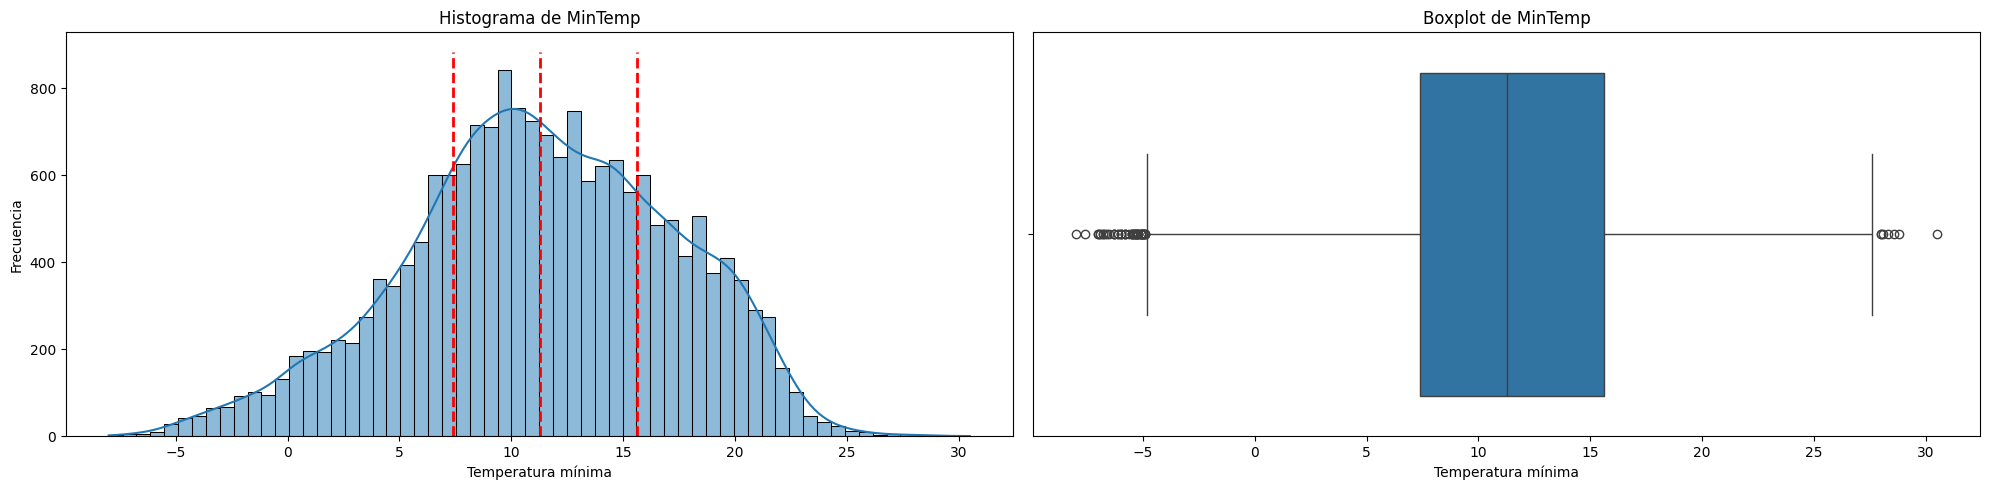

count    18193.000000
mean        11.262068
std          5.958471
min         -8.000000
25%          7.400000
50%         11.300000
75%         15.600000
max         30.500000
Name: MinTemp, dtype: float64

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(df['MinTemp'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de MinTemp')
axs[0].set_xlabel('Temperatura mínima')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = df['MinTemp'].quantile(0.25)
q2 = df['MinTemp'].quantile(0.5)
q3 = df['MinTemp'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=df['MinTemp'], ax=axs[1])
axs[1].set_title('Boxplot de MinTemp')
axs[1].set_xlabel('Temperatura mínima')

plt.tight_layout()
plt.show()

df['MinTemp'].describe()

### MaxTemp

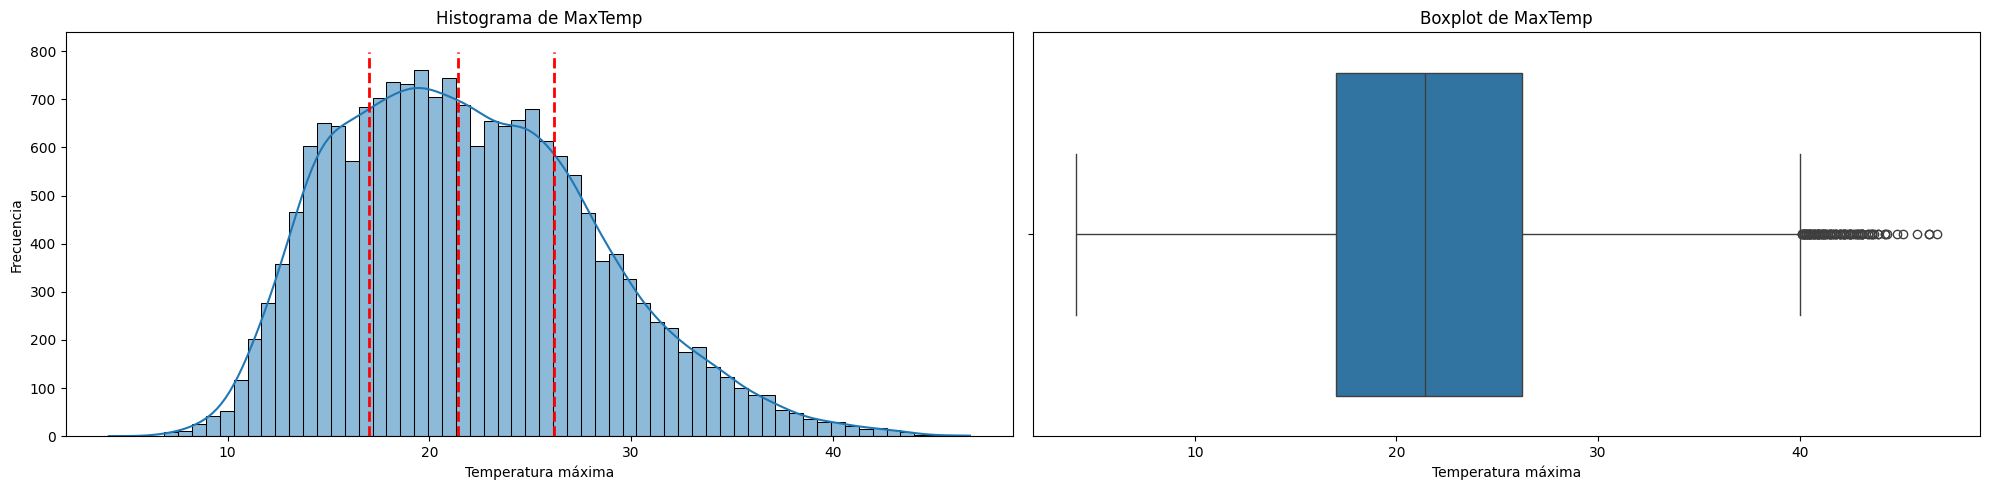

count    18202.000000
mean        21.924827
std          6.383207
min          4.100000
25%         17.000000
50%         21.400000
75%         26.200000
max         46.800000
Name: MaxTemp, dtype: float64

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(df['MaxTemp'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de MaxTemp')
axs[0].set_xlabel('Temperatura máxima')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = df['MaxTemp'].quantile(0.25)
q2 = df['MaxTemp'].quantile(0.5)
q3 = df['MaxTemp'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=df['MaxTemp'], ax=axs[1])
axs[1].set_title('Boxplot de MaxTemp')
axs[1].set_xlabel('Temperatura máxima')

plt.tight_layout()
plt.show()

df['MaxTemp'].describe()


### Rainfall

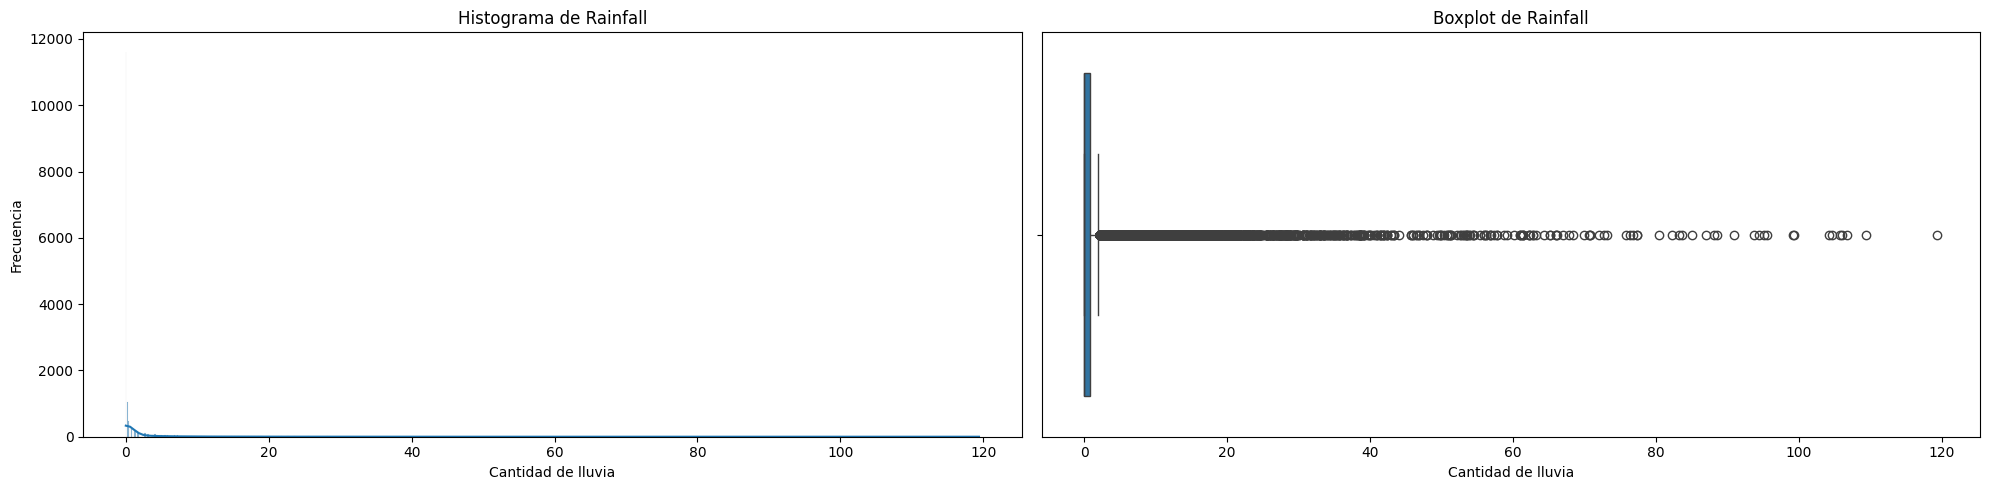

count    18026.000000
mean         2.237690
std          7.227048
min          0.000000
25%          0.000000
50%          0.000000
75%          0.800000
max        119.400000
Name: Rainfall, dtype: float64

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(df['Rainfall'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Rainfall')
axs[0].set_xlabel('Cantidad de lluvia')
axs[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=df['Rainfall'], ax=axs[1])
axs[1].set_title('Boxplot de Rainfall')
axs[1].set_xlabel('Cantidad de lluvia')

plt.tight_layout()
plt.show()

df['Rainfall'].describe()


### Evaporation

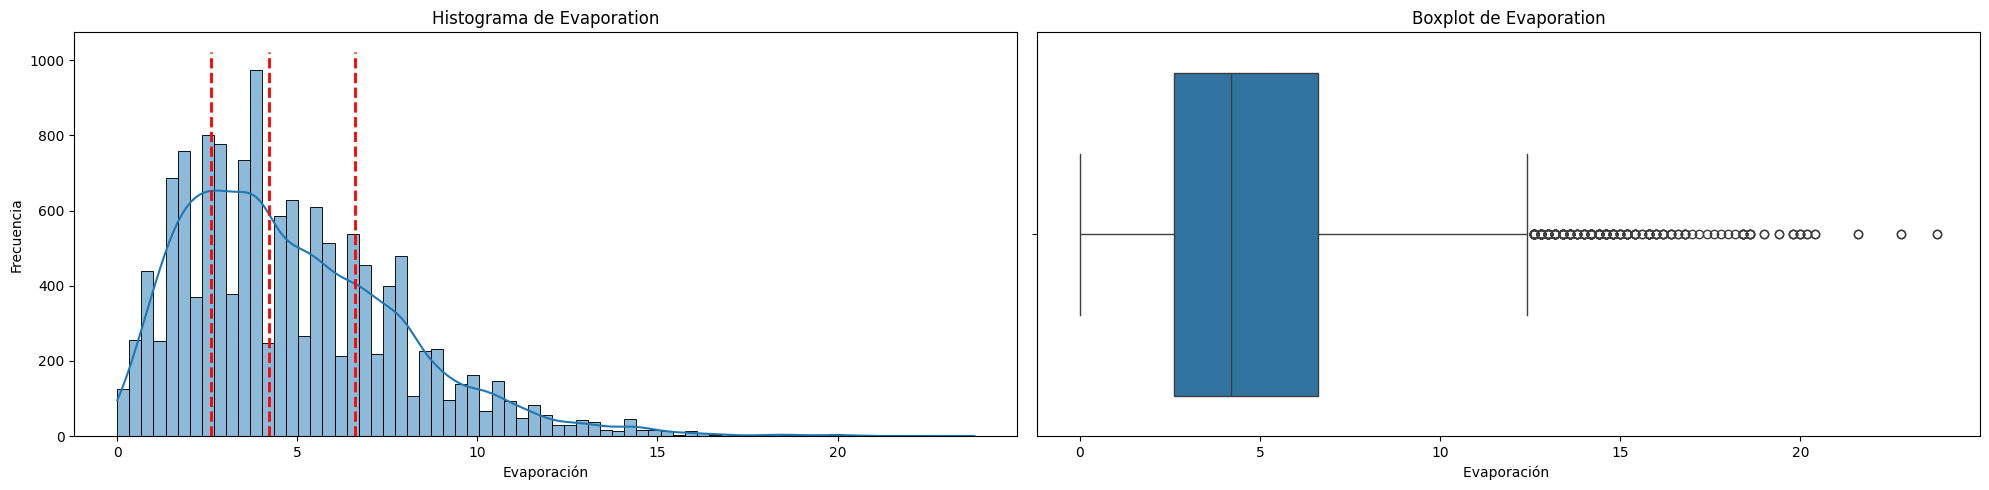

count    13505.000000
mean         4.869108
std          3.057514
min          0.000000
25%          2.600000
50%          4.200000
75%          6.600000
max         23.800000
Name: Evaporation, dtype: float64

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(df['Evaporation'], kde=True, ax=axs[0])

# Calcular cuartiles
q1 = df['Evaporation'].quantile(0.25)
q2 = df['Evaporation'].quantile(0.5)
q3 = df['Evaporation'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

axs[0].set_title('Histograma de Evaporation')
axs[0].set_xlabel('Evaporación')
axs[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=df['Evaporation'], ax=axs[1])
axs[1].set_title('Boxplot de Evaporation')
axs[1].set_xlabel('Evaporación ')

plt.tight_layout()
plt.show()

df['Evaporation'].describe()



### Sunshine

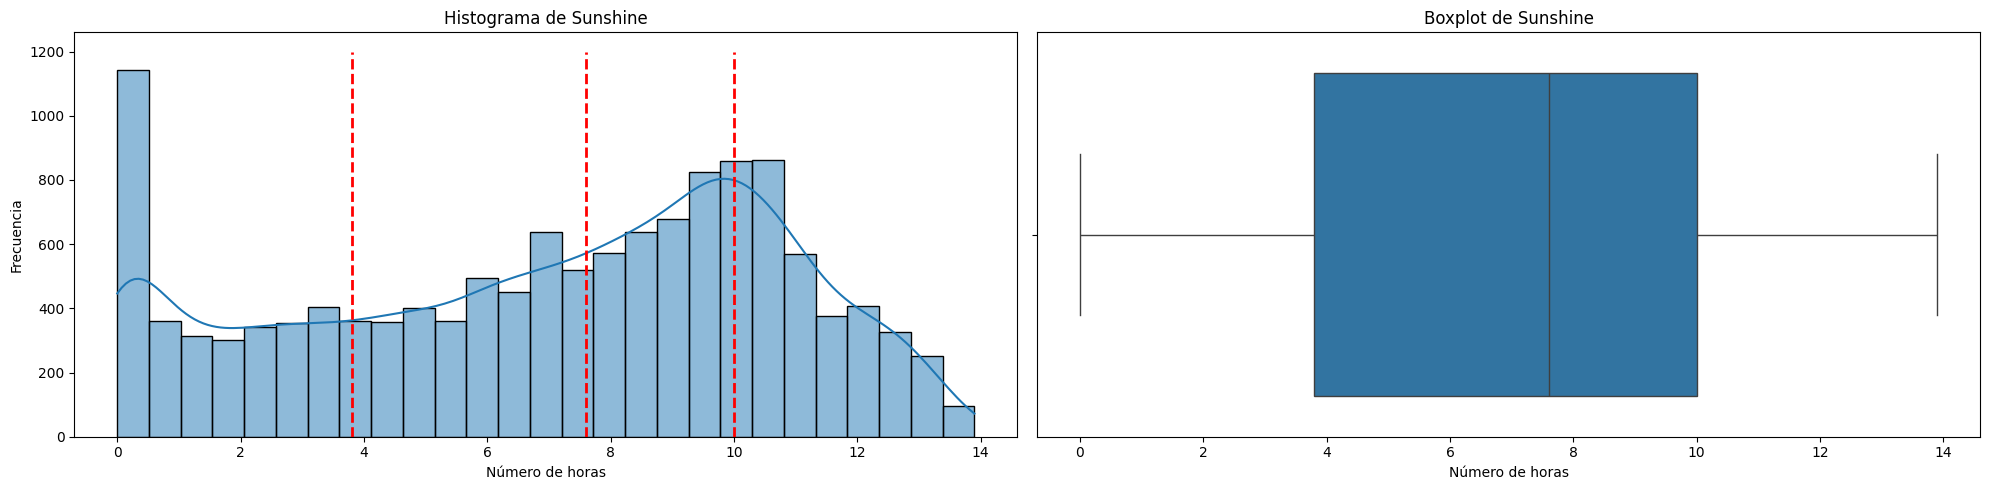

count    13260.000000
mean         6.897270
std          3.836702
min          0.000000
25%          3.800000
50%          7.600000
75%         10.000000
max         13.900000
Name: Sunshine, dtype: float64

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(df['Sunshine'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Sunshine')
axs[0].set_xlabel('Número de horas')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = df['Sunshine'].quantile(0.25)
q2 = df['Sunshine'].quantile(0.5)
q3 = df['Sunshine'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=df['Sunshine'], ax=axs[1])
axs[1].set_title('Boxplot de Sunshine')
axs[1].set_xlabel('Número de horas')

plt.tight_layout()
plt.show()

df['Sunshine'].describe()

### WindGustDir

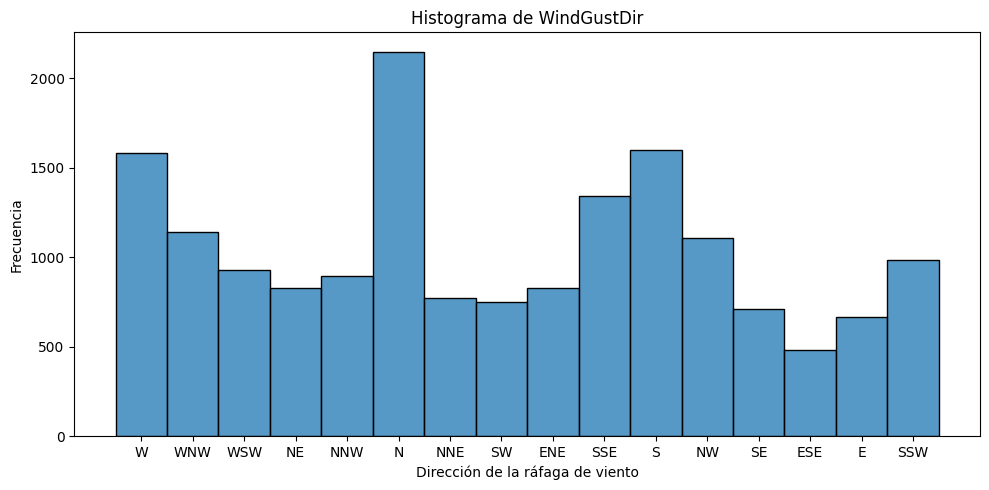

count     16754
unique       16
top           N
freq       2148
Name: WindGustDir, dtype: object

In [19]:
fig, axs = plt.subplots(figsize=(10, 5))

# Histograma
sns.histplot(df['WindGustDir'])
axs.set_title('Histograma de WindGustDir')
axs.set_xlabel('Dirección de la ráfaga de viento')
axs.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

df['WindGustDir'].describe()

### WindGustSpeed

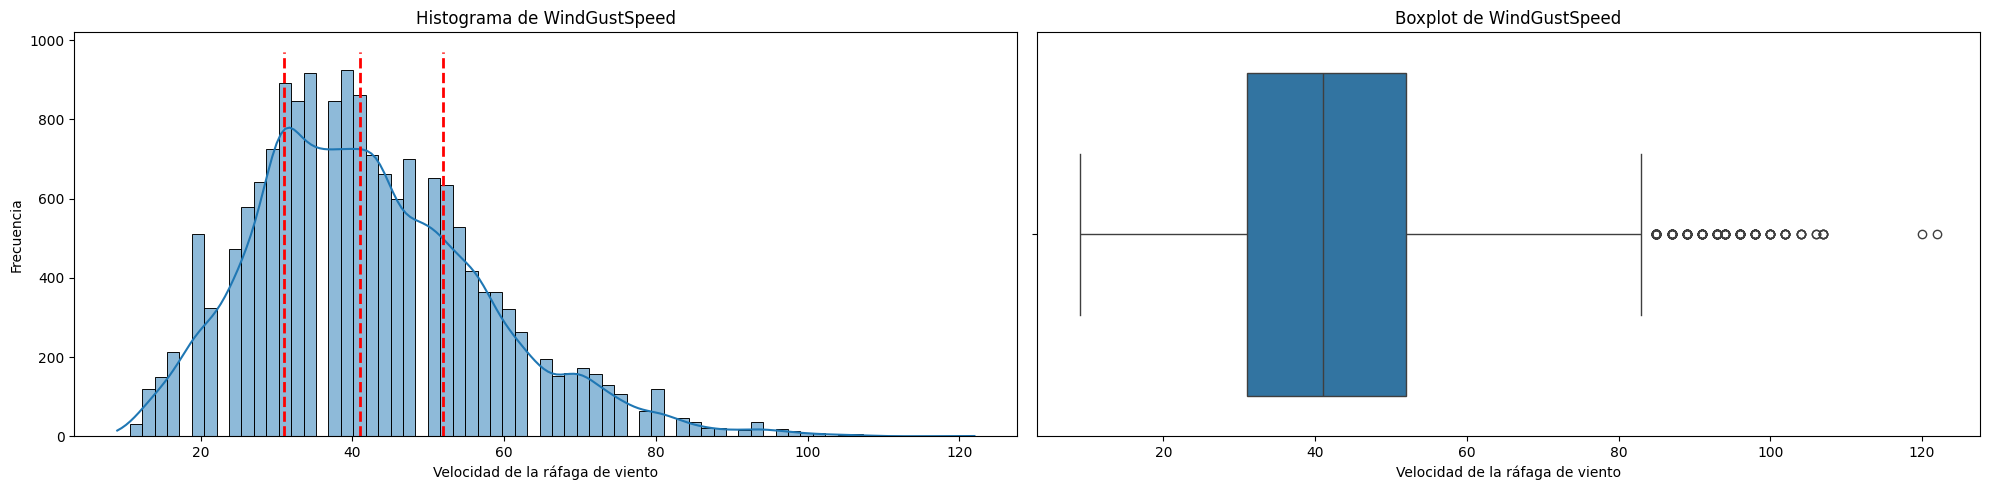

count    16756.000000
mean        42.288255
std         15.313873
min          9.000000
25%         31.000000
50%         41.000000
75%         52.000000
max        122.000000
Name: WindGustSpeed, dtype: float64

In [20]:

fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(df['WindGustSpeed'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de WindGustSpeed')
axs[0].set_xlabel('Velocidad de la ráfaga de viento')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = df['WindGustSpeed'].quantile(0.25)
q2 = df['WindGustSpeed'].quantile(0.5)
q3 = df['WindGustSpeed'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=df['WindGustSpeed'], ax=axs[1])
axs[1].set_title('Boxplot de WindGustSpeed')
axs[1].set_xlabel('Velocidad de la ráfaga de viento')

plt.tight_layout()
plt.show()
df['WindGustSpeed'].describe()

### WindDir9am

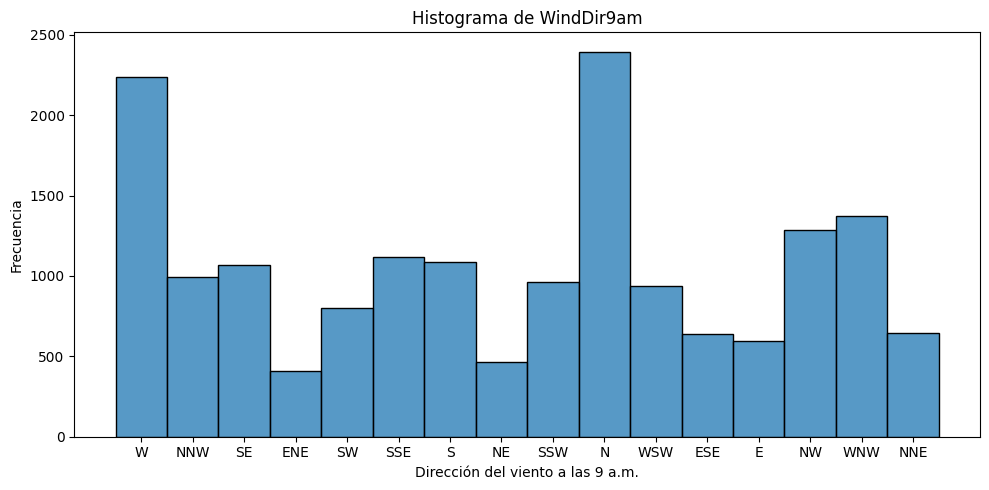

count     17014
unique       16
top           N
freq       2396
Name: WindDir9am, dtype: object

In [21]:
fig, axs = plt.subplots(figsize=(10, 5))

# Histograma
sns.histplot(df['WindDir9am'])
axs.set_title('Histograma de WindDir9am')
axs.set_xlabel('Dirección del viento a las 9 a.m.')
axs.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

df['WindDir9am'].describe()

### WindDir3pm

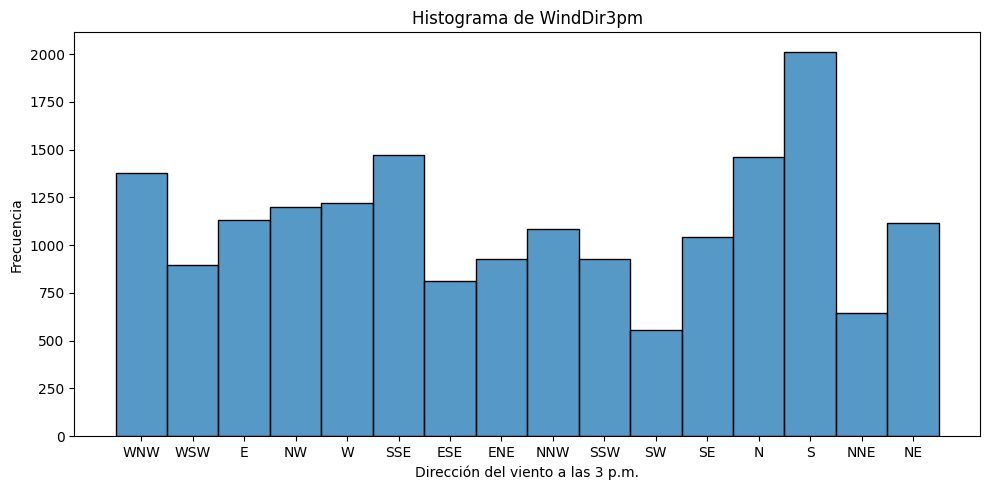

count     17879
unique       16
top           S
freq       2013
Name: WindDir3pm, dtype: object

In [22]:
fig, axs = plt.subplots(figsize=(10, 5))

# Histograma
sns.histplot(df['WindDir3pm'])
axs.set_title('Histograma de WindDir3pm')
axs.set_xlabel('Dirección del viento a las 3 p.m.')
axs.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

df['WindDir3pm'].describe()

### WindSpeed9am

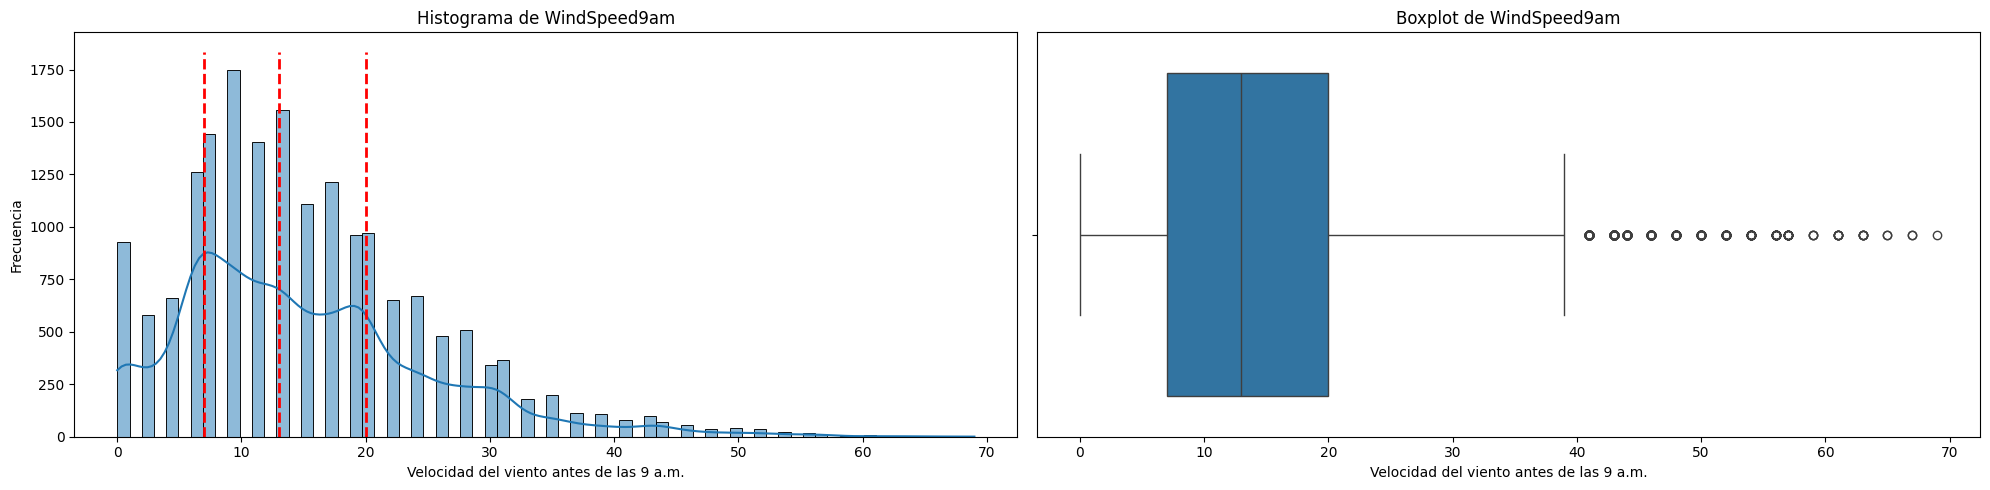

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(df['WindSpeed9am'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de WindSpeed9am')
axs[0].set_xlabel('Velocidad del viento antes de las 9 a.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = df['WindSpeed9am'].quantile(0.25)
q2 = df['WindSpeed9am'].quantile(0.5)
q3 = df['WindSpeed9am'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=df['WindSpeed9am'], ax=axs[1])
axs[1].set_title('Boxplot de WindSpeed9am')
axs[1].set_xlabel('Velocidad del viento antes de las 9 a.m.')

plt.tight_layout()
plt.show()


### WindSpeed3pm

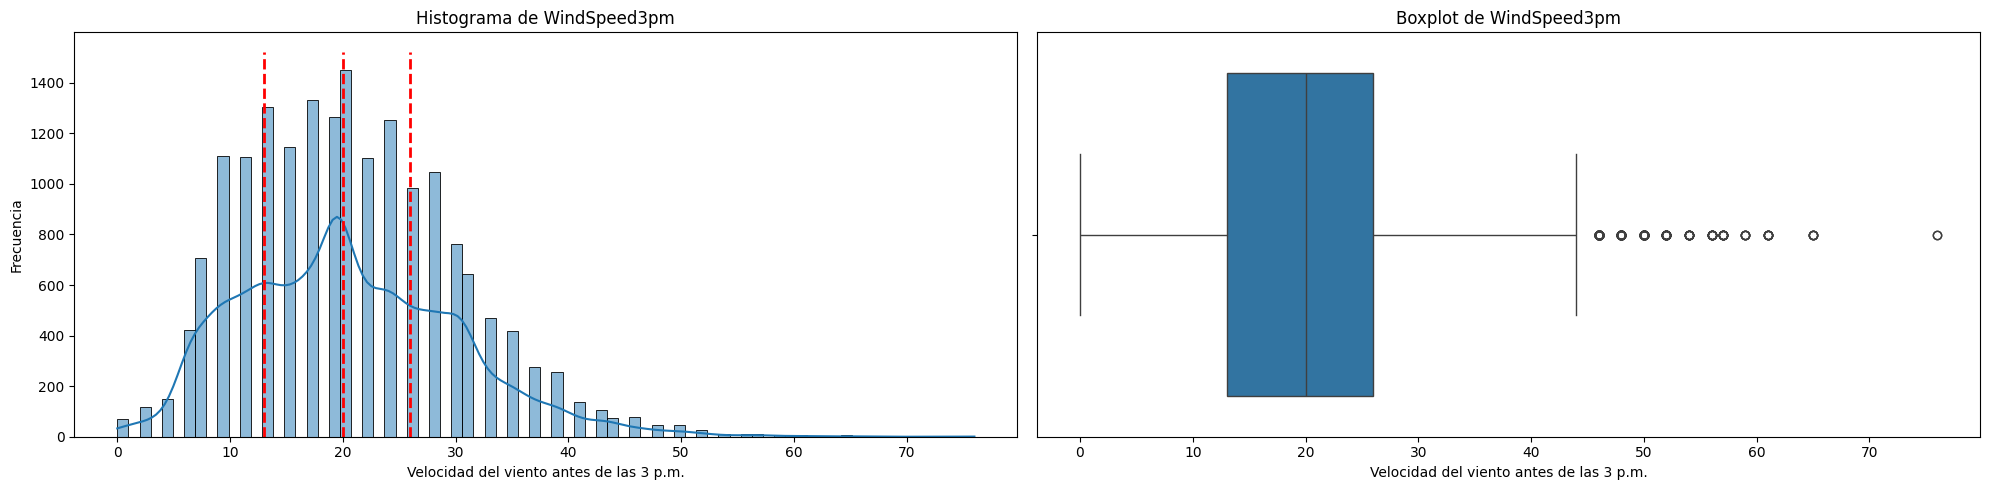

count    17953.000000
mean        20.515011
std          9.582158
min          0.000000
25%         13.000000
50%         20.000000
75%         26.000000
max         76.000000
Name: WindSpeed3pm, dtype: float64

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(df['WindSpeed3pm'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de WindSpeed3pm')
axs[0].set_xlabel('Velocidad del viento antes de las 3 p.m.')
axs[0].set_ylabel('Frecuencia')


# Calcular cuartiles
q1 = df['WindSpeed3pm'].quantile(0.25)
q2 = df['WindSpeed3pm'].quantile(0.5)
q3 = df['WindSpeed3pm'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=df['WindSpeed3pm'], ax=axs[1])
axs[1].set_title('Boxplot de WindSpeed3pm')
axs[1].set_xlabel('Velocidad del viento antes de las 3 p.m.')

plt.tight_layout()
plt.show()

df['WindSpeed3pm'].describe()

### Humidity9am

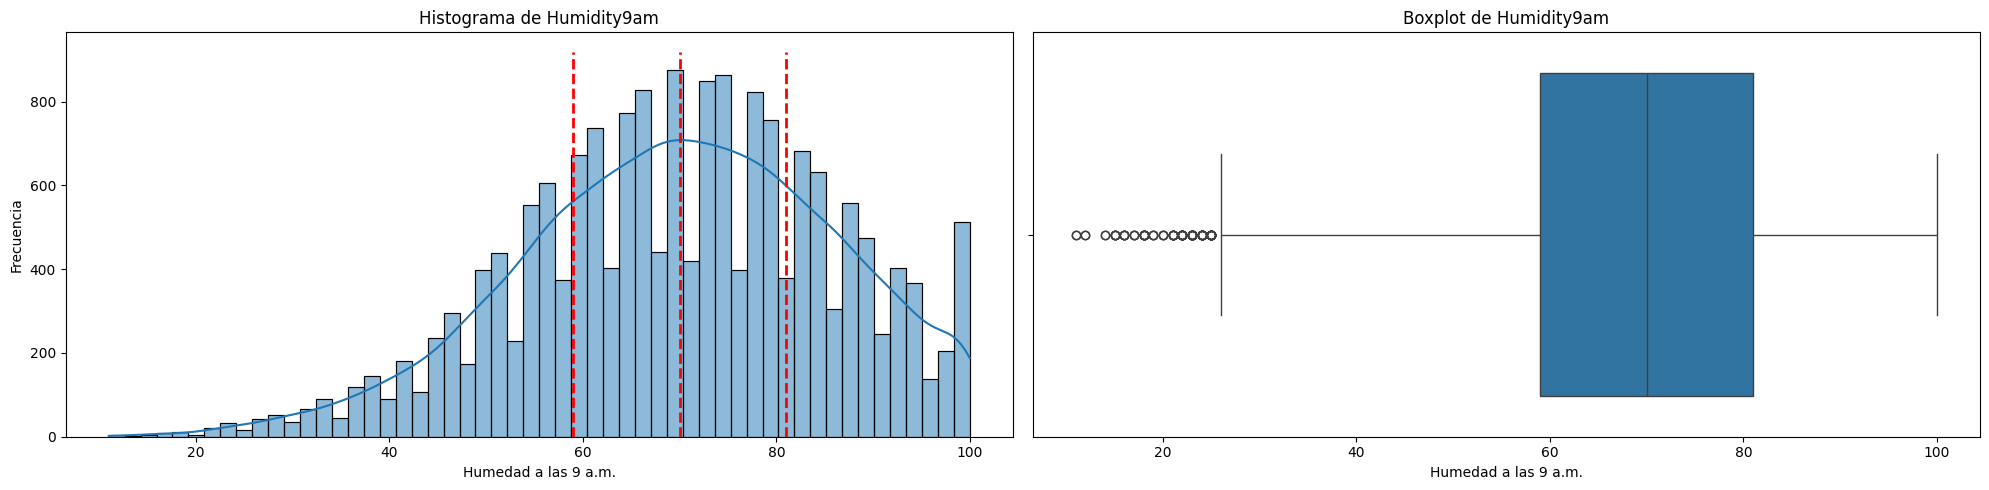

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(df['Humidity9am'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Humidity9am')
axs[0].set_xlabel('Humedad a las 9 a.m.')
axs[0].set_ylabel('Frecuencia')


# Calcular cuartiles
q1 = df['Humidity9am'].quantile(0.25)
q2 = df['Humidity9am'].quantile(0.5)
q3 = df['Humidity9am'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=df['Humidity9am'], ax=axs[1])
axs[1].set_title('Boxplot de Humidity9am')
axs[1].set_xlabel('Humedad a las 9 a.m.')

plt.tight_layout()
plt.show()



### Humidity3pm

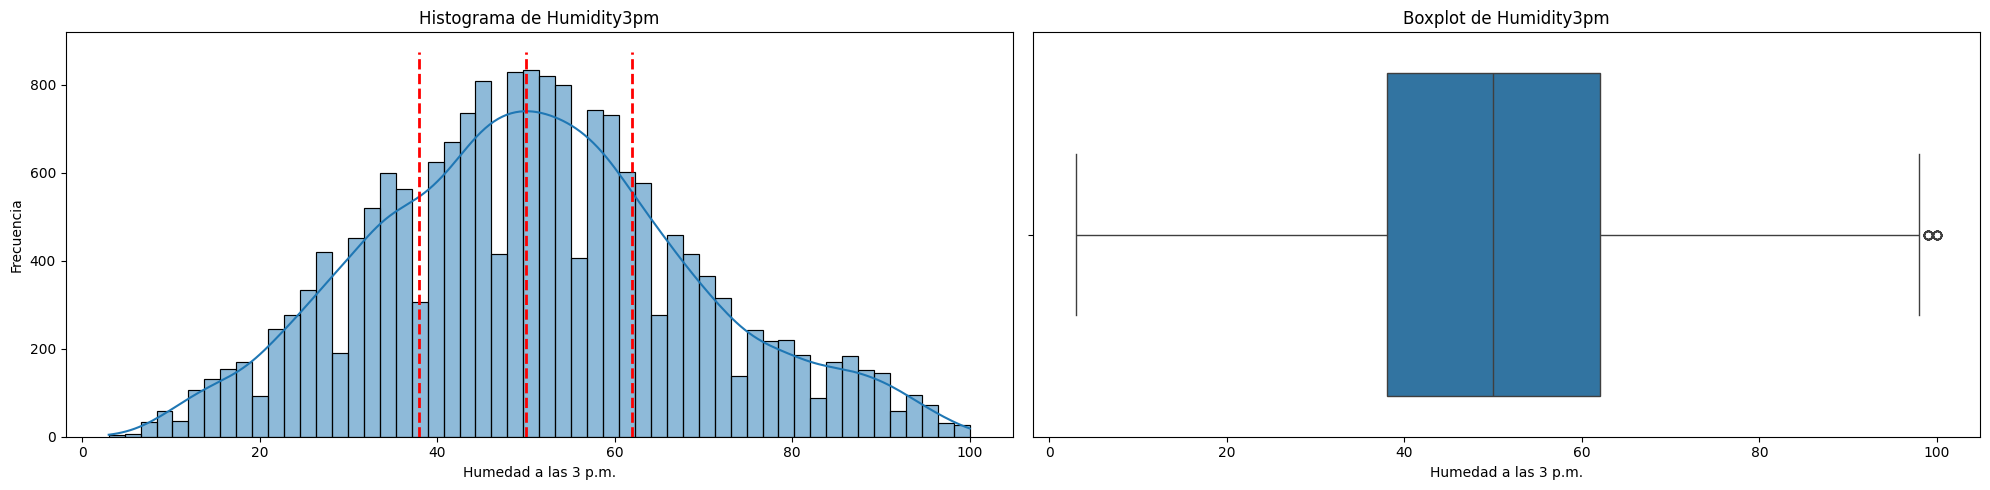

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(df['Humidity3pm'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Humidity3pm')
axs[0].set_xlabel('Humedad a las 3 p.m.')
axs[0].set_ylabel('Frecuencia')


# Calcular cuartiles
q1 = df['Humidity3pm'].quantile(0.25)
q2 = df['Humidity3pm'].quantile(0.5)
q3 = df['Humidity3pm'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=df['Humidity3pm'], ax=axs[1])
axs[1].set_title('Boxplot de Humidity3pm')
axs[1].set_xlabel('Humedad a las 3 p.m.')

plt.tight_layout()
plt.show()


### Pressure9am

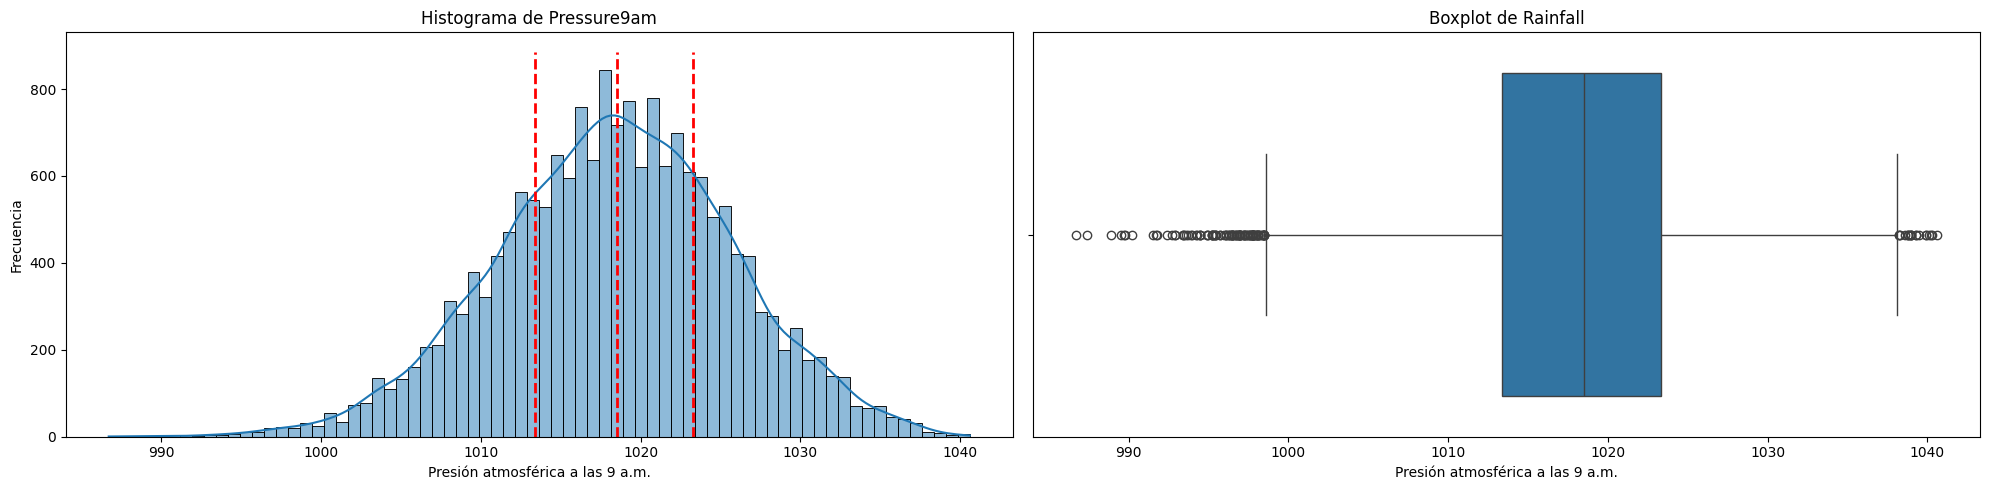

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(df['Pressure9am'], kde=True, ax=axs[0])

axs[0].set_title('Histograma de Pressure9am')
axs[0].set_xlabel('Presión atmosférica a las 9 a.m.')
axs[0].set_ylabel('Frecuencia')


# Calcular cuartiles
q1 = df['Pressure9am'].quantile(0.25)
q2 = df['Pressure9am'].quantile(0.5)
q3 = df['Pressure9am'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=df['Pressure9am'], ax=axs[1])
axs[1].set_title('Boxplot de Rainfall')
axs[1].set_xlabel('Presión atmosférica a las 9 a.m.')

plt.tight_layout()
plt.show()



### Pressure3pm

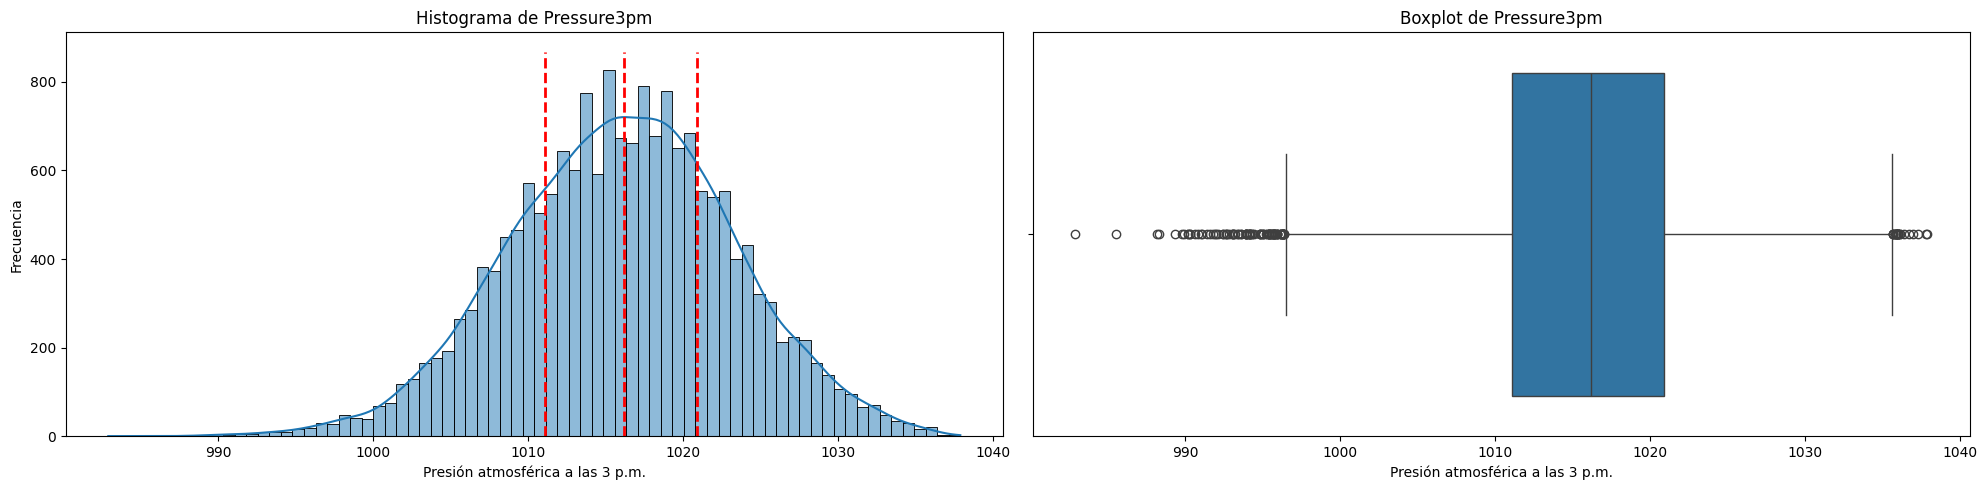

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(df['Pressure3pm'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Pressure3pm')
axs[0].set_xlabel('Presión atmosférica a las 3 p.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = df['Pressure3pm'].quantile(0.25)
q2 = df['Pressure3pm'].quantile(0.5)
q3 = df['Pressure3pm'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=df['Pressure3pm'], ax=axs[1])
axs[1].set_title('Boxplot de Pressure3pm')
axs[1].set_xlabel('Presión atmosférica a las 3 p.m.')

plt.tight_layout()
plt.show()



### Cloud9am

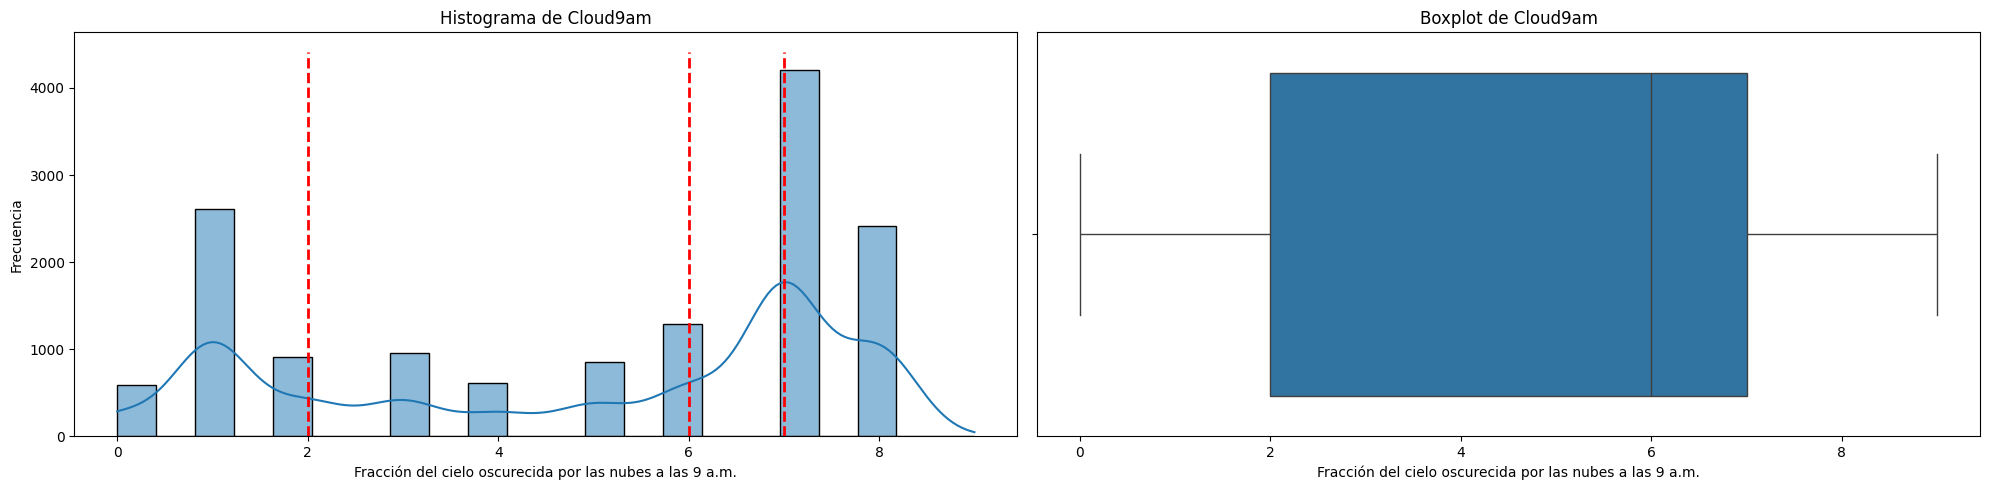

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))


# Histograma
sns.histplot(df['Cloud9am'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Cloud9am')
axs[0].set_xlabel('Fracción del cielo oscurecida por las nubes a las 9 a.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = df['Cloud9am'].quantile(0.25)
q2 = df['Cloud9am'].quantile(0.5)
q3 = df['Cloud9am'].quantile(0.75)


# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=df['Cloud9am'], ax=axs[1])
axs[1].set_title('Boxplot de Cloud9am')
axs[1].set_xlabel('Fracción del cielo oscurecida por las nubes a las 9 a.m.')

plt.tight_layout()
plt.show()



### Cloud3pm

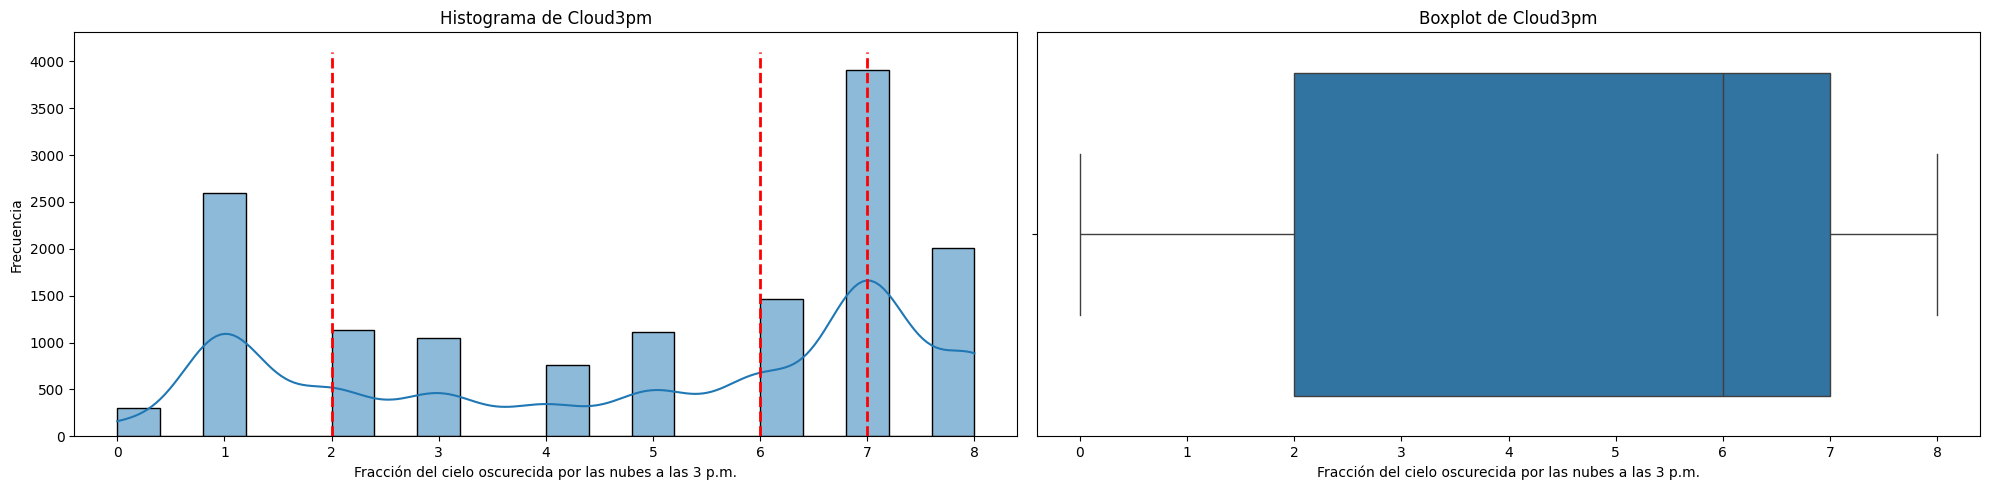

count    14331.000000
mean         4.803154
std          2.625413
min          0.000000
25%          2.000000
50%          6.000000
75%          7.000000
max          8.000000
Name: Cloud3pm, dtype: float64

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(df['Cloud3pm'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Cloud3pm')
axs[0].set_xlabel('Fracción del cielo oscurecida por las nubes a las 3 p.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = df['Cloud3pm'].quantile(0.25)
q2 = df['Cloud3pm'].quantile(0.5)
q3 = df['Cloud3pm'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=df['Cloud3pm'], ax=axs[1])
axs[1].set_title('Boxplot de Cloud3pm')
axs[1].set_xlabel('Fracción del cielo oscurecida por las nubes a las 3 p.m.')

plt.tight_layout()
plt.show()

df['Cloud3pm'].describe()

### Temp9am

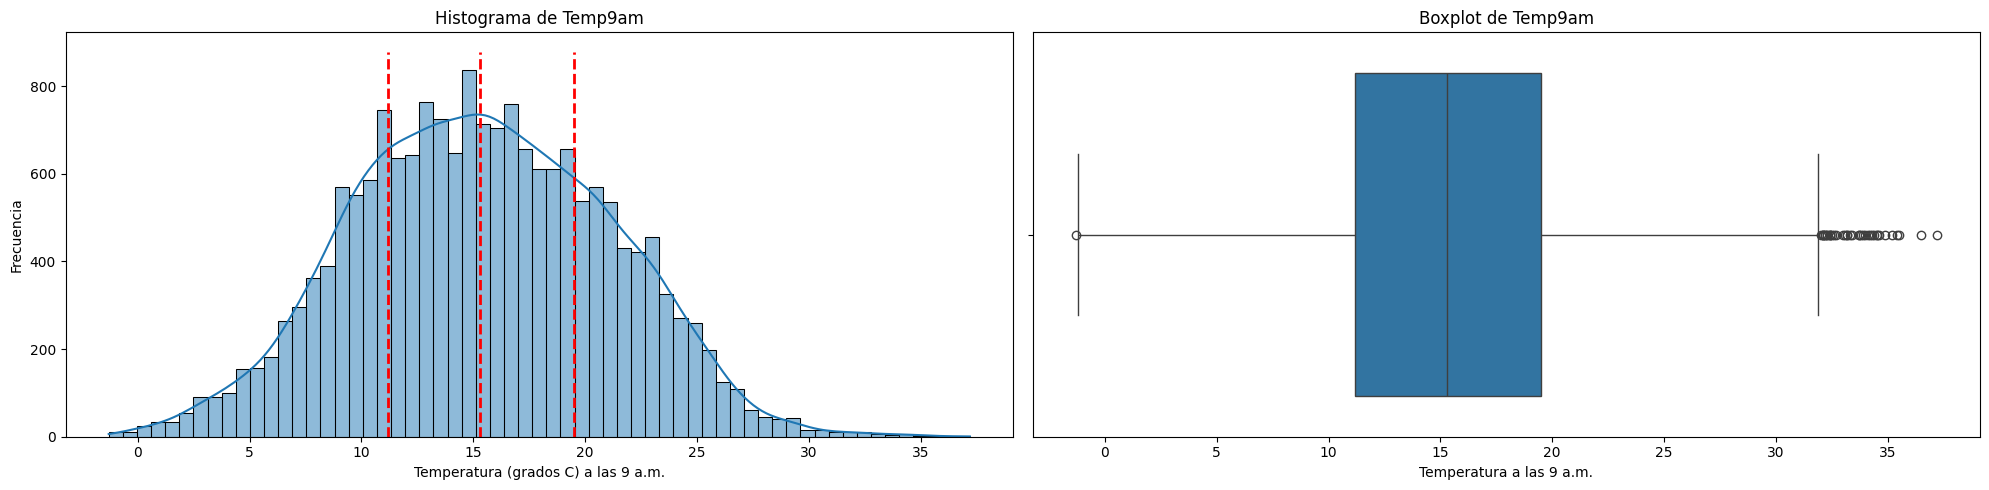

count    18181.000000
mean        15.369050
std          5.728972
min         -1.300000
25%         11.200000
50%         15.300000
75%         19.500000
max         37.200000
Name: Temp9am, dtype: float64

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(df['Temp9am'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Temp9am')
axs[0].set_xlabel('Temperatura (grados C) a las 9 a.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = df['Temp9am'].quantile(0.25)
q2 = df['Temp9am'].quantile(0.5)
q3 = df['Temp9am'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=df['Temp9am'], ax=axs[1])
axs[1].set_title('Boxplot de Temp9am')
axs[1].set_xlabel('Temperatura a las 9 a.m.')

plt.tight_layout()
plt.show()

df['Temp9am'].describe()

### Temp3pm

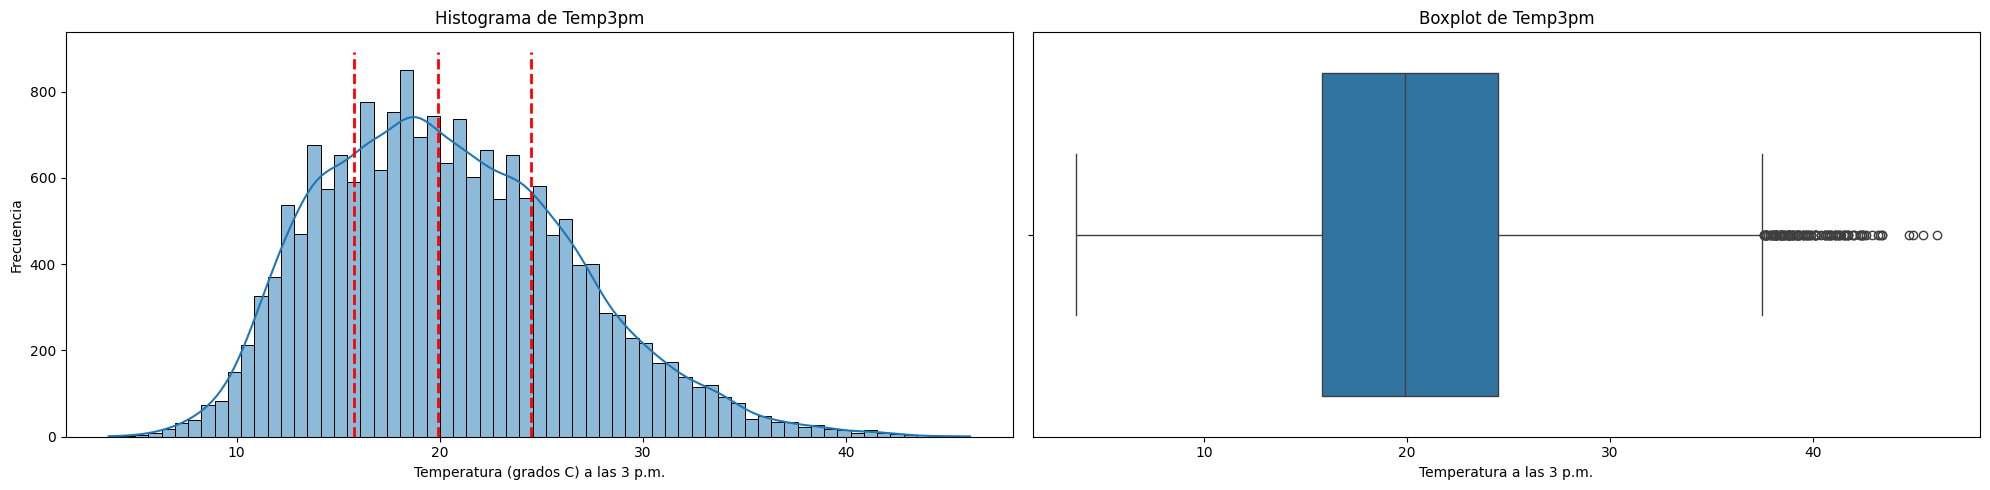

count    18189.000000
mean        20.443515
std          6.178520
min          3.700000
25%         15.800000
50%         19.900000
75%         24.500000
max         46.100000
Name: Temp3pm, dtype: float64

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))


# Histograma
sns.histplot(df['Temp3pm'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Temp3pm')
axs[0].set_xlabel('Temperatura (grados C) a las 3 p.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = df['Temp3pm'].quantile(0.25)
q2 = df['Temp3pm'].quantile(0.5)
q3 = df['Temp3pm'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=df['Temp3pm'], ax=axs[1])
axs[1].set_title('Boxplot de Temp3pm')
axs[1].set_xlabel('Temperatura a las 3 p.m.')

plt.tight_layout()
plt.show()

df['Temp3pm'].describe()

### RainToday

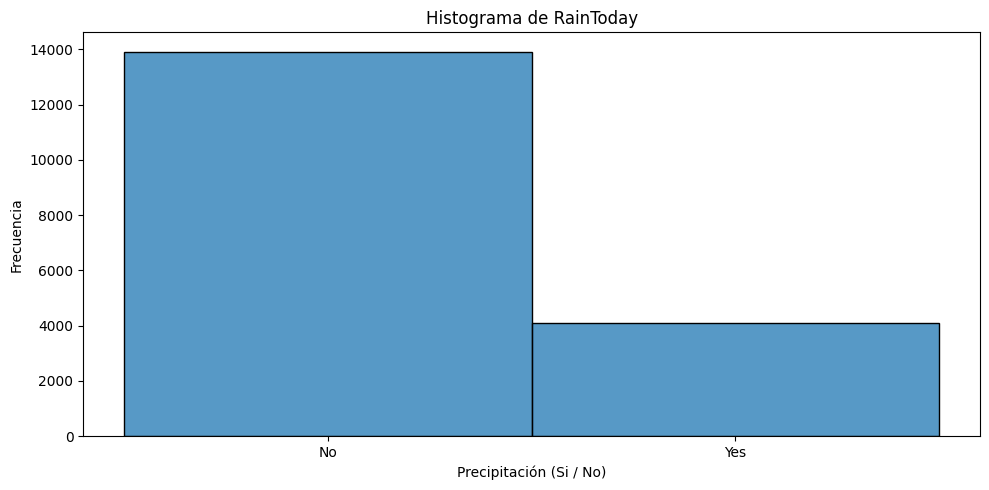

count     18026
unique        2
top          No
freq      13916
Name: RainToday, dtype: object

In [33]:
fig, axs = plt.subplots(figsize=(10, 5))

# Histograma
sns.histplot(df['RainToday'])
axs.set_title('Histograma de RainToday')
axs.set_xlabel('Precipitación (Si / No)')
axs.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

df['RainToday'].describe()

### RainTomorrow

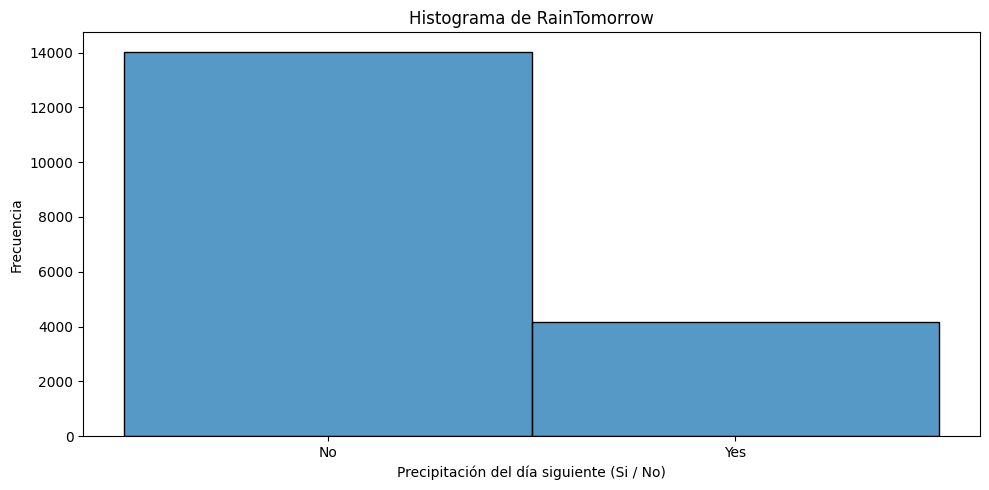

count     18209
unique        2
top          No
freq      14036
Name: RainTomorrow, dtype: object

In [34]:
fig, axs = plt.subplots(figsize=(10, 5))

# Histograma
sns.histplot(df['RainTomorrow'])
axs.set_title('Histograma de RainTomorrow')
axs.set_xlabel('Precipitación del día siguiente (Si / No)')
axs.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

df['RainTomorrow'].describe()

### RainfallTomorrow

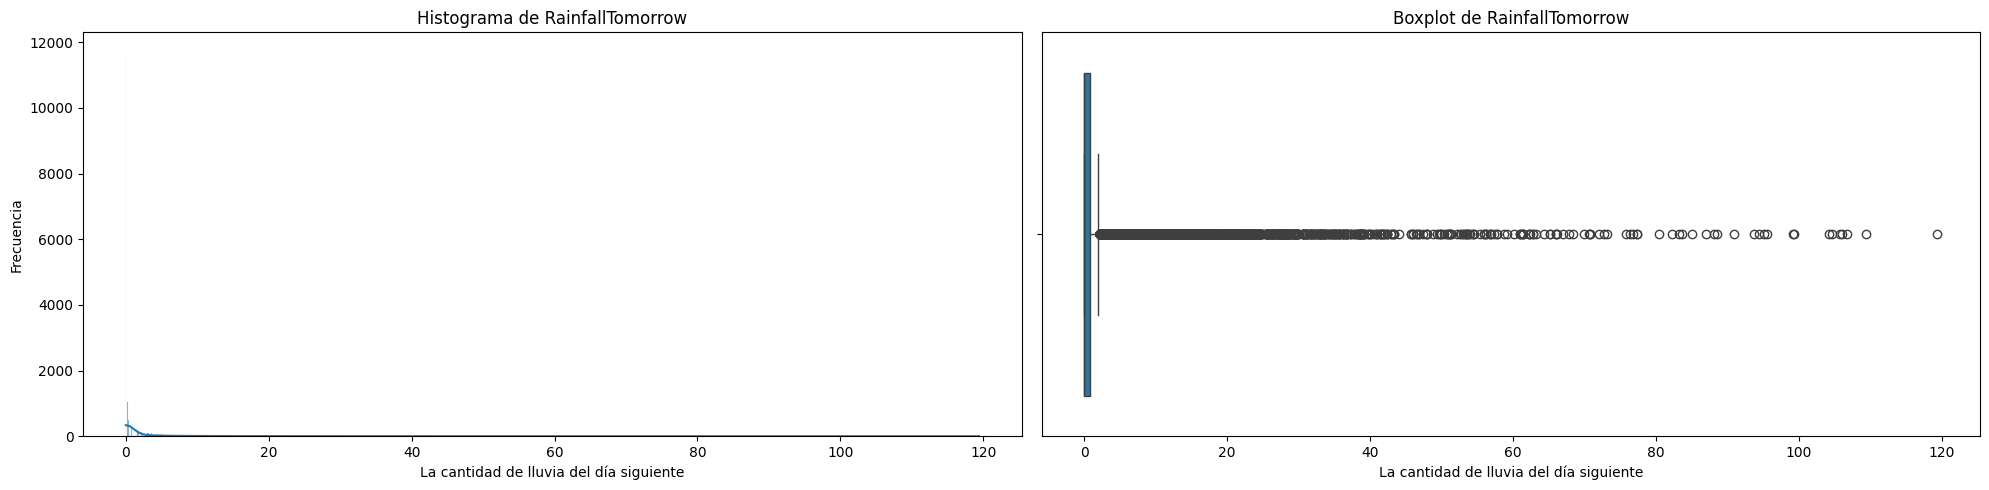

count    18209.000000
mean         2.238443
std          7.208498
min          0.000000
25%          0.000000
50%          0.000000
75%          0.800000
max        119.400000
Name: RainfallTomorrow, dtype: float64

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(df['RainfallTomorrow'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de RainfallTomorrow')
axs[0].set_xlabel('La cantidad de lluvia del día siguiente')
axs[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=df['RainfallTomorrow'], ax=axs[1])
axs[1].set_title('Boxplot de RainfallTomorrow')
axs[1].set_xlabel('La cantidad de lluvia del día siguiente')

plt.tight_layout()
plt.show()

df['RainfallTomorrow'].describe()

### Outliers y desbalance de datos

Las siguientes caracteristicas presentan valores atípicos: , **MinTemp**, **MaxTemp**, **Rainfall**, **Evaporation**, **WindGustSpeed**, **WindSpeed9am**, **RainfallTomorrow**, **WindSpeed3pm**, **Humidity9am**, **Pressure9am**, **Pressure3pm**, **Temp9am** y **Temp3pm**.

Los valores atípicos pueden sesgar los parámetros del modelo al desviar la línea de regresión, afectando la relación general entre las variables. Podemos optar por tratarlos o no. Si decidimos tratarlos, debemos hacer una excepción con la columna RainfallTomorrow, que es la variable objetivo, y limitar la eliminación de outliers a un máximo del 10% del total de datos para evitar la pérdida de información valiosa y sesgar los resultados del modelo.

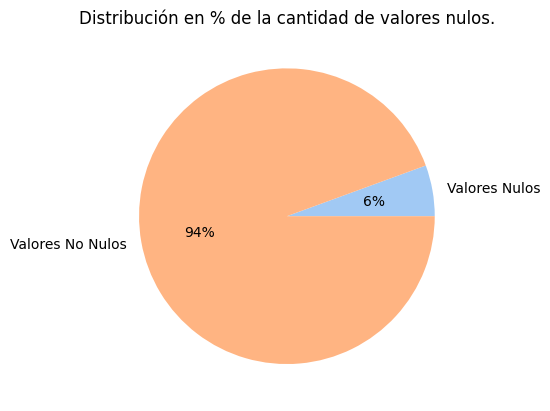

In [36]:
# Calcula el número total de valores (nulos y no nulos)
total_valores = np.product(df.shape)

# Calcula el número de valores nulos
valores_nulos = df.isnull().sum().sum()


# Calcula el número de valores no nulos
valores_no_nulos = total_valores - valores_nulos

# Crea una lista con los valores para el gráfico
datos = [valores_nulos, valores_no_nulos]

# Crea una lista con las etiquetas para el gráfico
etiquetas = ['Valores Nulos', 'Valores No Nulos']

colors = sns.color_palette("pastel")

plt.title('Distribución en % de la cantidad de valores nulos.')
plt.pie(datos, labels=etiquetas, colors=colors, autopct='%.0f%%')
plt.show()

- Date: Fecha de observación.

        Debemos eliminarla porque no contiene información relevante.
        
- Location: El nombre de la ubicación de la estación meteorológica.

        Debemos descartar todas las ubicaciones que no nos interesen y luego las restantes asumirlas como una misma y única, para poder posteriormente eliminar Location y reducir la dimensionalidad para un modelo más simple.

- MinTemp: La temperatura mínima (°C).
- MaxTemp: La temperatura máxima (°C).

        Deberíamos tener en consideración la posibilidad de añadir a nuestro data set una nueva dimensión la cual sea la temperatura promedio durante el día (PromTemp = MaxTemp - MinTemp)

- Rainfall: La cantidad de lluvia registrada durante el día (mm).
- Evaporation: La evaporación del recipiente Clase A (mm) en el período de 24 horas a las 9 a.m.
- Sunshine: El número de horas de sol brillante en el día.
- WindGustDir: La dirección de la ráfaga de viento más fuerte en las 24 horas hasta la medianoche.
- WindGustSpeed: La velocidad (km/h) de la ráfaga de viento más fuerte en las 24 horas hasta la medianoche.
- WindDir9am: Dirección del viento a las 9 a.m.
- WindDir3pm: Dirección del viento a las 3 p.m.
- WindSpeed9am: Velocidad del viento (km/h) promediada de las 9 a.m.
- WindSpeed3pm: Velocidad del viento (km/h) promediada de las 3 p.m.
- Humidity9am: Humedad (porcentaje) a las 9 a.m.
- Humidity3pm: Humedad (porcentaje) a las 3 p.m.

        Deberíamos tener en consideración la posibilidad de añadir a nuestro data set una nueva dimensión la cual sea la diferencia de humedad (ΔHumidity = Humidity3pm - Humidity9am)

- Pressure9am: La presión atmosférica (hPa) a las 9 a. m.
- Pressure3pm: La presión atmosférica (hPa) a las 3 p. m.

        Deberíamos tener en consideración la posibilidad de añadir a nuestro data set una nueva dimensión la cual sea la diferencia de presión atmosférica (ΔPressure = Pressure3pm - Pressure9am)

- Cloud9am: Fracción del cielo oscurecida por las nubes a las 9 a.m. Esto se mide en "oktas", que son una unidad de octavos. Registra cuantos
- Cloud3pm: Fracción del cielo oscurecida por las nubes a las 3 p.m. Esto se mide en "oktas", que son una unidad de octavos. Registra cuantos
- Temp9am: Temperatura (grados C) a las 9 a.m.
- Temp3pm: Temperatura (grados C) a las 3 p.m.
- RainToday: Booleano: 1 si la precipitación (mm) en las 24 horas hasta las 9 a. m. excede 1 mm; de lo contrario, 0
- RainTomorrow: Booleano: 1 si la precipitación (mm) en las siguientes 24 horas hasta las 9 a. m. excede 1 mm; de lo contrario, 0
- RainfallTomorrow: La cantidad de lluvia del día siguiente en mm. Se utiliza para crear la variable de respuesta RainTomorrow. Una especie de medida del "riesgo".

Las siguientes características presentan un desbalance de datos: **RainToday**, **RainTomorrow**.

- RainTomorrow: Trataremos el desbalance de datos ya que es nuestra target y planeamos quedarnos con la metric

- Vamos a observar si **raintoday** es importante balancearla segun la correlacion que tenga con mi variable objetivo


Correlación entre RainToday y RainTomorrow:
                        RainToday_Converted  RainTomorrow_Converted
RainToday_Converted                1.000000                0.263739
RainTomorrow_Converted             0.263739                1.000000


C:\Users\brisa\AppData\Local\Temp\ipykernel_22748\3531839347.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RainToday_Converted'] = df['RainToday'].map({'Yes': 1, 'No': 0})
C:\Users\brisa\AppData\Local\Temp\ipykernel_22748\3531839347.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RainTomorrow_Converted'] = df['RainTomorrow'].map({'Yes': 1, 'No': 0})


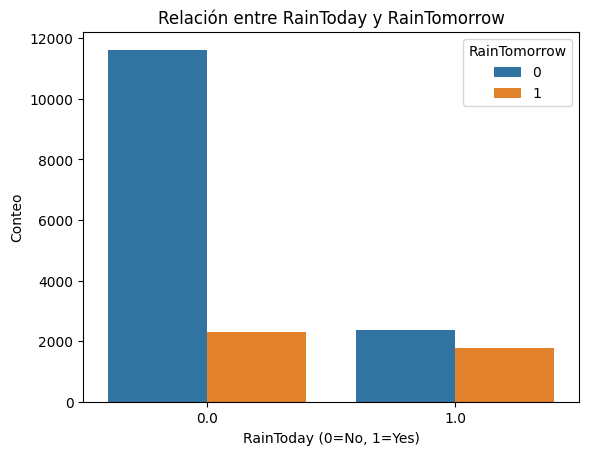

In [37]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Crear copias de las columnas originales y convertir 'Yes'/'No' a 1/0
df['RainToday_Converted'] = df['RainToday'].map({'Yes': 1, 'No': 0})
df['RainTomorrow_Converted'] = df['RainTomorrow'].map({'Yes': 1, 'No': 0})

# Analizar la correlación entre las columnas convertidas
correlation = df[['RainToday_Converted', 'RainTomorrow_Converted']].corr()
print("\nCorrelación entre RainToday y RainTomorrow:")
print(correlation)

# Visualizar la relación con un gráfico de conteo
sns.countplot(x='RainToday_Converted', hue='RainTomorrow_Converted', data=df)
plt.title('Relación entre RainToday y RainTomorrow')
plt.xlabel('RainToday (0=No, 1=Yes)')
plt.ylabel('Conteo')
plt.legend(title='RainTomorrow')
plt.show()



Dado que la variable RainToday tiene una influencia del 20% en la predicción de RainTomorrow, su impacto en el modelo es moderado. Esto sugiere que el balanceo de esta variable puede no ser crucial. Aunque RainToday contribuye significativamente a la predicción, su influencia no es tan predominante como para justificar un balanceo exhaustivo de las clases. Por lo tanto, el desbalance en RainToday podría ser manejable sin necesidad de aplicar técnicas de balanceo adicionales, siempre y cuando el modelo sea evaluado y validado adecuadamente para asegurar un rendimiento óptimo.



In [38]:

# Eliminar las columnas temporales convertidas
df.drop(columns=['RainToday_Converted', 'RainTomorrow_Converted'], inplace=True)

# Verificar que las columnas fueron eliminadas
print(df.head())

         Date  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine WindGustDir  \
0  2008-12-01     13.4     22.9       0.6          NaN       NaN           W   
1  2008-12-02      7.4     25.1       0.0          NaN       NaN         WNW   
2  2008-12-03     12.9     25.7       0.0          NaN       NaN         WSW   
3  2008-12-04      9.2     28.0       0.0          NaN       NaN          NE   
4  2008-12-05     17.5     32.3       1.0          NaN       NaN           W   

   WindGustSpeed WindDir9am WindDir3pm  ...  Humidity3pm  Pressure9am  \
0           44.0          W        WNW  ...         22.0       1007.7   
1           44.0        NNW        WSW  ...         25.0       1010.6   
2           46.0          W        WSW  ...         30.0       1007.6   
3           24.0         SE          E  ...         16.0       1017.6   
4           41.0        ENE         NW  ...         33.0       1010.8   

   Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  RainTomorrow  \

C:\Users\brisa\AppData\Local\Temp\ipykernel_22748\463120786.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['RainToday_Converted', 'RainTomorrow_Converted'], inplace=True)


# División del conjunto de datos, Train y Test

Dividimos el set de datos en train y test antes de realizar la imputación de nulos para evitar la generación de un data leakage

Esto lo hacemos a través de la fecha, ya que de este modo podemos mantener la integridad temporal de nuestros datos y evitar el data leakage. Al dividir los datos en conjuntos de entrenamiento y prueba basándonos en una fecha específica, estamos respetando el orden cronológico de los eventos. Esto es especialmente importante en series temporales y en problemas donde la secuencia y la temporalidad importan.

Por otro lado, si utilizáramos train_test_split de manera aleatoria, podríamos terminar con datos de prueba que se filtraron en el conjunto de entrenamiento después de la imputación. Esto podría llevar a un modelo sobreajustado que funciona bien en los datos de entrenamiento, pero falla al generalizar en datos nuevos o futuros.

In [39]:
# Convierto la columna 'Date' a tipo datetime
df["Date"] = pd.to_datetime(df["Date"])

# Mostrar la primera y última fecha
primera_fecha = df['Date'].min()
ultima_fecha = df['Date'].max()

print("Primera fecha:", primera_fecha)
print("Última fecha:", ultima_fecha)

# Calcular la fecha que abarque el 80% de los datos
fecha_80porciento = df['Date'].quantile(0.8)

print("Fecha que abarca el 80% de los datos:", fecha_80porciento)

Primera fecha: 2007-11-01 00:00:00
Última fecha: 2017-06-24 00:00:00
Fecha que abarca el 80% de los datos: 2015-09-17 00:00:00


C:\Users\brisa\AppData\Local\Temp\ipykernel_22748\3951250150.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])


In [40]:
# Dividir los datos en conjuntos de entrenamiento y prueba basados en la fecha
train = df[df['Date'] <= fecha_80porciento]

test = df[df['Date'] > fecha_80porciento]

Ya que la fecha no aporta nada más de valor, procedemos a eliminarla para reducir un poco más la dimensionalidad y así la complejidad de nuestro modelo.

In [41]:
train = train.drop('Date', axis=1)

test = test.drop('Date', axis=1)

In [42]:
df

Date  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0     2008-12-01     13.4     22.9       0.6          NaN       NaN   
1     2008-12-02      7.4     25.1       0.0          NaN       NaN   
2     2008-12-03     12.9     25.7       0.0          NaN       NaN   
3     2008-12-04      9.2     28.0       0.0          NaN       NaN   
4     2008-12-05     17.5     32.3       1.0          NaN       NaN   
...          ...      ...      ...       ...          ...       ...   
70366 2017-06-20      6.4     15.8       0.0          2.4       8.8   
70367 2017-06-21      7.8     13.5       0.6          0.6       0.0   
70368 2017-06-22      6.7     14.1       0.2          0.6       0.0   
70369 2017-06-23      7.4     14.9       0.0          1.6       6.0   
70370 2017-06-24      8.3     12.3       1.4          1.8       5.6   

      WindGustDir  WindGustSpeed WindDir9am WindDir3pm  ...  Humidity3pm  \
0               W           44.0          W        WNW  ...         22.0   
1             WNW           44.0        NNW        WSW  ...         25.0   
2             WSW           46.0          W        WSW  ...         30.0   
3              NE           24.0         SE          E  ...         16.0   
4               W           41.0        ENE         NW  ...         33.0   
...           ...            ...        ...        ...  ...          ...   
70366           N           39.0        NNE          N  ...         56.0   
70367         NNW           24.0          W          S  ...         80.0   
70368           N           24.0        NNE          N  ...         56.0   
70369         NNW           44.0          N          N  ...         63.0   
70370          SW           30.0        WNW          S  ...         63.0   

       Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  \
0           1007.7       1007.1       8.0       NaN     16.9     21.8   
1           1010.6       1007.8       NaN       NaN     17.2     24.3   
2           1007.6       1008.7       NaN       2.0     21.0     23.2   
3           1017.6       1012.8       NaN       NaN     18.1     26.5   
4           1010.8       1006.0       7.0       8.0     17.8     29.7   
...            ...          ...       ...       ...      ...      ...   
70366       1028.1       1024.5       1.0       7.0      7.9     15.6   
70367       1028.8       1028.4       7.0       7.0     11.2     12.7   
70368       1028.2       1024.8       7.0       7.0      7.5     13.5   
70369       1018.8       1013.8       1.0       7.0      9.1     12.5   
70370       1018.7       1017.4       2.0       7.0      9.6     11.2   

       RainToday  RainTomorrow  RainfallTomorrow  
0             No            No               0.0  
1             No            No               0.0  
2             No            No               0.0  
3             No            No               1.0  
4             No            No               0.2  
...          ...           ...               ...  
70366         No            No               0.6  
70367         No            No               0.2  
70368         No            No               0.0  
70369         No           Yes               1.4  
70370        Yes            No               0.0  

[18209 rows x 23 columns]

**18209  filas**

In [43]:
train

MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine WindGustDir  \
0         13.4     22.9       0.6          NaN       NaN           W   
1          7.4     25.1       0.0          NaN       NaN         WNW   
2         12.9     25.7       0.0          NaN       NaN         WSW   
3          9.2     28.0       0.0          NaN       NaN          NE   
4         17.5     32.3       1.0          NaN       NaN           W   
...        ...      ...       ...          ...       ...         ...   
69465     14.0     27.3       0.0          7.6      10.3         SSE   
69466     15.9     39.4       0.0          5.2      10.4           N   
69467     20.8     38.4       0.0         23.8       8.6         NNE   
69468     16.4     23.9       5.4         16.8       7.8           N   
69469     15.6     23.9       0.2          6.4      10.3         SSE   

       WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  ...  Humidity3pm  \
0               44.0          W        WNW          20.0  ...         22.0   
1               44.0        NNW        WSW           4.0  ...         25.0   
2               46.0          W        WSW          19.0  ...         30.0   
3               24.0         SE          E          11.0  ...         16.0   
4               41.0        ENE         NW           7.0  ...         33.0   
...              ...        ...        ...           ...  ...          ...   
69465           37.0        SSW         NE          24.0  ...         42.0   
69466           54.0         NE          N           9.0  ...         10.0   
69467           85.0          N          N          54.0  ...         17.0   
69468           70.0          S        SSE          20.0  ...         48.0   
69469           35.0        SSE        SSE          15.0  ...         58.0   

       Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  \
0           1007.7       1007.1       8.0       NaN     16.9     21.8   
1           1010.6       1007.8       NaN       NaN     17.2     24.3   
2           1007.6       1008.7       NaN       2.0     21.0     23.2   
3           1017.6       1012.8       NaN       NaN     18.1     26.5   
4           1010.8       1006.0       7.0       8.0     17.8     29.7   
...            ...          ...       ...       ...      ...      ...   
69465       1013.9       1013.6       NaN       NaN     17.6     23.7   
69466       1014.5       1010.1       NaN       5.0     20.8     37.7   
69467       1012.1       1006.9       NaN       NaN     30.5     37.4   
69468       1017.9       1017.7       NaN       NaN     16.8     21.8   
69469       1020.3       1019.4       7.0       7.0     18.4     22.4   

       RainToday  RainTomorrow RainfallTomorrow  
0             No            No              0.0  
1             No            No              0.0  
2             No            No              0.0  
3             No            No              1.0  
4             No            No              0.2  
...          ...           ...              ...  
69465         No            No              0.0  
69466         No            No              0.0  
69467         No           Yes              5.4  
69468        Yes            No              0.2  
69469         No            No              0.0  

[14570 rows x 22 columns]

**18209 * 0.8 = 14570 filas**

In [44]:
test

MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine WindGustDir  \
2393       3.6     19.2       0.0          NaN       NaN          SE   
2394       6.1     20.4       0.0          NaN       NaN          NE   
2395       5.6     21.5       0.0          NaN       NaN         ENE   
2396       6.4     20.9       0.0          NaN       NaN           W   
2397       6.2     16.3       0.2          NaN       NaN          SW   
...        ...      ...       ...          ...       ...         ...   
70366      6.4     15.8       0.0          2.4       8.8           N   
70367      7.8     13.5       0.6          0.6       0.0         NNW   
70368      6.7     14.1       0.2          0.6       0.0           N   
70369      7.4     14.9       0.0          1.6       6.0         NNW   
70370      8.3     12.3       1.4          1.8       5.6          SW   

       WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  ...  Humidity3pm  \
2393            24.0         SE        SSE           9.0  ...         44.0   
2394            24.0         SE        NNE           7.0  ...         42.0   
2395            22.0          E         NE           7.0  ...         52.0   
2396            35.0        NaN         NW           0.0  ...         50.0   
2397            41.0        WSW         SW          20.0  ...         36.0   
...              ...        ...        ...           ...  ...          ...   
70366           39.0        NNE          N          11.0  ...         56.0   
70367           24.0          W          S           2.0  ...         80.0   
70368           24.0        NNE          N           9.0  ...         56.0   
70369           44.0          N          N          17.0  ...         63.0   
70370           30.0        WNW          S          11.0  ...         63.0   

       Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  \
2393        1027.3       1025.0       NaN       NaN     12.9     18.4   
2394        1026.8       1022.5       NaN       6.0     13.7     19.2   
2395        1023.9       1019.7       NaN       2.0     13.5     20.4   
2396        1019.0       1014.9       8.0       3.0     12.6     20.5   
2397        1021.8       1022.0       NaN       4.0     10.7     15.3   
...            ...          ...       ...       ...      ...      ...   
70366       1028.1       1024.5       1.0       7.0      7.9     15.6   
70367       1028.8       1028.4       7.0       7.0     11.2     12.7   
70368       1028.2       1024.8       7.0       7.0      7.5     13.5   
70369       1018.8       1013.8       1.0       7.0      9.1     12.5   
70370       1018.7       1017.4       2.0       7.0      9.6     11.2   

       RainToday  RainTomorrow RainfallTomorrow  
2393          No            No              0.0  
2394          No            No              0.0  
2395          No            No              0.0  
2396          No            No              0.2  
2397          No            No              0.0  
...          ...           ...              ...  
70366         No            No              0.6  
70367         No            No              0.2  
70368         No            No              0.0  
70369         No           Yes              1.4  
70370        Yes            No              0.0  

[3639 rows x 22 columns]

**18209 * 0.2 = 3639  filas**

# Manejo de datos faltantes

## Eliminación de datos faltantes de Train y Test

Verificamos si existen filas que contengan solo valores nulos.

In [45]:
# Contamos el número total de filas que tengan todos sus valores como nulos en train
train_nulas = train.isnull().all(axis=1).sum()

train_nulas

0

In [46]:
# Contamos el número total de filas que tengan todos sus valores como nulos en test
test_nulas = test.isnull().all(axis=1).sum()

test_nulas

0

Vemos que no tiene filas donde todos sus valores son nulos, así que hace falta realizar ninguna acción.

## Completado de datos

**Datos numericos:** Usaremos media para rellenar los datos faltantes, ya que la media es una medida de tendencia central que no se ve afectada por los valores extremos o atípicos que podrían sesgar y distorsionar mis resultados.

**Datos categoricos:**  Usaremos la moda para rellenar los datos faltantes, ya que, dado que las variables categóricas no son numéricas, medidas como la media y la mediana no tienen sentido en este contexto.  Al rellenar los datos faltantes con la moda, estoy esencialmente asumiendo que la categoría más común es la más probable de ocurrir en los datos faltantes. Esto puede no ser siempre el caso, pero es una suposición razonable en ausencia de información adicional.

### Completado de datos de Train

Rellenamos los datos faltantes con la moda para los categoricos y con la media para los numericos

In [47]:
# Manejo de datos faltantes
# Calcular la media y la moda en el conjunto de entrenamiento
numeric_cols = train.select_dtypes(include=np.number).columns
categorical_cols = train.select_dtypes(include='object').columns

# Imputación en el conjunto de entrenamiento
train[numeric_cols] = train[numeric_cols].fillna(train[numeric_cols].mean())
train[categorical_cols] = train[categorical_cols].fillna(train[categorical_cols].mode().iloc[0])


Verificamos que se hayan rellenado los valores faltantes con la moda correctamente y que no queden valores nulos.

In [49]:
train[['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']].isnull().sum()

WindGustDir     0
WindDir9am      0
WindDir3pm      0
RainToday       0
RainTomorrow    0
dtype: int64

In [50]:
columns_to_check = [col for col in train.columns if col not in ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']]
train[columns_to_check].isnull().sum()

MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
WindGustSpeed       0
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainfallTomorrow    0
dtype: int64

### Completado de datos de Test

Vemos que si hay datos faltantes, por lo tanto, rellenamos los datos faltantes con la moda para los categoricos y con la media para los numericos

In [51]:
# Manejo de datos faltantes
# Calcular la media y la moda en el conjunto de entrenamiento
numeric_cols = train.select_dtypes(include=np.number).columns
categorical_cols = train.select_dtypes(include='object').columns


# Usar las estadísticas calculadas en el conjunto de entrenamiento para imputar en el conjunto de prueba
test[numeric_cols] = test[numeric_cols].fillna(train[numeric_cols].mean())
test[categorical_cols] = test[categorical_cols].fillna(train[categorical_cols].mode().iloc[0])

Verificamos que se hayan rellenado los valores faltantes con la moda correctamente y que no queden valores nulos.

In [52]:
test.isnull().sum()

MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
WindGustDir         0
WindGustSpeed       0
WindDir9am          0
WindDir3pm          0
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainToday           0
RainTomorrow        0
RainfallTomorrow    0
dtype: int64

# Estandarización

Estandarizamos las características porque pueden tener diferentes rangos de valores.
Estandarizarlas asegura que todas las características tengan la misma escala, lo que evita que las características
con mayores rangos dominen el modelo. 

In [53]:
# Crear el estandarizador
scaler = StandardScaler()

## Estandarización de Train

In [54]:
# Seleccionar las columnas a estandarizar
columns_to_standardize = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainfallTomorrow']

# Aplicar la estandarización a las columnas seleccionadas
train[columns_to_standardize] = scaler.fit_transform(train[columns_to_standardize])

In [55]:
train

MinTemp   MaxTemp  Rainfall   Evaporation      Sunshine WindGustDir  \
0      0.395411  0.199145 -0.224724  3.370918e-16 -2.676527e-16           W   
1     -0.609240  0.548666 -0.308589  3.370918e-16 -2.676527e-16         WNW   
2      0.311690  0.643990 -0.308589  3.370918e-16 -2.676527e-16         WSW   
3     -0.307845  1.009398 -0.308589  3.370918e-16 -2.676527e-16          NE   
4      1.081922  1.692552 -0.168814  3.370918e-16 -2.676527e-16           W   
...         ...       ...       ...           ...           ...         ...   
69465  0.495876  0.898187 -0.308589  1.079248e+00  1.029244e+00         SSE   
69466  0.814015  2.820551 -0.308589  1.683722e-01  1.059379e+00           N   
69467  1.634480  2.661678 -0.308589  7.227659e+00  5.169484e-01         NNE   
69468  0.897736  0.358019  0.446198  4.570938e+00  2.758683e-01           N   
69469  0.763783  0.358019 -0.280634  6.238100e-01  1.029244e+00         SSE   

       WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  ...  Humidity3pm  \
0           0.096538          W        WNW      0.448233  ...    -1.593170   
1           0.096538        NNW        WSW     -1.093962  ...    -1.426583   
2           0.232217          W        WSW      0.351845  ...    -1.148938   
3          -1.260252         SE          E     -0.419252  ...    -1.926344   
4          -0.106981        ENE         NW     -0.804800  ...    -0.982351   
...              ...        ...        ...           ...  ...          ...   
69465      -0.378339        SSW         NE      0.833781  ...    -0.482591   
69466       0.774933         NE          N     -0.612026  ...    -2.259518   
69467       2.877956          N          N      3.725396  ...    -1.870815   
69468       1.860364          S        SSE      0.448233  ...    -0.149417   
69469      -0.514017        SSE        SSE     -0.033703  ...     0.405873   

       Pressure9am  Pressure3pm      Cloud9am  Cloud3pm   Temp9am   Temp3pm  \
0        -1.470705    -1.259530  1.292111e+00  0.000000  0.314564  0.263082   
1        -1.072669    -1.161585 -3.632460e-16  0.000000  0.367152  0.672782   
2        -1.484430    -1.035657 -3.632460e-16 -1.211773  1.033264  0.492514   
3        -0.111894    -0.461985 -3.632460e-16  0.000000  0.524915  1.033318   
4        -1.045219    -1.413442  8.831320e-01  1.386983  0.472327  1.557734   
...            ...          ...           ...       ...       ...       ...   
69465    -0.619732    -0.350049 -3.632460e-16  0.000000  0.437269  0.574454   
69466    -0.537380    -0.839769 -3.632460e-16  0.087605  0.998206  2.868774   
69467    -0.866789    -1.287514 -3.632460e-16  0.000000  2.698546  2.819610   
69468    -0.070718     0.223623 -3.632460e-16  0.000000  0.297035  0.263082   
69469     0.258690     0.461487  8.831320e-01  0.953857  0.577503  0.361410   

       RainToday  RainTomorrow RainfallTomorrow  
0             No            No        -0.307762  
1             No            No        -0.307762  
2             No            No        -0.307762  
3             No            No        -0.168295  
4             No            No        -0.279869  
...          ...           ...              ...  
69465         No            No        -0.307762  
69466         No            No        -0.307762  
69467         No           Yes         0.445361  
69468        Yes            No        -0.279869  
69469         No            No        -0.307762  

[14570 rows x 22 columns]

## Estandarización de Test

In [56]:
# Seleccionar las columnas a estandarizar
columns_to_standardize = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainfallTomorrow']

# Aplicar la estandarización a las columnas seleccionadas
test[columns_to_standardize] = scaler.transform(test[columns_to_standardize])

In [57]:
test

MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine WindGustDir  \
2393  -1.245519 -0.388685 -0.308589     0.000000  0.000000          SE   
2394  -0.826915 -0.198037 -0.308589     0.000000  0.000000          NE   
2395  -0.910636 -0.023277 -0.308589     0.000000  0.000000         ENE   
2396  -0.776682 -0.118601 -0.308589     0.000000  0.000000           W   
2397  -0.810171 -0.849417 -0.280634     0.000000  0.000000          SW   
...         ...       ...       ...          ...       ...         ...   
70366 -0.776682 -0.928853 -0.308589    -0.894316  0.577218           N   
70367 -0.542264 -1.294261 -0.224724    -1.577473 -2.074663         NNW   
70368 -0.726450 -1.198937 -0.280634    -1.577473 -2.074663           N   
70369 -0.609240 -1.071839 -0.308589    -1.197942 -0.266562         NNW   
70370 -0.458543 -1.484909 -0.112904    -1.122035 -0.387102          SW   

       WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  ...  Humidity3pm  \
2393       -1.260252         SE        SSE     -0.612026  ...    -0.371533   
2394       -1.260252         SE        NNE     -0.804800  ...    -0.482591   
2395       -1.395931          E         NE     -0.804800  ...     0.072699   
2396       -0.514017          N         NW     -1.479510  ...    -0.038359   
2397       -0.106981        WSW         SW      0.448233  ...    -0.815764   
...              ...        ...        ...           ...  ...          ...   
70366      -0.242660        NNE          N     -0.419252  ...     0.294815   
70367      -1.260252          W          S     -1.286736  ...     1.627511   
70368      -1.260252        NNE          N     -0.612026  ...     0.294815   
70369       0.096538          N          N      0.159071  ...     0.683518   
70370      -0.853215        WNW          S     -0.419252  ...     0.683518   

       Pressure9am  Pressure3pm  Cloud9am  Cloud3pm   Temp9am   Temp3pm  \
2393      1.219465     1.245039  0.000000  0.000000 -0.386607 -0.294110   
2394      1.150839     0.895239  0.000000  0.520731 -0.246373 -0.163006   
2395      0.752803     0.503463  0.000000 -1.211773 -0.281431  0.033650   
2396      0.080261    -0.168153  1.292111 -0.778647 -0.439195  0.050038   
2397      0.464571     0.825279  0.000000 -0.345521 -0.772251 -0.802138   
...            ...          ...       ...       ...       ...       ...   
70366     1.329268     1.175079 -1.570740  0.953857 -1.263071 -0.752974   
70367     1.425346     1.720768  0.883132  0.953857 -0.684605 -1.228226   
70368     1.342994     1.217055  0.883132  0.953857 -1.333188 -1.097122   
70369     0.052810    -0.322065 -1.570740  0.953857 -1.052720 -1.261002   
70370     0.039085     0.181647 -1.161761  0.953857 -0.965073 -1.474046   

       RainToday  RainTomorrow RainfallTomorrow  
2393          No            No        -0.307762  
2394          No            No        -0.307762  
2395          No            No        -0.307762  
2396          No            No        -0.279869  
2397          No            No        -0.307762  
...          ...           ...              ...  
70366         No            No        -0.224082  
70367         No            No        -0.279869  
70368         No            No        -0.307762  
70369         No           Yes        -0.112508  
70370        Yes            No        -0.307762  

[3639 rows x 22 columns]

**En el conjunto de entrenamiento:**
Se aplica fit_transform del StandardScaler para ajustar el escalador a los datos de entrenamiento y transformar esos datos.

**En el conjunto de prueba:**
Se aplica transform del StandardScaler ya ajustado para transformar los datos de prueba usando la misma media y desviación estándar que en el conjunto de entrenamiento.

Esto asegura una transformación consistente y evita la fuga de información.



# One hot enconding (Dummies)

Al tener demasiadas variables categóricas en mi DataFrame, lo que hice fue simplificar la situación agrupándolas. Tenía una columna con direcciones de viento que incluía 16 categorías distintas como 'N', 'NNW', 'NNE', etc. Pero para mi análisis, no necesitaba tanta granularidad, así que decidí agrupar estas 16 categorías en solo 4: 'N', 'S', 'E' y 'W'.

Para hacer esto, creé un diccionario que mapeaba cada una de las 16 categorías a una de las 4 direcciones principales. Luego, utilicé la función map de pandas para aplicar este mapeo a mi columna. De esta manera, pude reducir la cantidad de categorías únicas en mi columna de 16 a solo 4, lo que simplificó mucho mi análisis

## Dummies de Train

In [58]:
diccionario = {
    'N': ['N', 'NNW', 'NNE', 'NE', 'NW'],
    'S': ['S', 'SSW', 'SSE', 'SE', 'SW'],
    'E': ['E', 'ENE', 'ESE'],
    'W': ['W', 'WNW', 'WSW'],
}

# Invertir el diccionario para el mapeo
diccionario_invertido = {valor: clave for clave, lista_valores in diccionario.items() for valor in lista_valores}

# Aplicar la transformación a WindGustDir
train['WindGustDir'] = train['WindGustDir'].map(diccionario_invertido)

# Aplicar la transformación a WindDir9am
train['WindDir9am'] = train['WindDir9am'].map(diccionario_invertido)

# Aplicar la transformación a WindDir3pm
train['WindDir3pm'] = train['WindDir3pm'].map(diccionario_invertido)

In [59]:
train[['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']]

WindGustDir WindDir9am WindDir3pm RainToday RainTomorrow
0               W          W          W        No           No
1               W          N          W        No           No
2               W          W          W        No           No
3               N          S          E        No           No
4               W          E          N        No           No
...           ...        ...        ...       ...          ...
69465           S          S          N        No           No
69466           N          N          N        No           No
69467           N          N          N        No          Yes
69468           N          S          S       Yes           No
69469           S          S          S        No           No

[14570 rows x 5 columns]

Usando la función de pandas get_dummies  aplicará One Hot Encoding a las columnas del Dataframe columnas_categoricas. El resultado será un nuevo DataFrame donde cada valor categórico único en cada columna se convierte en una nueva columna y se codifica como 1 o 0.

In [60]:
columns_to_dummy = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']
train_dummies = pd.get_dummies(train, columns=columns_to_dummy, drop_first=True)

In [61]:
train_dummies

MinTemp   MaxTemp  Rainfall   Evaporation      Sunshine  \
0      0.395411  0.199145 -0.224724  3.370918e-16 -2.676527e-16   
1     -0.609240  0.548666 -0.308589  3.370918e-16 -2.676527e-16   
2      0.311690  0.643990 -0.308589  3.370918e-16 -2.676527e-16   
3     -0.307845  1.009398 -0.308589  3.370918e-16 -2.676527e-16   
4      1.081922  1.692552 -0.168814  3.370918e-16 -2.676527e-16   
...         ...       ...       ...           ...           ...   
69465  0.495876  0.898187 -0.308589  1.079248e+00  1.029244e+00   
69466  0.814015  2.820551 -0.308589  1.683722e-01  1.059379e+00   
69467  1.634480  2.661678 -0.308589  7.227659e+00  5.169484e-01   
69468  0.897736  0.358019  0.446198  4.570938e+00  2.758683e-01   
69469  0.763783  0.358019 -0.280634  6.238100e-01  1.029244e+00   

       WindGustSpeed  WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  \
0           0.096538      0.448233      0.346838     0.070741    -1.593170   
1           0.096538     -1.093962      0.138035    -1.613606    -1.426583   
2           0.232217      0.351845      0.555641    -1.987906    -1.148938   
3          -1.260252     -0.419252     -1.219184    -1.551223    -1.926344   
4          -0.106981     -0.804800     -0.070768     0.756956    -0.982351   
...              ...           ...           ...          ...          ...   
69465      -0.378339      0.833781     -0.801578    -0.178792    -0.482591   
69466       0.774933     -0.612026      0.973247     1.068872    -2.259518   
69467       2.877956      3.725396      3.061276    -2.486971    -1.870815   
69468       1.860364      0.448233     -0.070768     0.756956    -0.149417   
69469      -0.514017     -0.033703     -0.383972    -0.740241     0.405873   

       ...  WindGustDir_S  WindGustDir_W  WindDir9am_N  WindDir9am_S  \
0      ...          False           True         False         False   
1      ...          False           True          True         False   
2      ...          False           True         False         False   
3      ...          False          False         False          True   
4      ...          False           True         False         False   
...    ...            ...            ...           ...           ...   
69465  ...           True          False         False          True   
69466  ...          False          False          True         False   
69467  ...          False          False          True         False   
69468  ...          False          False         False          True   
69469  ...           True          False         False          True   

       WindDir9am_W  WindDir3pm_N  WindDir3pm_S  WindDir3pm_W  RainToday_Yes  \
0              True         False         False          True          False   
1             False         False         False          True          False   
2              True         False         False          True          False   
3             False         False         False         False          False   
4             False          True         False         False          False   
...             ...           ...           ...           ...            ...   
69465         False          True         False         False          False   
69466         False          True         False         False          False   
69467         False          True         False         False          False   
69468         False         False          True         False           True   
69469         False         False          True         False          False   

       RainTomorrow_Yes  
0                 False  
1                 False  
2                 False  
3                 False  
4                 False  
...                 ...  
69465             False  
69466             False  
69467              True  
69468             False  
69469             False  

[14570 rows x 28 columns]

Al tener múltiples categorías en cada una de las columna categóricas, eliminamos una de las variables dummy para evitar la colinealidad. Por ejemplo la columna RainToday_No, es una columna redundante porque es perfectamente inversas a RainToday_Yes, es decir, si un día tiene un '1' en RainToday_No, entonces tiene un '0' en RainToday_Yes, y viceversa.

In [62]:
train_dummies.replace({True: 1, False: 0}, inplace=True)

C:\Users\brisa\AppData\Local\Temp\ipykernel_22748\3840674152.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_dummies.replace({True: 1, False: 0}, inplace=True)


## Dummies de Test

In [63]:
diccionario = {
    'N': ['N', 'NNW', 'NNE', 'NE', 'NW'],
    'S': ['S', 'SSW', 'SSE', 'SE', 'SW'],
    'E': ['E', 'ENE', 'ESE'],
    'W': ['W', 'WNW', 'WSW'],
}

# Invertir el diccionario para el mapeo
diccionario_invertido = {valor: clave for clave, lista_valores in diccionario.items() for valor in lista_valores}

# Aplicar la transformación a WindGustDir
test['WindGustDir'] = test['WindGustDir'].map(diccionario_invertido)

# Aplicar la transformación a WindDir9am
test['WindDir9am'] = test['WindDir9am'].map(diccionario_invertido)

# Aplicar la transformación a WindDir3pm
test['WindDir3pm'] = test['WindDir3pm'].map(diccionario_invertido)

In [64]:
test[['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']]

WindGustDir WindDir9am WindDir3pm RainToday RainTomorrow
2393            S          S          S        No           No
2394            N          S          N        No           No
2395            E          E          N        No           No
2396            W          N          N        No           No
2397            S          W          S        No           No
...           ...        ...        ...       ...          ...
70366           N          N          N        No           No
70367           N          W          S        No           No
70368           N          N          N        No           No
70369           N          N          N        No          Yes
70370           S          W          S       Yes           No

[3639 rows x 5 columns]

Usando la función de pandas get_dummies  aplicará One Hot Encoding a las columnas del Dataframe columnas_categoricas. El resultado será un nuevo DataFrame donde cada valor categórico único en cada columna se convierte en una nueva columna y se codifica como 1 o 0.

In [65]:
columns_to_dummy = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']
test_dummies = pd.get_dummies(test, columns=columns_to_dummy)

Al tener múltiples categorías en cada una de las columna categóricas, eliminamos una de las variables dummy para evitar la colinealidad. Por ejemplo la columna RainToday_No, es una columna redundante porque es perfectamente inversas a RainToday_Yes, es decir, si un día tiene un '1' en RainToday_No, entonces tiene un '0' en RainToday_Yes, y viceversa.

In [66]:
test_dummies = pd.get_dummies(test, columns=columns_to_dummy, drop_first=True)

In [67]:
test_dummies.replace({True: 1, False: 0}, inplace=True)

C:\Users\brisa\AppData\Local\Temp\ipykernel_22748\3136495292.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_dummies.replace({True: 1, False: 0}, inplace=True)


In [68]:
test_dummies

MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
2393  -1.245519 -0.388685 -0.308589     0.000000  0.000000      -1.260252   
2394  -0.826915 -0.198037 -0.308589     0.000000  0.000000      -1.260252   
2395  -0.910636 -0.023277 -0.308589     0.000000  0.000000      -1.395931   
2396  -0.776682 -0.118601 -0.308589     0.000000  0.000000      -0.514017   
2397  -0.810171 -0.849417 -0.280634     0.000000  0.000000      -0.106981   
...         ...       ...       ...          ...       ...            ...   
70366 -0.776682 -0.928853 -0.308589    -0.894316  0.577218      -0.242660   
70367 -0.542264 -1.294261 -0.224724    -1.577473 -2.074663      -1.260252   
70368 -0.726450 -1.198937 -0.280634    -1.577473 -2.074663      -1.260252   
70369 -0.609240 -1.071839 -0.308589    -1.197942 -0.266562       0.096538   
70370 -0.458543 -1.484909 -0.112904    -1.122035 -0.387102      -0.853215   

       WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  ...  \
2393      -0.612026     -1.219184    -0.178792    -0.371533  ...   
2394      -0.804800     -1.010381     0.008357    -0.482591  ...   
2395      -0.804800     -1.010381     0.257890     0.072699  ...   
2396      -1.479510     -0.383972     0.756956    -0.038359  ...   
2397       0.448233     -0.070768    -0.116409    -0.815764  ...   
...             ...           ...          ...          ...  ...   
70366     -0.419252     -0.383972     0.881722     0.294815  ...   
70367     -1.286736     -1.219184     1.879854     1.627511  ...   
70368     -0.612026     -1.010381     1.443171     0.294815  ...   
70369      0.159071     -0.175169     0.445040     0.683518  ...   
70370     -0.419252     -1.949994     0.320273     0.683518  ...   

       WindGustDir_S  WindGustDir_W  WindDir9am_N  WindDir9am_S  WindDir9am_W  \
2393               1              0             0             1             0   
2394               0              0             0             1             0   
2395               0              0             0             0             0   
2396               0              1             1             0             0   
2397               1              0             0             0             1   
...              ...            ...           ...           ...           ...   
70366              0              0             1             0             0   
70367              0              0             0             0             1   
70368              0              0             1             0             0   
70369              0              0             1             0             0   
70370              1              0             0             0             1   

       WindDir3pm_N  WindDir3pm_S  WindDir3pm_W  RainToday_Yes  \
2393              0             1             0              0   
2394              1             0             0              0   
2395              1             0             0              0   
2396              1             0             0              0   
2397              0             1             0              0   
...             ...           ...           ...            ...   
70366             1             0             0              0   
70367             0             1             0              0   
70368             1             0             0              0   
70369             1             0             0              0   
70370             0             1             0              1   

       RainTomorrow_Yes  
2393                  0  
2394                  0  
2395                  0  
2396                  0  
2397                  0  
...                 ...  
70366                 0  
70367                 0  
70368                 0  
70369                 1  
70370                 0  

[3639 rows x 28 columns]

# Matriz de correlación

## Matriz de correlación numérica

### Train

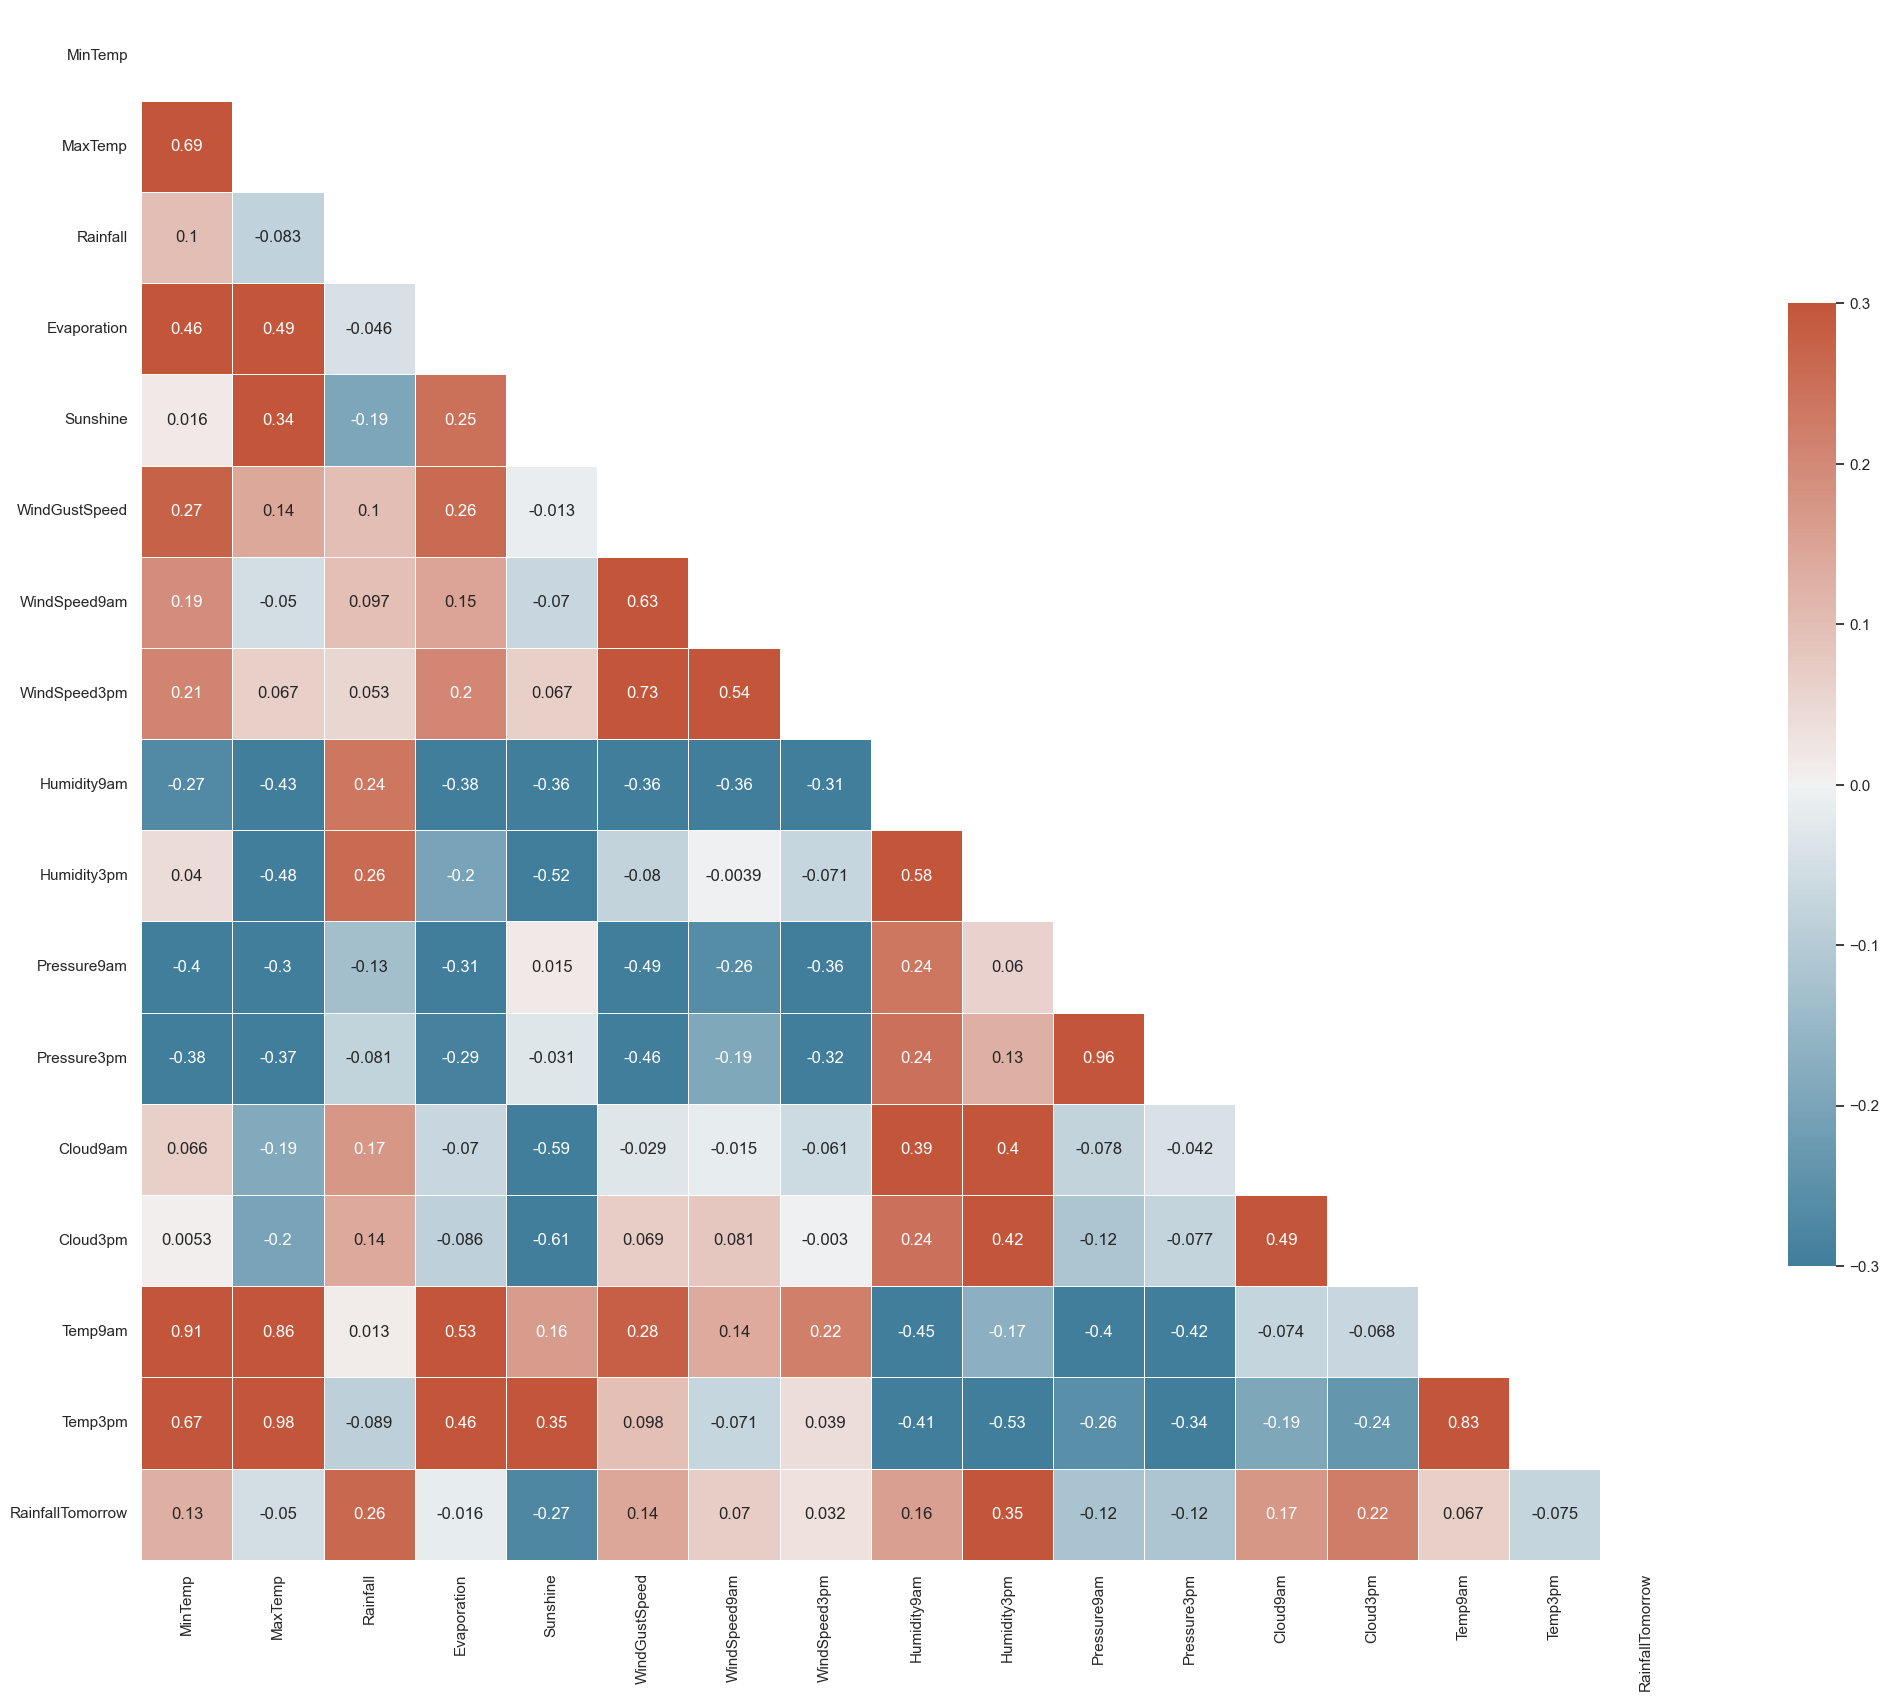

In [69]:
sns.set_theme(style="white")
# Creación de la matriz de correlación
corr = train_dummies[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainfallTomorrow']].corr()

# Generar una máscara para el triángulo superior
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configurar la figura de matplotlib
f, ax = plt.subplots(figsize=(25, 25))

# Generar un colormap diverging personalizado
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Dibujar el heatmap con la máscara y el aspecto correcto
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-.3 ,vmax=.3,center=0, square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()



Las variables climáticas más relevantes que parecen influir en la probabilidad de lluvia mañana (RainTomorrow) son la cantidad de lluvia (Rainfall) con un coeficiente de 0.26, la velocidad de ráfagas de viento (WindGustSpeed) con 0.14, la humedad a las 3 p.m. (Humidity3pm) con 0.35, la humedad a las 9 a.m. (Humidity9am) con 0.16, la cobertura de nubes a las 9 a.m. (Cloud9am) con 0.17, y la cobertura de nubes a las 3 p.m. (Cloud3pm) con 0.22.


## Matriz de correlación categórica

### Train

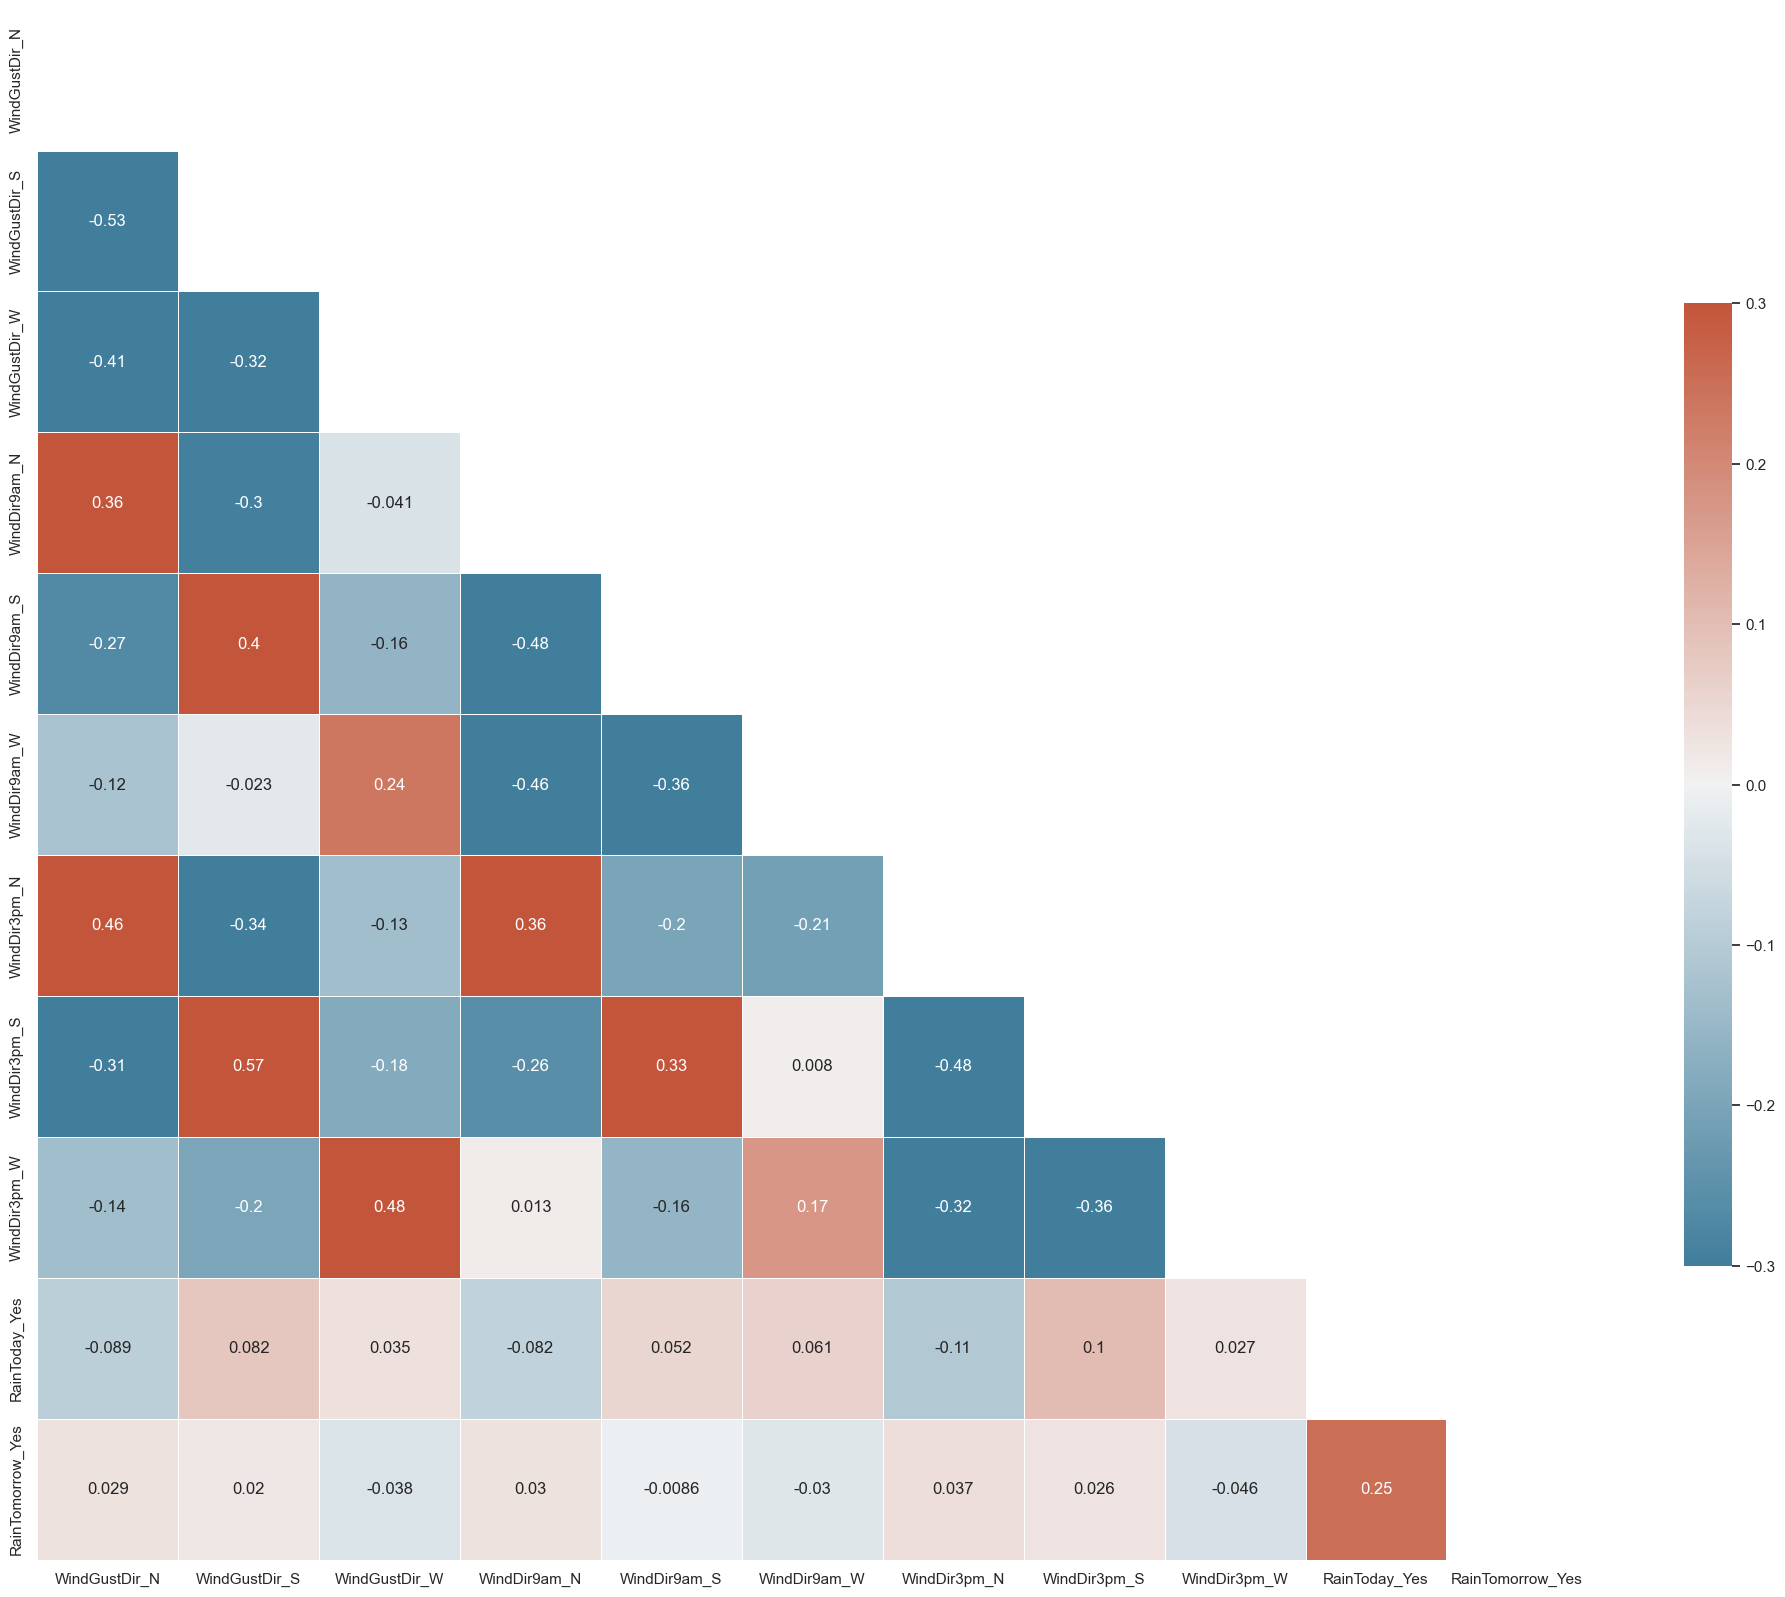

In [70]:
sns.set_theme(style="white")

# Calcular la matriz de correlación
corr = train_dummies[['WindGustDir_N', 'WindGustDir_S', 'WindGustDir_W', 'WindDir9am_N', 'WindDir9am_S', 'WindDir9am_W', 'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_W', 'RainToday_Yes', 'RainTomorrow_Yes']].corr()

# Generar una máscara para el triángulo superior
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configurar la figura de matplotlib
f, ax = plt.subplots(figsize=(25, 25))

# Generar un colormap diverging personalizado
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Dibujar el heatmap con la máscara y el aspecto correcto
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-.3 ,vmax=.3, center=0, square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()


En la matriz de correlación categórica, las variables climáticas más relevantes que parecen influir en la probabilidad de lluvia mañana (RainTomorrow) son raintoday_yes con un coeficiente de 0.25. 

Las demás variables, como WindGustDir_N, WindGustDir_S, WindGustDir_W, WindDir9am_N, WindDir9am_S, WindDir9am_W, WindDir3pm_N, WindDir3pm_S y WindDir3pm_W, tienen una influencia menor.

# División del conjunto de datos de entrenamiento


**y_train & y_proces:**
- Elimina las características especificadas de train_processed para de esta forma solo quedarnos con nuestro variable target "RainTomorrow".

**x_train & x_proces:**
- Elimina "RainTomorrow" para de esta forma solo quedarnos con las características que serán utilizadas para predecir la variable “RainTomorrow”.

In [71]:
# Train
y_train = train.drop(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainfallTomorrow'], axis=1)
x_train = train_dummies.drop([ 'RainfallTomorrow', 'RainTomorrow_Yes'], axis=1)

# Test
y_test = test.drop(['MinTemp','MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainfallTomorrow'], axis=1)
x_test = test_dummies.drop(['RainfallTomorrow', 'RainTomorrow_Yes'], axis=1)

In [72]:
y_test

RainTomorrow
2393            No
2394            No
2395            No
2396            No
2397            No
...            ...
70366           No
70367           No
70368           No
70369          Yes
70370           No

[3639 rows x 1 columns]

In [73]:
y_train

RainTomorrow
0               No
1               No
2               No
3               No
4               No
...            ...
69465           No
69466           No
69467          Yes
69468           No
69469           No

[14570 rows x 1 columns]

# Balanceamos los datos:
Realizamos un balanceo de datos en el conjunto de entrenamiento utilizando la técnica SMOTETomek, mientras que mantenemos el conjunto de prueba sin cambios. 

In [74]:
# Aplicar SMOTETomek solo al conjunto de entrenamiento
smote_tomek = SMOTETomek(random_state=42)


if isinstance(y_train, pd.DataFrame):
    y_train = y_train.iloc[:, 0]

X_train_balanced, y_train_balanced = smote_tomek.fit_resample(x_train, y_train)

# El conjunto de prueba se mantiene sin cambios
X_test_balanced, y_test_balanced = x_test, y_test

In [75]:
# Codificar las etiquetas
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_balanced.values.flatten())
y_test_encoded = le.fit_transform(y_test_balanced.values.flatten())

In [76]:
print("X_train_balanced shape:", X_train_balanced.shape)
print("y_train_encoded shape:", y_train_balanced.shape)


X_train_balanced shape: (22334, 26)
y_train_encoded shape: (22334,)


In [77]:
print("Distribución original:")
print(y_train.value_counts(normalize=True))

print("\nDistribución después del balanceo:")
print(pd.Series(y_train_encoded).value_counts(normalize=True))

Distribución original:
RainTomorrow
No     0.770968
Yes    0.229032
Name: proportion, dtype: float64

Distribución después del balanceo:
0    0.5
1    0.5
Name: proportion, dtype: float64


In [78]:
y_train_encoded.shape

(22334,)

In [79]:
X_train_balanced

MinTemp   MaxTemp  Rainfall   Evaporation      Sunshine  \
0      0.395411  0.199145 -0.224724  3.370918e-16 -2.676527e-16   
1     -0.609240  0.548666 -0.308589  3.370918e-16 -2.676527e-16   
2      0.311690  0.643990 -0.308589  3.370918e-16 -2.676527e-16   
3     -0.307845  1.009398 -0.308589  3.370918e-16 -2.676527e-16   
4      1.081922  1.692552 -0.168814  3.370918e-16 -2.676527e-16   
...         ...       ...       ...           ...           ...   
22329  1.253142  0.961976  0.038012 -9.251365e-01 -8.529762e-02   
22330  1.247258 -0.169824  0.152129 -1.246056e+00 -2.063630e+00   
22331  1.174135  1.331234 -0.308589  2.374668e+00  2.100614e-01   
22332 -1.487125 -1.473685 -0.300839 -7.103185e-01 -2.676527e-16   
22333 -0.992566 -0.348420 -0.294718 -1.063862e-01 -4.320347e-02   

       WindGustSpeed  WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  \
0           0.096538      0.448233  3.468381e-01     0.070741    -1.593170   
1           0.096538     -1.093962  1.380351e-01    -1.613606    -1.426583   
2           0.232217      0.351845  5.556410e-01    -1.987906    -1.148938   
3          -1.260252     -0.419252 -1.219184e+00    -1.551223    -1.926344   
4          -0.106981     -0.804800 -7.076780e-02     0.756956    -0.982351   
...              ...           ...           ...          ...          ...   
22329       0.313829      0.678690  1.412835e+00     0.195507     0.395018   
22330      -0.477690      0.387135 -5.927751e-01     0.892288     2.292337   
22331       1.675802      1.219330  1.242693e+00    -0.642995    -0.474832   
22332       0.000000      0.000000  3.709085e-16    -0.479517     2.009874   
22333       0.014240     -0.417779 -3.823772e-01     0.069788     0.045571   

       ...  WindGustDir_N  WindGustDir_S  WindGustDir_W  WindDir9am_N  \
0      ...              0              0              1             0   
1      ...              0              0              1             1   
2      ...              0              0              1             0   
3      ...              1              0              0             0   
4      ...              0              0              1             0   
...    ...            ...            ...            ...           ...   
22329  ...              1              0              0             1   
22330  ...              1              0              0             1   
22331  ...              1              0              0             1   
22332  ...              1              0              0             1   
22333  ...              1              0              0             0   

       WindDir9am_S  WindDir9am_W  WindDir3pm_N  WindDir3pm_S  WindDir3pm_W  \
0                 0             1             0             0             1   
1                 0             0             0             0             1   
2                 0             1             0             0             1   
3                 1             0             0             0             0   
4                 0             0             1             0             0   
...             ...           ...           ...           ...           ...   
22329             0             0             1             0             0   
22330             0             0             1             0             0   
22331             0             0             1             0             0   
22332             0             0             0             1             0   
22333             0             0             0             0             0   

       RainToday_Yes  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
22329              1  
22330              0  
22331              0  
22332              0  
22333              0  

[22334 rows x 26 columns]

In [80]:
y_test_encoded.shape

(3639,)

# Regresión Lineal

La regresión lineal modela una relación lineal entre la variable dependiente y las variables independientes.

In [81]:
# Crea una instancia del modelo de regresión lineal
model_rl = LinearRegression()
model_rl.fit(X_train_balanced, y_train_encoded)

LinearRegression()

In [82]:
y_train_pred = model_rl.predict(X_train_balanced)
y_pred = model_rl.predict(x_test)

#### Coeficiente e Intercepción

In [83]:
coefficients = model_rl.coef_
intercept = model_rl.intercept_
print("Coefficients:", coefficients)
print(f"\nIntercept:", intercept)

Coefficients: [ 0.01007017 -0.05934395  0.01172437 -0.00901543 -0.07799351  0.11561588
 -0.0017746  -0.01448444  0.01141642  0.15697441  0.09652106 -0.17177587
 -0.01641482  0.0663189  -0.03764781  0.08421446 -0.12712286 -0.12287245
 -0.15989548 -0.1347043  -0.17485555 -0.14171847 -0.06308251 -0.02433141
 -0.0975804   0.0023822 ]

Intercept: 0.6795831820387772


Los coeficientes de la regresión lineal representan el cambio esperado en la variable dependiente por cada unidad de cambio en la variable independiente, manteniendo todas las demás variables constantes.

- Intercepto: 0.679

Este es el valor predicho de RainTomorrow cuando todas las variables independientes son 0.

- Coeficientes:

Cada coeficiente representa la influencia de una variable independiente en la variable dependiente RainTomorrow.

#### Métricas del set de entrenamiento

In [84]:
# MSE: Error Cuadratico Medio
mse_train = mean_squared_error(y_train_encoded, y_train_pred)

# R^2
r2_train = r2_score(y_train_encoded, y_train_pred)

# MAE: Error Absoluto Medio
mae_train = mean_absolute_error(y_train_encoded, y_train_pred)

# RMSE: Raíz del Error Cuadrático Medio
rmse_train = np.sqrt(mean_squared_error(y_train_encoded, y_train_pred))

print(f"\nR²: {r2_train}\n")
print(f"MSE(Error Cuadratico Medio): {mse_train}\n")
print(f"MAE(Error Absoluto Medio): {mae_train}\n")
print(f"RMSE(Raíz del Error Cuadrático Medio): {rmse_train}\n")


R²: 0.40746369750981604

MSE(Error Cuadratico Medio): 0.148134075622546

MAE(Error Absoluto Medio): 0.3192769781973435

RMSE(Raíz del Error Cuadrático Medio): 0.3848818982786096



#### Métricas del set de testeo

In [85]:
# MSE: Error Cuadratico Medio
mse = mean_squared_error(y_test_encoded, y_pred)

# R^2
r2 = r2_score(y_test_encoded, y_pred)

# MAE: Error Absoluto Medio
mae = mean_absolute_error(y_test_encoded, y_pred)

# RMSE: Raíz del Error Cuadrático Medio
rmse = np.sqrt(mean_squared_error(y_test_encoded, y_pred))

print(f"\nR²: {r2}\n")
print(f"MSE(Error Cuadratico Medio): {mse}\n")
print(f"MAE(Error Absoluto Medio): {mae}\n")
print(f"RMSE(Raíz del Error Cuadrático Medio): {rmse}\n")


R²: 0.1777459605476298

MSE(Error Cuadratico Medio): 0.1455027761886345

MAE(Error Absoluto Medio): 0.3148912761571897

RMSE(Raíz del Error Cuadrático Medio): 0.38144826148330324



### Conlcusión
 
 ***Muestra un rendimiento deficiente para un problema de clasificación, y las métricas de error indican que no es una buena opción para predecir variables categóricas en este caso.***
 
- Moderado Ajuste: El modelo tiene un ajuste moderado con los datos de entrenamiento, explicando aproximadamente el 40.7% de la variabilidad.
- Generalización Mejorable: La diferencia en R² entre los conjuntos de entrenamiento (40,7%) y prueba (17,7%) sugiere que el modelo podría estar sobreajustado a los datos de entrenamiento y no generaliza bien a datos nuevos.
- Errores Significativos: Las métricas de error (MSE, MAE, RMSE) indican que hay errores significativos en las predicciones tanto en el conjunto de entrenamiento como en el de prueba.

## Gradiente descendiente

In [86]:
# Regresión lineal utilizando SGDRegressor
model_sgd = SGDRegressor(max_iter=1000, tol=1e-3)
model_sgd.fit(X_train_balanced, y_train_encoded.ravel())


SGDRegressor()

In [87]:
y_pred_sgd = model_sgd.predict(X_test_balanced)

In [88]:
y_train_pred_sgd = model_sgd.predict(X_train_balanced)

- Definimos y entrenamos un modelo de regresión lineal usando descenso de gradiente estocástico.
- Hicimos predicciones tanto en los datos de entrenamiento como en los de prueba para evaluar el rendimiento del modelo.

Este enfoque ayuda a encontrar la mejor línea de ajuste para los datos de entrenamiento, y las predicciones en los datos de prueba nos permiten evaluar la capacidad del modelo para generalizar a nuevos datos.

#### Coeficiente e Intercepción

In [89]:
coefficients_sgd = model_sgd.coef_
intercept_sgd = model_sgd.intercept_
print("Coefficients (SGD):", coefficients_sgd)
print(f"\nIntercept (SGD):", intercept_sgd)

Coefficients (SGD): [ 0.00101795 -0.05372094  0.01852165 -0.00785802 -0.08455947  0.10976362
 -0.01008487 -0.01498208  0.01562213  0.15308513  0.10194653 -0.16308459
 -0.01623381  0.06763049 -0.03699078  0.06233103 -0.12952068 -0.11394608
 -0.15217133 -0.13410374 -0.16906442 -0.12422225 -0.06515148 -0.02362349
 -0.09650413  0.00304368]

Intercept (SGD): [0.66319592]


#### Métricas del set de entrenamiento

In [90]:
# MSE: Error Cuadratico Medio
mse_train_sgd = mean_squared_error(y_train_encoded, y_train_pred_sgd)

# R^2
r2_train_sgd = r2_score(y_train_encoded, y_train_pred_sgd)

# MAE: Error Absoluto Medio
mae_train_sgd = mean_absolute_error(y_train_encoded, y_train_pred_sgd)

# RMSE: Raíz del Error Cuadrático Medio
rmse_train_sgd = np.sqrt(mean_squared_error(y_train_encoded, y_train_pred_sgd))

print(f"\nR²: {r2_train_sgd}\n")
print(f"MSE(Error Cuadratico Medio): {mse_train_sgd}\n")
print(f"MAE(Error Absoluto Medio): {mae_train_sgd}\n")
print(f"RMSE(Raíz del Error Cuadrático Medio): {rmse_train_sgd}\n")


R²: 0.4009284782306737

MSE(Error Cuadratico Medio): 0.14976788044233158

MAE(Error Absoluto Medio): 0.3203615426339662

RMSE(Raíz del Error Cuadrático Medio): 0.3869985535403609



#### Métricas del set de testeo

In [91]:
# MSE: Error Cuadrático Medio
mse_sgd = mean_squared_error(y_test_encoded, y_pred_sgd)

# R^2
r2_sgd = r2_score(y_test_encoded, y_pred_sgd)

# MAE: Error Absoluto Medio
mae_sgd = mean_absolute_error(y_test_encoded, y_pred_sgd)

# RMSE: Raíz del Error Cuadrático Medio
rmse_sgd = np.sqrt(mse_sgd)

print(f"\nR² (SGD): {r2_sgd}\n")
print(f"MSE (SGD): {mse_sgd}\n")
print(f"MAE (SGD): {mae_sgd}\n")
print(f"RMSE (SGD): {rmse_sgd}\n")


R² (SGD): 0.18250386354742631

MSE (SGD): 0.1446608367610487

MAE (SGD): 0.31144068455716717

RMSE (SGD): 0.3803430514168081



El modelo de regresión lineal utilizando gradiente descendiente (SGDRegressor) parece estar ajustando de manera razonable el conjunto de entrenamiento, pero tiene dificultades para generalizar en el conjunto de prueba. Esto se refleja en un valor significativamente menor de R² en el conjunto de prueba. 

# Lasso, Ridge y Elastic Net

## Lasso

Penaliza la suma de los valores absolutos de los coeficientes, lo que puede llevar a algunos coeficientes a ser exactamente cero. Esto es útil para la selección de variables, ya que permite identificar las características más importantes.

In [92]:
lasso = Lasso(alpha=0.1) # alpha controla la fuerza de la regularización L1 (Lasso)
lasso.fit(X_train_balanced, y_train_encoded)

Lasso(alpha=0.1)

In [93]:
print("Coeficientes del modelo Lasso:")
print(lasso.coef_)
print("\nCoeficientes del modelo Lasso de train:", lasso.score(X_train_balanced, y_train_encoded))
print("Coeficientes del modelo Lasso de test:", lasso.score(X_test_balanced, y_test_encoded))

Coeficientes del modelo Lasso:
[ 0.         -0.          0.          0.         -0.04820675  0.00848401
  0.          0.          0.          0.10641016 -0.         -0.01271757
  0.          0.01771881  0.         -0.          0.         -0.
 -0.          0.         -0.         -0.          0.         -0.
 -0.          0.        ]

Coeficientes del modelo Lasso de train: 0.2573672607459717
Coeficientes del modelo Lasso de test: -0.044013022601655294


El modelo Lasso realizo la regularización añadiendo una penalización basada en la magnitud de los coeficientes, lo que resulto que algunos coeficientes se reduzcan exactamente a cero. Esta característica es útil para la selección de variables, ya que permite identificar y descartar variables irrelevantes.

- Muchos coeficientes son exactamente 0, lo que significa que estas variables han sido eliminadas del modelo.
- Los coeficientes significativos (diferentes de cero) incluyen en que solo unas pocas variables tienen una influencia significativa en el modelo después de la regularización Lasso.


In [94]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import numpy as np

# Primero, haz predicciones en los conjuntos de entrenamiento y prueba
y_pred_train_lasso = lasso.predict(X_train_balanced)
y_pred_test_lasso = lasso.predict(X_test_balanced)

# Error Cuadrático Medio (MSE)
mse_train_lasso = mean_squared_error(y_train_encoded, y_pred_train_lasso)
mse_test_lasso = mean_squared_error(y_test_encoded, y_pred_test_lasso)

# Raíz del Error Cuadrático Medio (RMSE)
rmse_train_lasso = sqrt(mse_train_lasso)
rmse_test_lasso = sqrt(mse_test_lasso)

# Error Absoluto Medio (MAE)
mae_train_lasso = mean_absolute_error(y_train_encoded, y_pred_train_lasso)
mae_test_lasso = mean_absolute_error(y_test_encoded, y_pred_test_lasso)

# Coeficiente de determinación (R²)
r2_train_lasso = r2_score(y_train_encoded, y_pred_train_lasso)
r2_test_lasso = r2_score(y_test_encoded, y_pred_test_lasso)

# Imprimir resultados
print("Métricas para el modelo Lasso:")
print("\nConjunto de entrenamiento:")
print(f"MSE: {mse_train_lasso:.4f}")
print(f"RMSE: {rmse_train_lasso:.4f}")
print(f"MAE: {mae_train_lasso:.4f}")
print(f"R²: {r2_train_lasso:.4f}")

print("\nConjunto de prueba:")
print(f"MSE: {mse_test_lasso:.4f}")
print(f"RMSE: {rmse_test_lasso:.4f}")
print(f"MAE: {mae_test_lasso:.4f}")
print(f"R²: {r2_test_lasso:.4f}")

# Coeficientes del modelo
print("\nCoeficientes del modelo Lasso:")
if lasso.coef_.ndim == 1:
    for feature, coef in zip(X_train_balanced.columns, lasso.coef_):
        if abs(coef) > 1e-5:  # Mostrar solo coeficientes no nulos
            print(f"{feature}: {coef:.4f}")
else:
    for i, (feature, coef) in enumerate(zip(X_train_balanced.columns, lasso.coef_[0])):
        if abs(coef) > 1e-5:  # Mostrar solo coeficientes no nulos
            print(f"{feature}: {coef:.4f}")

# Intercept (término independiente)
if np.isscalar(lasso.intercept_):
    print(f"\nIntercept: {lasso.intercept_:.4f}")
else:
    print(f"\nIntercept: {lasso.intercept_[0]:.4f}")

# Número de coeficientes no nulos
non_zero_coef = np.sum(np.abs(lasso.coef_) > 1e-5)
print(f"\nNúmero de características seleccionadas: {non_zero_coef}")

Métricas para el modelo Lasso:

Conjunto de entrenamiento:
MSE: 0.1857
RMSE: 0.4309
MAE: 0.4100
R²: 0.2574

Conjunto de prueba:
MSE: 0.1847
RMSE: 0.4298
MAE: 0.4107
R²: -0.0440

Coeficientes del modelo Lasso:
Sunshine: -0.0482
WindGustSpeed: 0.0085
Humidity3pm: 0.1064
Pressure3pm: -0.0127
Cloud3pm: 0.0177

Intercept: 0.4508

Número de características seleccionadas: 5


### Conclusión

El modelo Lasso ha mostrado un desempeño moderado en el conjunto de entrenamiento, con un R² de 0.2574, indicando que el 25,7% de la variabilidad en la variable dependiente es explicada por el modelo. En el conjunto de prueba, el R² es negativo (-0.0440), lo cual es un mal indicador. Un R² negativo significa que el modelo está peor que un modelo trivial que predice el valor promedio de la variable objetivo para todos los datos. Esto sugiere que el modelo no generaliza bien a nuevos datos.Errores de MSE, RMSE y MAE que indican un ajuste aceptable. 

El modelo seleccionó 5 características relevantes: Sunshine, WindGustSpeed, Humidity3pm, Cloud3pm, y Pressure3pm, y redujo muchos coeficientes a cero, demostrando su capacidad para realizar selección de variables. El rendimiento general indica que podría haber problemas de sobreajuste o falta de ajuste en datos no vistos.

## Ridge

In [95]:
ridge = Ridge(alpha=0.1) # alpha controla la fuerza de la regularización L2 (Ridge)
ridge.fit(X_train_balanced, y_train_encoded)

Ridge(alpha=0.1)

In [96]:
print("Coeficientes del modelo Ridge:")
print(ridge.coef_)
print("\nCoeficientes del modelo Ridge de train:", ridge.score(X_train_balanced, y_train_encoded))
print("Coeficientes del modelo Ridge de test:", ridge.score(X_test_balanced, y_test_encoded))

Coeficientes del modelo Ridge:
[ 0.01006664 -0.05932428  0.01172483 -0.00901602 -0.07799395  0.11561334
 -0.00177522 -0.01448453  0.01142049  0.15696982  0.09650219 -0.17175662
 -0.01641375  0.06631816 -0.03763849  0.084191   -0.12711156 -0.12286176
 -0.15988313 -0.13469098 -0.17484072 -0.14170411 -0.06307787 -0.02433584
 -0.09758131  0.00238047]

Coeficientes del modelo Ridge de train: 0.4074636971356774
Coeficientes del modelo Ridge de test: 0.17774518362612513


En el conjunto de entrenamiento, el R² de 0.4074 indica que el modelo explica aproximadamente el 40,7% de la variabilidad en la variable dependiente, lo que sugiere un buen ajuste a los datos. En el conjunto de prueba, el R² de 0.1777 es menor, lo que muestra un rendimiento moderado en datos no vistos y puede indicar problemas de sobreajuste o necesidad de ajustes adicionales.

In [97]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import numpy as np

# Primero, haz predicciones en los conjuntos de entrenamiento y prueba
y_pred_train_ridge = ridge.predict(X_train_balanced)
y_pred_test_ridge = ridge.predict(X_test_balanced)

# Error Cuadrático Medio (MSE)
mse_train_ridge = mean_squared_error(y_train_encoded, y_pred_train_ridge)
mse_test_ridge = mean_squared_error(y_test_encoded, y_pred_test_ridge)

# Raíz del Error Cuadrático Medio (RMSE)
rmse_train_ridge = sqrt(mse_train_ridge)
rmse_test_ridge = sqrt(mse_test_ridge)

# Error Absoluto Medio (MAE)
mae_train_ridge = mean_absolute_error(y_train_encoded, y_pred_train_ridge)
mae_test_ridge = mean_absolute_error(y_test_encoded, y_pred_test_ridge)

# Coeficiente de determinación (R²)
r2_train_ridge = r2_score(y_train_encoded, y_pred_train_ridge)
r2_test_ridge = r2_score(y_test_encoded, y_pred_test_ridge)

# Imprimir resultados
print("Métricas para el modelo Ridge:")
print("\nConjunto de entrenamiento:")
print(f"MSE: {mse_train_ridge:.4f}")
print(f"RMSE: {rmse_train_ridge:.4f}")
print(f"MAE: {mae_train_ridge:.4f}")
print(f"R²: {r2_train_ridge:.4f}")

print("\nConjunto de prueba:")
print(f"MSE: {mse_test_ridge:.4f}")
print(f"RMSE: {rmse_test_ridge:.4f}")
print(f"MAE: {mae_test_ridge:.4f}")
print(f"R²: {r2_test_ridge:.4f}")

# Coeficientes del modelo
print("\nCoeficientes del modelo Ridge:")
if ridge.coef_.ndim == 1:
    for feature, coef in zip(X_train_balanced.columns, ridge.coef_):
        print(f"{feature}: {coef:.4f}")
else:
    for i, (feature, coef) in enumerate(zip(X_train_balanced.columns, ridge.coef_[0])):
        print(f"{feature}: {coef:.4f}")

# Intercept (término independiente)
if np.isscalar(ridge.intercept_):
    print(f"\nIntercept: {ridge.intercept_:.4f}")
else:
    print(f"\nIntercept: {ridge.intercept_[0]:.4f}")

Métricas para el modelo Ridge:

Conjunto de entrenamiento:
MSE: 0.1481
RMSE: 0.3849
MAE: 0.3193
R²: 0.4075

Conjunto de prueba:
MSE: 0.1455
RMSE: 0.3814
MAE: 0.3149
R²: 0.1777

Coeficientes del modelo Ridge:
MinTemp: 0.0101
MaxTemp: -0.0593
Rainfall: 0.0117
Evaporation: -0.0090
Sunshine: -0.0780
WindGustSpeed: 0.1156
WindSpeed9am: -0.0018
WindSpeed3pm: -0.0145
Humidity9am: 0.0114
Humidity3pm: 0.1570
Pressure9am: 0.0965
Pressure3pm: -0.1718
Cloud9am: -0.0164
Cloud3pm: 0.0663
Temp9am: -0.0376
Temp3pm: 0.0842
WindGustDir_N: -0.1271
WindGustDir_S: -0.1229
WindGustDir_W: -0.1599
WindDir9am_N: -0.1347
WindDir9am_S: -0.1748
WindDir9am_W: -0.1417
WindDir3pm_N: -0.0631
WindDir3pm_S: -0.0243
WindDir3pm_W: -0.0976
RainToday_Yes: 0.0024

Intercept: 0.6796


- El modelo Ridge parece tener una mejor capacidad de generalización en comparación con el modelo Lasso, dado que su R² en el conjunto de prueba es positivo (aunque no muy alto). Esto sugiere que el modelo es más robusto al conjunto de prueba.

- Los coeficientes indican qué características son las más influyentes. El hecho de que características como WindGustSpeed, Humidity3pm, y Pressure3pm tengan coeficientes significativos muestra que estos factores tienen un impacto importante en la predicción de la variable objetivo.

## Elastic Net

In [98]:
elasticnet = ElasticNet(alpha=0.1, l1_ratio=0.5)
elasticnet.fit(X_train_balanced, y_train_encoded)

ElasticNet(alpha=0.1)

In [99]:
print("Coeficientes del modelo ElasticNet:")
print(elasticnet.coef_)
print("\nCoeficientes del modelo ElasticNet de train:", elasticnet.score(X_train_balanced, y_train_encoded))
print("Coeficientes del modelo ElasticNet de test:", elasticnet.score(X_test_balanced, y_test_encoded))

Coeficientes del modelo ElasticNet:
[ 0.          0.          0.         -0.         -0.06364669  0.03931649
  0.          0.          0.          0.12921656 -0.         -0.0449348
  0.          0.04001641  0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.          0.         -0.
 -0.          0.        ]

Coeficientes del modelo ElasticNet de train: 0.3330206140310271
Coeficientes del modelo ElasticNet de test: 0.07575008996919763


- Entrenamiento: R² = 0.333
- Prueba: R² = 0.0757



In [100]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

# Primero, haz predicciones en los conjuntos de entrenamiento y prueba
y_pred_train = elasticnet.predict(X_train_balanced)
y_pred_test = elasticnet.predict(X_test_balanced)

# Error Cuadrático Medio (MSE)
mse_train = mean_squared_error(y_train_encoded, y_pred_train)
mse_test = mean_squared_error(y_test_encoded, y_pred_test)

# Raíz del Error Cuadrático Medio (RMSE)
rmse_train = sqrt(mse_train)
rmse_test = sqrt(mse_test)

# Error Absoluto Medio (MAE)
mae_train = mean_absolute_error(y_train_encoded, y_pred_train)
mae_test = mean_absolute_error(y_test_encoded, y_pred_test)

# Coeficiente de determinación (R²)
r2_train = r2_score(y_train_encoded, y_pred_train)
r2_test = r2_score(y_test_encoded, y_pred_test)

# Imprimir resultados
print("Métricas para el modelo ElasticNet:")
print("\nConjunto de entrenamiento:")
print(f"MSE: {mse_train:.4f}")
print(f"RMSE: {rmse_train:.4f}")
print(f"MAE: {mae_train:.4f}")
print(f"R²: {r2_train:.4f}")

print("\nConjunto de prueba:")
print(f"MSE: {mse_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")
print(f"MAE: {mae_test:.4f}")
print(f"R²: {r2_test:.4f}")

# Coeficientes del modelo
print("\nCoeficientes del modelo ElasticNet:")
for feature, coef in zip(X_train_balanced.columns, elasticnet.coef_):
    print(f"{feature}: {coef:.4f}")

Métricas para el modelo ElasticNet:

Conjunto de entrenamiento:
MSE: 0.1667
RMSE: 0.4083
MAE: 0.3682
R²: 0.3330

Conjunto de prueba:
MSE: 0.1636
RMSE: 0.4044
MAE: 0.3670
R²: 0.0758

Coeficientes del modelo ElasticNet:
MinTemp: 0.0000
MaxTemp: 0.0000
Rainfall: 0.0000
Evaporation: -0.0000
Sunshine: -0.0636
WindGustSpeed: 0.0393
WindSpeed9am: 0.0000
WindSpeed3pm: 0.0000
Humidity9am: 0.0000
Humidity3pm: 0.1292
Pressure9am: -0.0000
Pressure3pm: -0.0449
Cloud9am: 0.0000
Cloud3pm: 0.0400
Temp9am: 0.0000
Temp3pm: -0.0000
WindGustDir_N: -0.0000
WindGustDir_S: -0.0000
WindGustDir_W: -0.0000
WindDir9am_N: -0.0000
WindDir9am_S: -0.0000
WindDir9am_W: -0.0000
WindDir3pm_N: 0.0000
WindDir3pm_S: -0.0000
WindDir3pm_W: -0.0000
RainToday_Yes: 0.0000


- Entrenamiento: El modelo ElasticNet ha capturado aproximadamente el 33.30% de la variabilidad en los datos de entrenamiento. El RMSE y MAE son relativamente bajos, lo que indica un ajuste razonable al conjunto de entrenamiento.

- Prueba: El modelo ha capturado solo el 7.58% de la variabilidad en los datos de prueba, lo que sugiere que no está generalizando bien. La diferencia significativa entre el R² del entrenamiento y el R² del conjunto de prueba puede ser indicativa de sobreajuste.

El rendimiento significativamente menor en el conjunto de prueba indica que el modelo podría no estar generalizando bien, lo que podría sugerir un ajuste adicional de los hiperparámetros del ElasticNet (por ejemplo, los coeficientes de regularización l1_ratio y alpha).

Hice cambios en los mismos y los resultados eran similares y practicamente iguales por lo que decidi dejarlos con esos valores.

## Gráfico comparativo

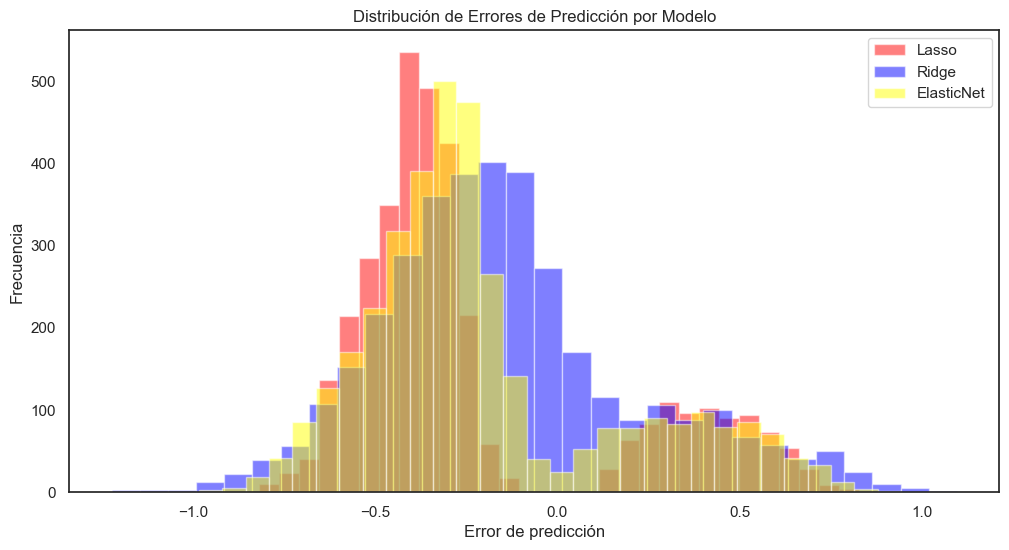

In [101]:
plt.figure(figsize=(12, 6))

plt.hist(y_test_encoded - lasso.predict(X_test_balanced), bins=30, alpha=0.5, label='Lasso', color='red')
plt.hist(y_test_encoded - ridge.predict(X_test_balanced), bins=30, alpha=0.5, label='Ridge', color='blue')
plt.hist(y_test_encoded - elasticnet.predict(X_test_balanced), bins=30, alpha=0.5, label='ElasticNet', color='yellow')

plt.xlabel('Error de predicción')
plt.ylabel('Frecuencia')
plt.title('Distribución de Errores de Predicción por Modelo')
plt.legend()
plt.show()




**Este gráfico muestra la distribución de los errores de predicción de tres modelos de regresión lineal regularizada: Lasso, Ridge y ElasticNet.**

- Lasso parece ser el modelo que produce errores más pequeños en general, pero a costa de subestimaciones sistemáticas.
- Ridge muestra un rendimiento más equilibrado con errores que están más centrados en torno a 0, aunque con mayor dispersión, lo que sugiere una capacidad de generalización ligeramente mejor.
- ElasticNet está entre ambos, con características de ambos métodos de regularización, ofreciendo un compromiso entre la concentración de errores y la dispersión.

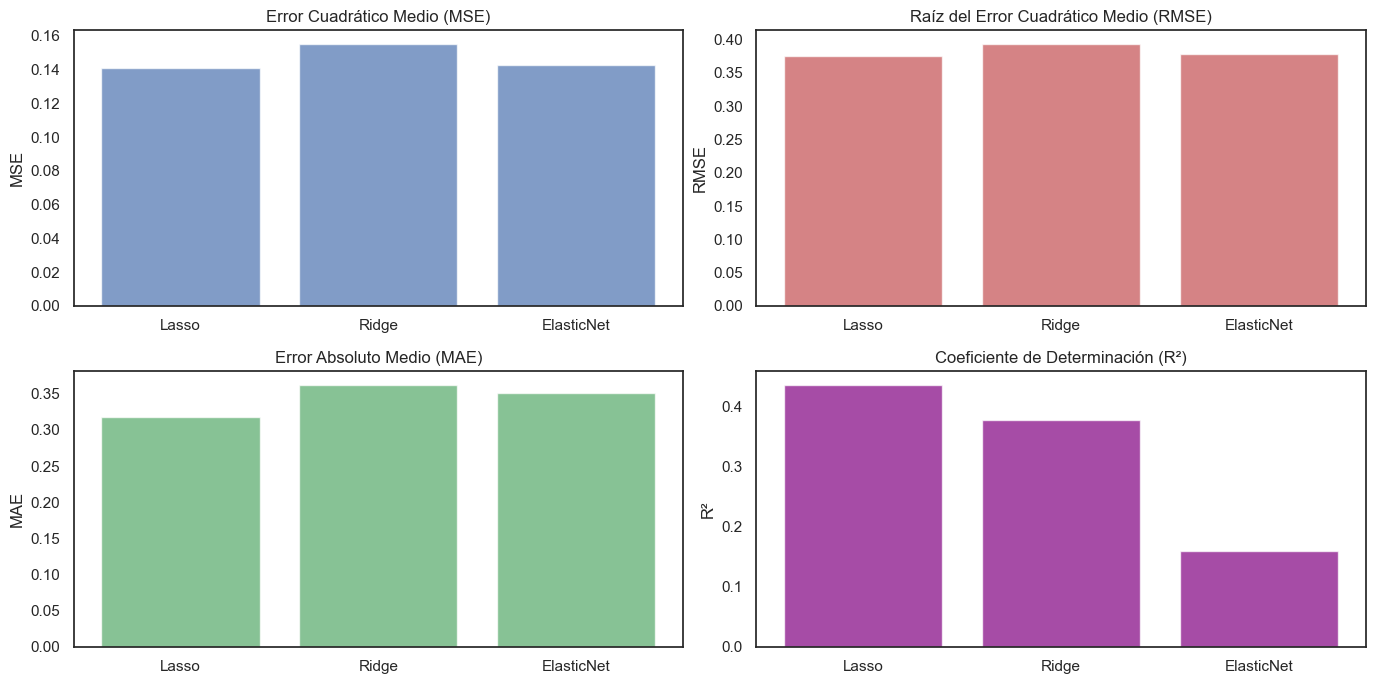

In [102]:
import matplotlib.pyplot as plt

# Supongamos que tienes los datos de métricas en listas
model_names = ['Lasso', 'Ridge', 'ElasticNet']
mse_values = [0.1408, 0.1555, 0.1428]
rmse_values = [0.3752, 0.3943, 0.3779]
mae_values = [0.3175, 0.3627, 0.3512]
r2_values = [0.4368, 0.3780, 0.1592]

x = range(len(model_names))

plt.figure(figsize=(14, 7))

# Gráfico de MSE
plt.subplot(2, 2, 1)
plt.bar(x, mse_values, color='b', alpha=0.7)
plt.xticks(x, model_names)
plt.ylabel('MSE')
plt.title('Error Cuadrático Medio (MSE)')

# Gráfico de RMSE
plt.subplot(2, 2, 2)
plt.bar(x, rmse_values, color='r', alpha=0.7)
plt.xticks(x, model_names)
plt.ylabel('RMSE')
plt.title('Raíz del Error Cuadrático Medio (RMSE)')

# Gráfico de MAE
plt.subplot(2, 2, 3)
plt.bar(x, mae_values, color='g', alpha=0.7)
plt.xticks(x, model_names)
plt.ylabel('MAE')
plt.title('Error Absoluto Medio (MAE)')

# Gráfico de R²
plt.subplot(2, 2, 4)
plt.bar(x, r2_values, color='purple', alpha=0.7)
plt.xticks(x, model_names)
plt.ylabel('R²')
plt.title('Coeficiente de Determinación (R²)')

plt.tight_layout()
plt.show()


- Lasso sobresale en cuanto a minimizar los errores (MSE, RMSE, y MAE) pero a costa de explicar menos variabilidad en los datos.
- Ridge captura mejor la estructura de los datos (R² más alto) pero con un mayor costo en términos de error.
- ElasticNet ofrece un rendimiento intermedio, combinando características de ambos Lasso y Ridge, pero no es el mejor en ninguna de las métricas individuales.

**Ridge podría ser la mejor opción debido a su capacidad para capturar más variabilidad en los datos, a pesar de su ligero aumento en el error de predicción**
    

# Regresión Logística (Clasificación).


Predice probabilidades de pertenencia a una clase categórica.

In [103]:
# Inicializar y entrenar un modelo de regresión logística
model_c = LogisticRegression()
start = time.time()
model_c.fit(X_train_balanced, np.ravel(y_train_balanced))
end = time.time()

no_opt_time = end - start

# Realizar predicciones en el conjunto de prueba
y_pred_train = model_c.predict(X_train_balanced)
y_pred_test = model_c.predict(X_test_balanced)
model_c

LogisticRegression()

In [104]:
# Calcular métricas
accuracy_logreg = accuracy_score(y_train_balanced, y_pred_train) # compara el valor real y el predicho

confusion_matrix_logreg = confusion_matrix(y_train_balanced, y_pred_train)

classification_report_logreg = classification_report(y_train_balanced, y_pred_train)

# Imprimir métricas
print("Métricas para logreg train:")
print(f'Precisión: {accuracy_logreg}')
print("Matriz de confusión:")
print(confusion_matrix_logreg)
print("Reporte de clasificación:")
print(classification_report_logreg)

Métricas para logreg train:
Precisión: 0.7956031163248858
Matriz de confusión:
[[9000 2167]
 [2398 8769]]
Reporte de clasificación:
              precision    recall  f1-score   support

          No       0.79      0.81      0.80     11167
         Yes       0.80      0.79      0.79     11167

    accuracy                           0.80     22334
   macro avg       0.80      0.80      0.80     22334
weighted avg       0.80      0.80      0.80     22334



In [105]:
# Calcular métricas
accuracy_logreg = accuracy_score(y_test_balanced, y_pred_test)

confusion_matrix_logreg = confusion_matrix(y_test_balanced, y_pred_test)

classification_report_logreg = classification_report(y_test_balanced, y_pred_test)

# Imprimir métricas
print("Métricas para logreg test:")
print(f'Precisión: {accuracy_logreg}')
print("Matriz de confusión:")
print(confusion_matrix_logreg)
print("Reporte de clasificación:")
print(classification_report_logreg)

Métricas para logreg test:
Precisión: 0.8062654575432812
Matriz de confusión:
[[2327  476]
 [ 229  607]]
Reporte de clasificación:
              precision    recall  f1-score   support

          No       0.91      0.83      0.87      2803
         Yes       0.56      0.73      0.63       836

    accuracy                           0.81      3639
   macro avg       0.74      0.78      0.75      3639
weighted avg       0.83      0.81      0.81      3639



El modelo de regresión logística muestra un buen desempeño en el conjunto de entrenamiento, con un F1-Score de 0.79 para la clase 'Yes'. En el conjunto de prueba, la precisión general es de 0.81, pero el F1-Score para la clase 'Yes' baja a 0.63. Esto indica que, aunque el modelo es preciso, tiene dificultades para identificar correctamente las instancias de la clase positiva en datos no vistos.

- El modelo predice mejor los días sin lluvia (F1 = 0.80 en prueba) en comparación con los días con lluvia, incluso después de balancear los datos.

**El F1-Score combina precisión y recall, proporcionando una visión más equilibrada del rendimiento del modelo, especialmente en conjuntos de datos desbalanceados.**

# Curva Roc

C:\Users\brisa\AppData\Local\Temp\ipykernel_22748\481196173.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_test_binary = y_test_balanced.replace({'No': 0, 'Yes': 1})


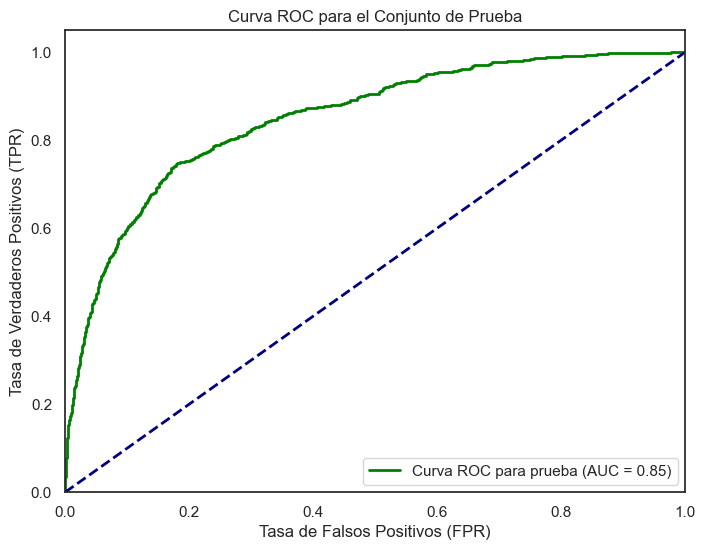

El área bajo la curva para prueba es de: 0.8505796079730022


In [106]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Reemplaza 'No' con 0 y 'Yes' con 1
y_test_binary = y_test_balanced.replace({'No': 0, 'Yes': 1})

# Obtengo las probabilidades de predicción del modelo para los datos de prueba
y_probs_test = model_c.predict_proba(X_test_balanced)[:, 1]

# Calculo la ROC y el AUC para los datos de prueba
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_binary, y_probs_test, pos_label=1)
roc_auc_test = auc(fpr_test, tpr_test)

# Grafico la curva ROC para los datos de prueba
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='green', lw=2, label='Curva ROC para prueba (AUC = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC para el Conjunto de Prueba')
plt.legend(loc="lower right")
plt.show()

print(f"El área bajo la curva para prueba es de: {roc_auc_test}")



In [107]:
# Calcula la distancia euclidiana entre cada punto de la curva ROC y (0,1) para los datos de prueba
distances_test = np.sqrt((1 - tpr_test)**2 + fpr_test**2)

# Encuentra el índice del punto que minimiza la distancia para los datos de prueba
min_index_test = np.argmin(distances_test)

# Obtiene el umbral óptimo para los datos de prueba
optimal_threshold_test = thresholds_test[min_index_test]

print("Umbral óptimo para prueba:", optimal_threshold_test)

Umbral óptimo para prueba: 0.4793036141984684


### Curva ROC, Umbral y Área Bajo la Curva 

AUC: 0.85

Umbral óptimo: 0.479

- La curva ROC muestra que el modelo tiene un desempeño excelente tanto en el conjunto de entrenamiento como en el de prueba, con AUC cercanas a 1. Esto indica que el modelo es muy eficaz para diferenciar entre las clases. 
- Los umbrales óptimos sugieren los puntos donde el modelo equilibra mejor la tasa de verdaderos positivos y la tasa de falsos positivos.

In [108]:
# Guardar el scaler para usarlo en la predicción
import joblib
joblib.dump(model_c, 'ModelRL.joblib')

['ModelRL.joblib']

# Modelos bases.

## Clasificación

In [109]:
# Entrena el modelo base
logreg_base = LogisticRegression()
logreg_base.fit(X_train_balanced, y_train_encoded)

LogisticRegression()

In [110]:

# Realiza predicciones
y_pred_train_base = logreg_base.predict(X_train_balanced)
y_pred_test_base = logreg_base.predict(X_test_balanced)

# Calcula métricas para el conjunto de entrenamiento
print("Métricas de entrenamiento para el modelo base de clasificación:")
print("Precisión:", logreg_base.score(X_train_balanced, y_train_encoded))
print("Matriz de confusión:\n", confusion_matrix(y_train_encoded, y_pred_train_base))
print("Reporte de clasificación:\n", classification_report(y_train_encoded, y_pred_train_base))

# Calcula métricas para el conjunto de prueba
print("Métricas de prueba para el modelo base de clasificación:")
print("Precisión:", logreg_base.score(X_test_balanced, y_test_encoded))
print("Matriz de confusión:\n", confusion_matrix(y_test_encoded, y_pred_test_base))
print("Reporte de clasificación:\n", classification_report(y_test_encoded, y_pred_test_base))


Métricas de entrenamiento para el modelo base de clasificación:
Precisión: 0.7956031163248858
Matriz de confusión:
 [[9000 2167]
 [2398 8769]]
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      0.81      0.80     11167
           1       0.80      0.79      0.79     11167

    accuracy                           0.80     22334
   macro avg       0.80      0.80      0.80     22334
weighted avg       0.80      0.80      0.80     22334

Métricas de prueba para el modelo base de clasificación:
Precisión: 0.8062654575432812
Matriz de confusión:
 [[2327  476]
 [ 229  607]]
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.91      0.83      0.87      2803
           1       0.56      0.73      0.63       836

    accuracy                           0.81      3639
   macro avg       0.74      0.78      0.75      3639
weighted avg       0.83      0.81      0.81      3639



El modelo base de clasificación muestra un rendimiento sólido en el conjunto de entrenamiento, con una precisión de 0.80 y un F1-Score de 0.79 para la clase positiva. En el conjunto de prueba, la precisión se mantiene en 0.81, pero el F1-Score para la clase positiva disminuye a 0.63. Este descenso en el F1-Score sugiere que el modelo tiene dificultades para identificar correctamente las instancias positivas en datos no vistos.

In [111]:
# Guardar el scaler para usarlo en la predicción
import joblib
joblib.dump(logreg_base, 'Model_base_rl.joblib')

['Model_base_rl.joblib']

## Regresión

In [112]:

# Entrena el modelo base
linreg_base = LinearRegression()
linreg_base.fit(X_train_balanced, y_train_encoded)

LinearRegression()

In [113]:

# Realiza predicciones
y_pred_train_base_reg = linreg_base.predict(X_train_balanced)
y_pred_test_base_reg = linreg_base.predict(X_test_balanced)

# Calcula métricas para el conjunto de entrenamiento
print("Métricas de entrenamiento para el modelo base de regresión:")
print("MSE:", mean_squared_error(y_train_encoded, y_pred_train_base_reg))
print("RMSE:", mean_squared_error(y_train_encoded, y_pred_train_base_reg, squared=False))
print("MAE:", mean_absolute_error(y_train_encoded, y_pred_train_base_reg))
print("R²:", r2_score(y_train_encoded, y_pred_train_base_reg))

# Calcula métricas para el conjunto de prueba
print("Métricas de prueba para el modelo base de regresión:")
print("MSE:", mean_squared_error(y_test_encoded, y_pred_test_base_reg))
print("RMSE:", mean_squared_error(y_test_encoded, y_pred_test_base_reg, squared=False))
print("MAE:", mean_absolute_error(y_test_encoded, y_pred_test_base_reg))
print("R²:", r2_score(y_test_encoded, y_pred_test_base_reg))

Métricas de entrenamiento para el modelo base de regresión:
MSE: 0.148134075622546
RMSE: 0.3848818982786096
MAE: 0.3192769781973435
R²: 0.40746369750981604
Métricas de prueba para el modelo base de regresión:
MSE: 0.1455027761886345
RMSE: 0.38144826148330324
MAE: 0.3148912761571897
R²: 0.1777459605476298


c:\Users\brisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\brisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


El modelo base de regresión muestra un rendimiento bastante consistente entre los conjuntos de entrenamiento y prueba. En el conjunto de entrenamiento, los errores cuadráticos medios (MSE) y las raíces de los errores cuadráticos medios (RMSE) son 0.148 y 0.385, respectivamente, con un R² de 0.407. En el conjunto de prueba, el MSE y el RMSE son ligeramente menores, 0.146 y 0.381, respectivamente, mientras que el R² disminuye a 0.178. Esta disminución en el R² sugiere que el modelo tiene una capacidad limitada para explicar la variabilidad en los datos de prueba.

# Optimización de la selección de hiperparámetros.

## KFold y StratifiedKFold

Evitamos usar Leave-One-Out ya que nuestro conjuntos de datos es grandes y sabemos que Leave-One-Out puede ser muy costoso en términos de tiempo para conjuntos de datos grandes.

In [114]:
clf = RandomForestClassifier(random_state=42)

In [115]:
# Dividimos los datos en train y validation
# Vamos a tomar como validacion el 10% de nuestros datos de entrenamiento
x_train_k, x_val_k, y_train_k, y_val_k = train_test_split(X_train_balanced, y_train_balanced, test_size=0.1, random_state=42)

In [116]:
# n_splits es la cantidad de folds
cv_strategies = [
    ("KFold", KFold(n_splits=5, shuffle=True, random_state=42)),
    ("StratifiedKFold", StratifiedKFold(n_splits=5, shuffle=True, random_state=42))
]

results = {}
for name, cv in cv_strategies:
    scores = cross_val_score(clf, x_val_k, y_val_k, cv=cv)
    results[name] = scores

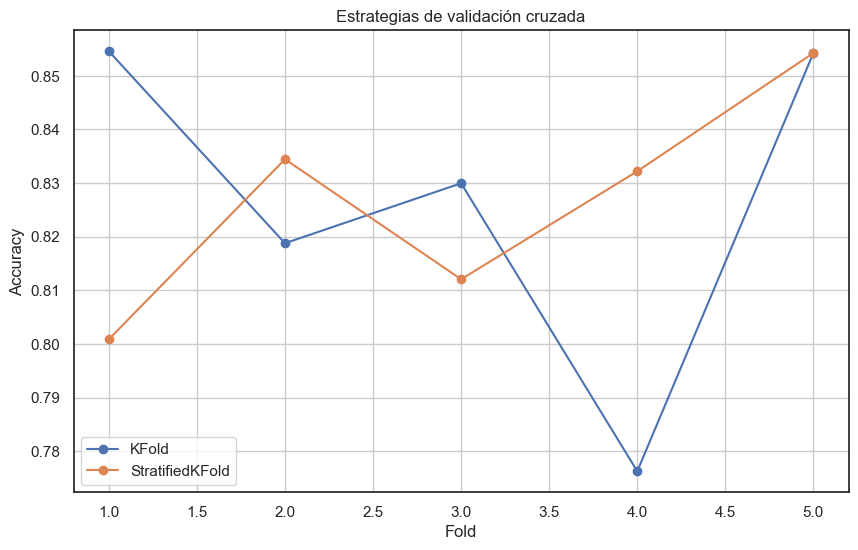

In [117]:
plt.figure(figsize=(10, 6))
for name, scores in results.items():
    plt.plot(range(1, len(scores) + 1), scores, marker='o', label=name)

plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("Estrategias de validación cruzada")
plt.legend()
plt.grid(True)
plt.show()

En el gráfico presentado, se comparan dos estrategias de validación cruzada: KFold y StratifiedKFold, evaluando la precisión (Accuracy) del modelo a lo largo de 5 particiones (Folds). Se observa que StratifiedKFold mantiene una precisión más consistente en comparación con KFold, que muestra una mayor variabilidad. Esto se debe a que StratifiedKFold preserva la distribución de las clases en cada fold, mientras que KFold no lo hace, lo que puede resultar en una evaluación menos estable cuando se trata de conjuntos de datos desbalanceados.

La elección de StratifiedKFold en escenarios con desbalanceo de clases, como en este caso, es crucial para obtener una evaluación más confiable y representativa del rendimiento del modelo.

In [118]:
print("Accuracy para cada K-Fold: ", results['KFold'])
print("Accuracy para cada StratifiedKFold: ", results['StratifiedKFold'])

Accuracy para cada K-Fold:  [0.85458613 0.81879195 0.82997763 0.77628635 0.85426009]
Accuracy para cada StratifiedKFold:  [0.80089485 0.8344519  0.81208054 0.83221477 0.85426009]


In [119]:
for strategy in cv_strategies:
  print('Media para la estrategia', strategy[0],':',results['KFold'].mean())
  print('Desvío estándar para la estrategia', strategy[0],':',results['KFold'].std())

Media para la estrategia KFold : 0.8267804295703293
Desvío estándar para la estrategia KFold : 0.028816586719915518
Media para la estrategia StratifiedKFold : 0.8267804295703293
Desvío estándar para la estrategia StratifiedKFold : 0.028816586719915518


El modelo muestra una precisión promedio de aproximadamente 0.827 en ambas estrategias de validación (K-Fold y StratifiedKFold), con un desvío estándar bajo de 0.029. Esto indica un rendimiento consistente y robusto del modelo, sin variabilidad significativa entre las particiones de los datos.



## Grid Search

In [121]:
# Definimos los parámetros para Grid Search
param_grid = [
    {'penalty': ['l1'], 'solver': ['liblinear', 'saga'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}
]

# Realizamos la búsqueda de hiperparámetros con Grid Search
grid_search = GridSearchCV(estimator=model_c, param_grid=param_grid, cv=5, n_jobs=-1)
start = time.time()
grid_search.fit(X_train_balanced, np.ravel(y_train_balanced))
end = time.time()
grid_search_time = end - start
y_pred_grid_search = grid_search.predict(X_test_balanced)

# Métricas para el modelo con Grid Search
grid_search_accuracy = accuracy_score(y_test_balanced, y_pred_grid_search)
grid_search_precision = precision_score(y_test_balanced, y_pred_grid_search, average='weighted')
grid_search_recall = recall_score(y_test_balanced, y_pred_grid_search, average='weighted')
classification_report_grid_search = classification_report(y_test_balanced, y_pred_grid_search, zero_division=1)


print('Accuracy:', grid_search_accuracy)
print('Precision:', grid_search_precision)
print('Recall:', grid_search_recall)
print('print("Reporte de clasificación:"):')
print(classification_report_grid_search)

Accuracy: 0.8004946413849959
Precision: 0.8288368603535987
Recall: 0.8004946413849959
print("Reporte de clasificación:"):
              precision    recall  f1-score   support

          No       0.91      0.82      0.86      2803
         Yes       0.55      0.74      0.63       836

    accuracy                           0.80      3639
   macro avg       0.73      0.78      0.75      3639
weighted avg       0.83      0.80      0.81      3639



El modelo ha mostrado una precisión general de 0.83 y un recall de 0.80. Sin embargo, al centrarnos en la clase 'Yes', los resultados indican que el modelo tiene una precisión de 0.55 y un recall de 0.74. El F1-Score para la clase 'Yes' es de 0.63, lo que sugiere que el modelo tiene un rendimiento moderado en la identificación de la clase positiva. Aunque el recall es relativamente alto, la precisión baja indica que el modelo tiende a clasificar muchas instancias como 'Yes' incorrectamente. 

## Random Search

In [ ]:
# Definimos los parámetros para Random Search
random_param_grid = [
    {'penalty': ['l1'], 'solver': ['liblinear', 'saga'], 'C': np.logspace(-4, 4, 20)},
    {'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'C': np.logspace(-4, 4, 20)}
]

# Realizamos la búsqueda de hiperparámetros con Random Search
random_search = RandomizedSearchCV(estimator=model_c, param_distributions=random_param_grid, n_iter=10, cv=5, n_jobs=-1)
start = time.time()
random_search.fit(X_train_balanced, np.ravel(y_train_balanced))
end = time.time()
random_search_time = end - start
y_pred_random_search = random_search.predict(X_test_balanced)

# Métricas para el modelo con Random Search
random_search_accuracy = accuracy_score(y_test_balanced, y_pred_random_search)
random_search_precision = precision_score(y_test_balanced, y_pred_random_search, average='weighted')
random_search_recall = recall_score(y_test_balanced, y_pred_random_search, average='weighted')
classification_report_random_search = classification_report(y_test_balanced, y_pred_random_search, zero_division=1)

print('Accuracy:', random_search_accuracy)
print('Precision:', random_search_precision)
print('Recall:', random_search_recall)
print('print("Reporte de clasificación:"):')
print(classification_report_random_search)

Accuracy: 0.8087386644682605
Precision: 0.8328817096081602
Recall: 0.8087386644682605
print("Reporte de clasificación:"):
              precision    recall  f1-score   support

          No       0.91      0.83      0.87      2803
         Yes       0.56      0.73      0.64       836

    accuracy                           0.81      3639
   macro avg       0.74      0.78      0.75      3639
weighted avg       0.83      0.81      0.82      3639



Random Search ha mejorado el F1-Score de la clase 'Yes' a 0.64, con una precisión de 0.56 y un recall de 0.73. Aunque el modelo muestra una mejora general en la identificación de la clase 'Yes', aún tiene margen para optimizar la precisión. 

In [ ]:
# Guardar el scaler para usarlo en la predicción
import joblib
joblib.dump(random_search, 'ModelRS.joblib')

['ModelRS.joblib']

## Tabla comparativa Grid Search & Random Search

In [ ]:
# Creamos una tabla comparativa
results = pd.DataFrame({
    'Modelo': ['Sin Optimización', 'Grid Search', 'Random Search'],
    'Tiempo de Entrenamiento (s)': [no_opt_time, grid_search_time, random_search_time]
})

# Aplicar formato a la tabla
styled_results = results.style.format({
    'Accuracy': "{:.2%}",
    'Precision': "{:.2%}",
    'Recall': "{:.2%}",
    'F1 Score': "{:.2%}",
    'Tiempo de Entrenamiento (s)': "{:.2f}"
})

# Imprimir la tabla
styled_results.set_properties(**{'text-align': 'center'}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'center')]
}])


- Sin Optimización: Tiempo de entrenamiento más corto con 0.13 segundos.
- Grid Search: Ofrece una optimización exhaustiva, pero requiere el mayor tiempo de entrenamiento con 23.86 segundos.
- Random Search: Proporciona un buen equilibrio entre tiempo de entrenamiento y optimización, con 5.03 segundos.

## Optuna

In [ ]:
y_pred

array([0.07073011, 0.09641019, 0.39336525, ..., 0.45114616, 0.64880986,
       0.52391943])

In [ ]:
from sklearn.metrics import f1_score

def train_evaluate_model(params, X_train, y_train, X_test, y_test):
    model = RandomForestClassifier(**params)  # Cambiar a RandomForestClassifier
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test_encoded, y_pred)
    return f1

In [ ]:


def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 200)
    max_depth = trial.suggest_int('max_depth', 5, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)

    params = {
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf
    }

    f1 = train_evaluate_model(params, X_train_balanced, y_train_encoded, X_test_balanced, y_test_encoded)
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
best_optuna_params = study.best_params
best_optuna_model = RandomForestClassifier(**best_optuna_params)
best_optuna_model.fit(X_train_balanced, y_train_encoded)

# Evaluar el modelo final
y_pred = best_optuna_model.predict(X_test_balanced)
print(classification_report(y_test_encoded, y_pred))



[I 2024-08-09 10:29:17,468] A new study created in memory with name: no-name-44e86004-6ae0-4a08-9c58-81e067350280
[I 2024-08-09 10:29:25,366] Trial 0 finished with value: 0.6235154394299287 and parameters: {'n_estimators': 123, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.6235154394299287.
[I 2024-08-09 10:29:36,297] Trial 1 finished with value: 0.6230492196878752 and parameters: {'n_estimators': 147, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.6235154394299287.
[I 2024-08-09 10:29:52,369] Trial 2 finished with value: 0.6345475910693302 and parameters: {'n_estimators': 200, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.6345475910693302.
[I 2024-08-09 10:29:58,976] Trial 3 finished with value: 0.6373748609566184 and parameters: {'n_estimators': 148, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 3 with valu

              precision    recall  f1-score   support

           0       0.90      0.86      0.88      2803
           1       0.60      0.68      0.64       836

    accuracy                           0.82      3639
   macro avg       0.75      0.77      0.76      3639
weighted avg       0.83      0.82      0.83      3639



In [ ]:
# Verificar las etiquetas de y_test y y_pred
print("Unique labels in y_test_encoded:", set(y_test_encoded))
print("Unique labels in y_pred:", set(y_pred))


Unique labels in y_test_encoded: {0, 1}
Unique labels in y_pred: {0, 1}


In [ ]:
from sklearn.model_selection import cross_val_score

# Realizar validación cruzada
cv_scores = cross_val_score(best_optuna_model, X_train_balanced, y_train_encoded, cv=5, scoring='f1')
print(f"Mean F1 Score: {cv_scores.mean()}, Std: {cv_scores.std()}")


Mean F1 Score: 0.8335101311455014, Std: 0.030971528118728817


In [ ]:
# Supongamos que tienes X_test y y_test originales no balanceados
# y_test_encoded_orig = label_encoder.transform(y_test)

y_pred_orig = best_optuna_model.predict(x_test)
print("Classification Report on Original Test Data:")
print(classification_report(y_test_encoded, y_pred_orig))
print("Confusion Matrix on Original Test Data:")
print(confusion_matrix(y_test_encoded, y_pred_orig))


Classification Report on Original Test Data:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      2803
           1       0.60      0.68      0.64       836

    accuracy                           0.82      3639
   macro avg       0.75      0.77      0.76      3639
weighted avg       0.83      0.82      0.83      3639

Confusion Matrix on Original Test Data:
[[2422  381]
 [ 264  572]]


Optuna logro una precisión general del 82% y un F1-Score de 0.64 para la clase 'Yes', con un recall de 0.68. Aunque el modelo presenta una mejora en el rendimiento general, la precisión y el recall para la clase 'Yes' indican que sigue existiendo margen para optimizar la identificación de esta clase.



# SHAP

In [ ]:
# Asegúrate de tener definidos los nombres de las características como una lista
feature_names = X_test_balanced.columns.tolist()
feature_names

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'WindGustDir_N',
 'WindGustDir_S',
 'WindGustDir_W',
 'WindDir9am_N',
 'WindDir9am_S',
 'WindDir9am_W',
 'WindDir3pm_N',
 'WindDir3pm_S',
 'WindDir3pm_W',
 'RainToday_Yes']

In [ ]:
# Crear un objeto explainer SHAP para el modelo de regresión logística
explainer = shap.LinearExplainer(model_c, X_train_balanced)
shap_values = explainer.shap_values(X_test_balanced)

In [ ]:
shap_values.shape

(3639, 26)

In [ ]:
explainer.expected_value

0.1837648248205921

In [ ]:
# Convertir log-odds a probabilidad
expected_probability = 1 / (1 + np.exp(-explainer.expected_value))
print("Probabilidad esperada:", expected_probability)

Probabilidad esperada: 0.5458123569668197


El valor esperado de explainer.expected_value es 0.184 en log-odds, lo que se convierte en una probabilidad esperada de aproximadamente 0.546. Esto indica que, en promedio, el modelo predice una probabilidad del 54.6% de que el evento de interés ocurra, según el valor esperado. 

## Interpretabilidad local

In [ ]:
shap_values[0]

array([ 0.00415562,  0.08079961, -0.21600495, -0.01288927, -0.15989383,
       -1.00136966,  0.01318669,  0.12336437, -0.03402231, -0.68060616,
        0.95489392, -1.64023448,  0.02319183, -0.06249984,  0.08609921,
       -0.08449819,  0.31715421, -0.58370497,  0.17569185,  0.33118298,
       -0.85486248,  0.21102643,  0.11950018, -0.09210639,  0.06878638,
        0.02703847])

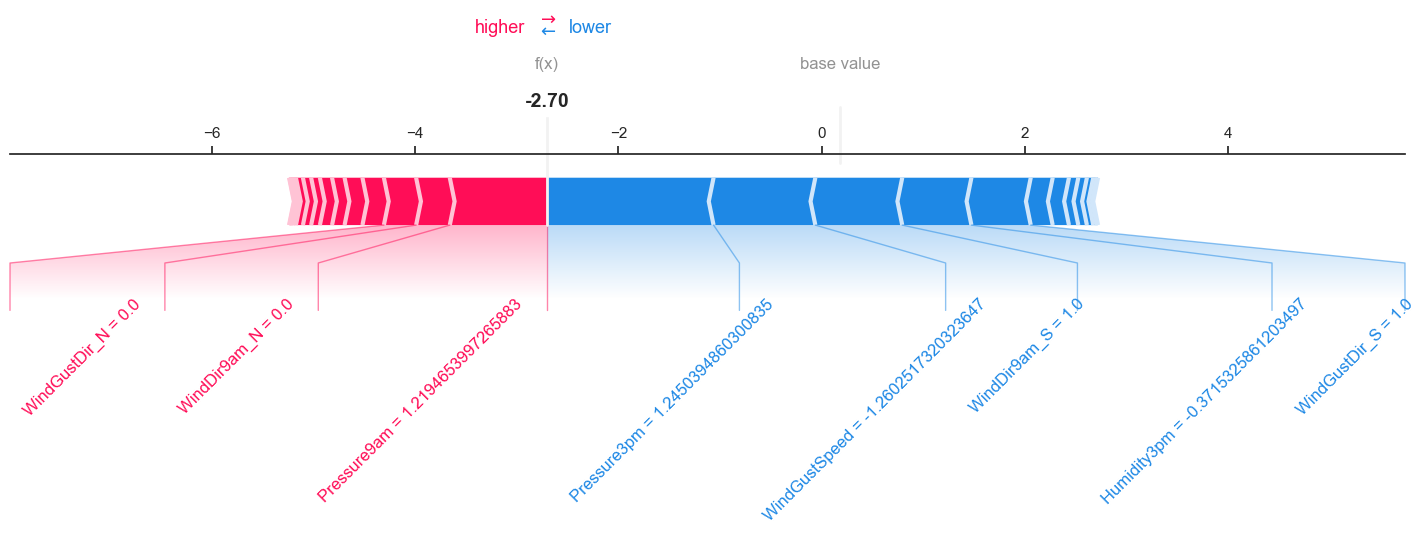

In [ ]:
index=0
shap.force_plot(explainer.expected_value, shap_values[index], X_test_balanced.iloc[index],
                matplotlib=True, figsize=(18, 4),
                text_rotation=45)

Este gráfico muestra cómo cada característica influye en la predicción de una instancia específica.

In [ ]:
# Crear el objeto shap
index = 0
explanation = shap.Explanation(values=shap_values[index], base_values=explainer.expected_value, feature_names=feature_names)

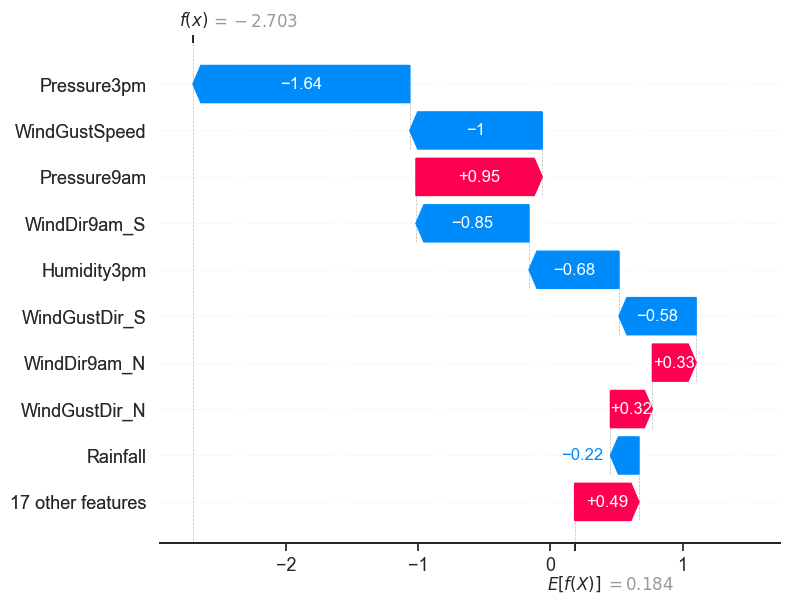

In [ ]:
shap.plots.waterfall(explanation)

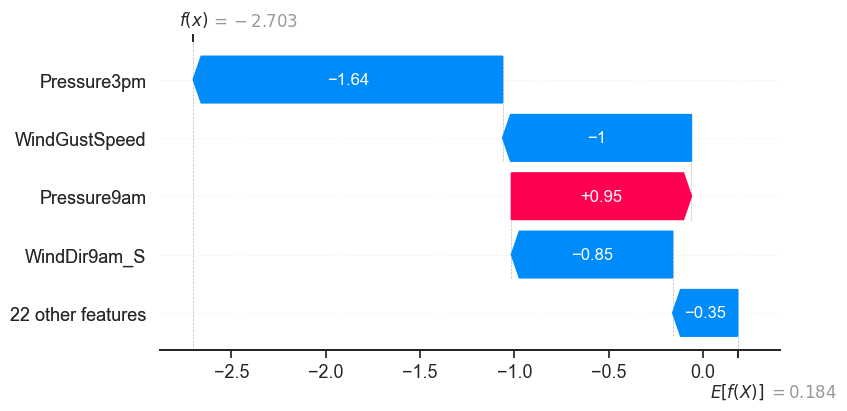

In [ ]:
shap.plots.waterfall(explanation, max_display=5)

*Este grafico nos es util para ver las características individuales y como afectan la predicción para una instancia específica.*

Muestra cómo se construye la predicción de un modelo para una instancia específica (a nivel local) descomponiendo la contribución de cada característica.

Es un gráfico de cascada donde se muestra la contribución acumulada de cada característica comenzando desde el valor base hasta la predicción final. Cada barra representa una característica y su contribución positiva o negativa.

## Interpretabilidad global

Este gráfico muestra la distribución de los valores SHAP para cada característica en el conjunto de datos de prueba. Muestra la influencia de cada característica en las predicciones.

In [ ]:
explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value,feature_names=feature_names, data=X_test_balanced)

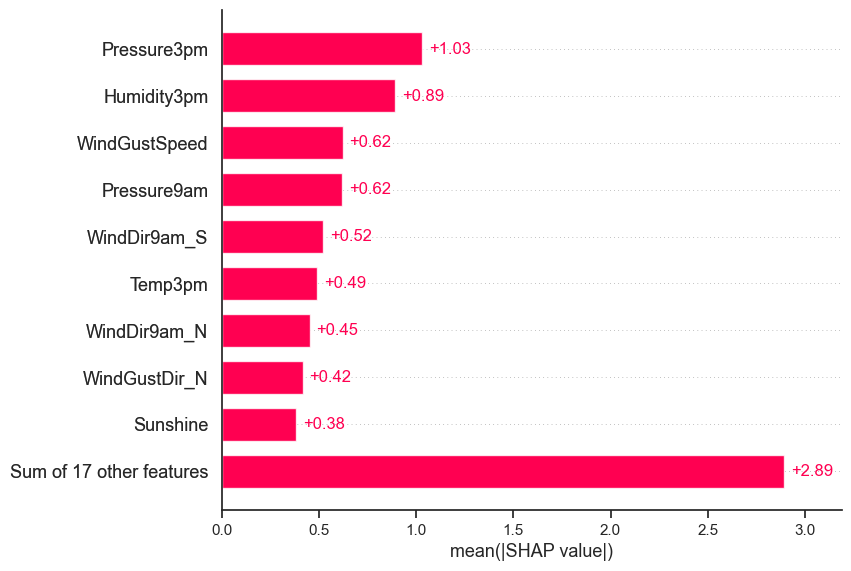

In [ ]:
shap.plots.bar(explanation)

Este gráfico muestra la importancia promedio absoluta de los valores SHAP para cada característica, destacando las características más influyentes.

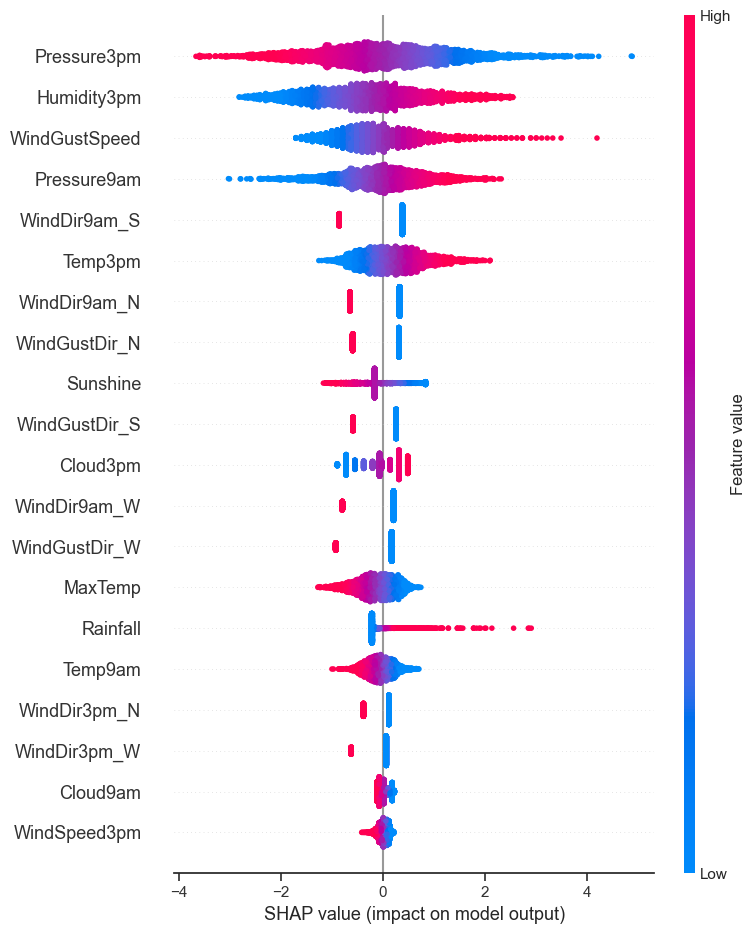

In [ ]:
shap.summary_plot(shap_values, X_test_balanced, feature_names=X_test_balanced.columns)

Este gráfico muestra la distribución de los valores SHAP para cada característica en el conjunto de datos de prueba. Muestra la influencia de cada característica en las predicciones.

**Variables más importantes y menos importantes**

En el gráfico de resumen de SHAP,vemos  las características más importantes aparecerán en la parte superior del gráfico, es decir, *PRESSURE3PM*, *HUMIDITY3PM*,  *WINGUSTSPEED*.y *PRESSURE9AM* .



Podemos observar que estas caractiristicas, tienen una alta variabilidad en los valores SHAP, sugiriendo que tienen un impacto significativo en las predicciones.

# Red Neuronal

- K-Folds: Costoso en términos de tiempo y recursos, ya que requiere entrenar el modelo k veces. Por lo tanto, no se utilizará.

- Grid Search: Puede ser extremadamente costoso debido a la exploración exhaustiva de todas las combinaciones de hiperparámetros, y no maneja bien la importancia variable de los hiperparámetros. Por lo tanto, no se utilizará.

- Random Search: Más eficiente que Grid Search al explorar una muestra aleatoria de combinaciones, pero tiene una cobertura incompleta y no garantiza encontrar las mejores combinaciones. Por lo tanto, no se utilizará.

- Optuna: Utiliza optimización bayesiana avanzada para buscar de manera inteligente en el espacio de hiperparámetros, encontrando buenos conjuntos de hiperparámetros más rápidamente que Grid Search y Random Search. Es ideal para espacios de hiperparámetros grandes y complejos, por lo que se utilizará.

## Regresión logística

In [ ]:

# Crear la red neuronal
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_balanced.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilar el modelo
model.compile(optimizer=Adam(), 
              loss=BinaryCrossentropy(), 
              metrics=[Accuracy()])

# Separar los datos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train_balanced, y_train_encoded, test_size=0.2, random_state=42)

# Entrenar el modelo y guardar la historia del entrenamiento
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val),  # Usar datos de validación separados
                    epochs=50, 
                    batch_size=20,
                    verbose=1)

# Evaluar el modelo en los datos de prueba
loss, accuracy = model.evaluate(X_test_balanced, y_test_encoded)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Realizar predicciones
predictions = model.predict(X_test_balanced)


c:\Users\brisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
894/894 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.0000e+00 - loss: 0.4794 - val_accuracy: 0.0000e+00 - val_loss: 0.4311
Epoch 2/50
894/894 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0000e+00 - loss: 0.4078 - val_accuracy: 0.0000e+00 - val_loss: 0.4066
Epoch 3/50
894/894 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0000e+00 - loss: 0.3855 - val_accuracy: 0.0000e+00 - val_loss: 0.3894
Epoch 4/50
894/894 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0000e+00 - loss: 0.3655 - val_accuracy: 0.0000e+00 - val_loss: 0.3782
Epoch 5/50
894/894 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0000e+00 - loss: 0.3565 - val_accuracy: 0.0000e+00 - val_loss: 0.3750
Epoch 6/50
894/894 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0000e+00 - loss: 0.3480 - val_accuracy: 0.0000e+00 - val_loss: 0.3683
Epoch 7/50
894/894 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0000e+00 - loss: 0.3371 - val_accuracy: 0.0000e+00 - val_loss: 0.3716
Epoch 8/50
894/894 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/s

El modelo parece estar generalizando bien, ya que la precisión en el conjunto de validación es similar a la del conjunto de entrenamiento.


In [ ]:

predict = model.predict(X_test_balanced)
pred = (predict > 0.5).astype(int)  # Binary classification

# Calculate F1 score for the unoptimized model
f1_score_unoptimized = f1_score(y_test_encoded, pred)

print(f"F1 Score for the unoptimized model:")
print(f"- {f1_score_unoptimized:.2f}%")
print(f"- {f1_score_unoptimized:.10f}")

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
F1 Score for the unoptimized model:
- 0.57%
- 0.5700483092


El F1 Score del modelo sin optimización es 0.57. A pesar del balanceo del dataset, este valor muestra un equilibrio moderado entre precisión y recall, indicando que el modelo podría beneficiarse de ajustes adicionales para mejorar la identificación de la clase positiva

### Graficar la pérdida y la precisión a lo largo del entrenamiento

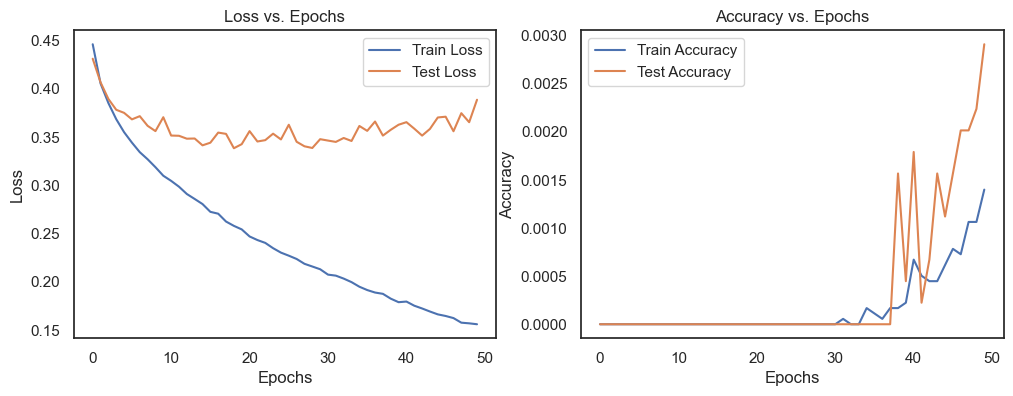

In [ ]:
# Graficar la pérdida y la precisión a lo largo del entrenamiento
plt.figure(figsize=(12, 4))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()

# Precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()

plt.show()

### Optuna

In [ ]:
def objective(trial):
    # Hiperparámetros a optimizar
    n_layers = trial.suggest_int('n_layers', 1, 3)
    n_units = trial.suggest_int('n_units', 32, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    # Crear la red neuronal
    inputs = Input(shape=(X_train_balanced.shape[1],))
    x = Dense(n_units, activation='relu')(inputs)
    x = Dropout(dropout_rate)(x)

    for i in range(n_layers):
        x = Dense(n_units, activation='relu')(x)
        x = Dropout(dropout_rate)(x)

    outputs = Dense(1, activation='sigmoid')(x)
    model_ho = Model(inputs=inputs, outputs=outputs)

    # Compilar el modelo
    model_ho.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo y guardar la historia del entrenamiento
    history = model_ho.fit(X_train_balanced, y_train_encoded, validation_data=(X_test_balanced, y_test_encoded), epochs=50, batch_size=20, verbose=0)

    # Evaluación del modelo en los datos de prueba
    loss, accuracy = model_ho.evaluate(X_test_balanced, y_test_encoded, verbose=0)
    return loss

In [ ]:
# Crear el estudio de Optuna y empezar la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2024-08-09 10:33:18,416] A new study created in memory with name: no-name-ce7439e2-0581-45bc-9940-6fdfd5d49b3e
[I 2024-08-09 10:35:33,887] Trial 0 finished with value: 0.48176634311676025 and parameters: {'n_layers': 2, 'n_units': 89, 'dropout_rate': 0.1998755097347923, 'learning_rate': 0.0010494977277982415}. Best is trial 0 with value: 0.48176634311676025.
[I 2024-08-09 10:39:04,542] Trial 1 finished with value: 0.4778793752193451 and parameters: {'n_layers': 3, 'n_units': 105, 'dropout_rate': 0.08130685565714268, 'learning_rate': 8.755062370376488e-05}. Best is trial 0 with value: 0.48176634311676025.
[I 2024-08-09 10:41:51,262] Trial 2 finished with value: 0.5801416039466858 and parameters: {'n_layers': 1, 'n_units': 62, 'dropout_rate': 0.08133013840126474, 'learning_rate': 0.007843442167773588}. Best is trial 2 with value: 0.5801416039466858.
[I 2024-08-09 10:45:07,267] Trial 3 finished with value: 0.4591030776500702 and parameters: {'n_layers': 2, 'n_units': 94, 'dropout_rate'

In [ ]:
# obtener los mejores hiperparámetros
best_params = study.best_params
print("Best parámetros encontrados:", best_params)

Best parámetros encontrados: {'n_layers': 2, 'n_units': 82, 'dropout_rate': 0.0009781317465895924, 'learning_rate': 0.0033089232791644876}


n_layers (número de capas): El modelo óptimo tiene 2 capas ocultas.

n_units (número de unidades en la capa oculta): Hay 82 unidades en la capa oculta del modelo.

dropout_rate (tasa de abandono): La tasa de abandono óptima, que controla el porcentaje de conexiones que se desactivan aleatoriamente durante el entrenamiento para evitar el sobreajuste, es aproximadamente del 0,0009%.

learning_rate (tasa de aprendizaje): La tasa de aprendizaje óptima, que controla la magnitud de los ajustes que se realizan durante el entrenamiento, es de aproximadamente 0.0033%.

### Modelo con los hiperparametros optimizados

In [ ]:
# Hiperparámetros optimizados
n_layers = 2
n_units = 82
dropout_rate = 0.0009781317465895924
learning_rate = 0.0033089232791644876

# Crear la red neuronal con los hiperparámetros optimizados
model_ho = Sequential()
model_ho.add(Dense(n_units, activation='relu', input_shape=(X_train_balanced.shape[1],)))
model_ho.add(Dropout(dropout_rate))

for _ in range(n_layers - 1):
    model_ho.add(Dense(n_units, activation='relu'))
    model_ho.add(Dropout(dropout_rate))

model_ho.add(Dense(1, activation='sigmoid'))

# Compilar el modelo con la tasa de aprendizaje optimizada
optimizer = Adam(learning_rate=learning_rate)
model_ho.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo y guardar la historia del entrenamiento
history = model_ho.fit(X_train_balanced, y_train_encoded, validation_data=(X_test_balanced, y_test_encoded), epochs=50, batch_size=20)

c:\Users\brisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1117/1117 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7681 - loss: 0.4736 - val_accuracy: 0.7895 - val_loss: 0.4735
Epoch 2/50
1117/1117 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8219 - loss: 0.3952 - val_accuracy: 0.8071 - val_loss: 0.4222
Epoch 3/50
1117/1117 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8332 - loss: 0.3702 - val_accuracy: 0.8217 - val_loss: 0.4132
Epoch 4/50
1117/1117 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8463 - loss: 0.3470 - val_accuracy: 0.8222 - val_loss: 0.4088
Epoch 5/50
1117/1117 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8559 - loss: 0.3355 - val_accuracy: 0.8173 - val_loss: 0.4081
Epoch 6/50
1117/1117 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8634 - loss: 0.3159 - val_accuracy: 0.8109 - val_loss: 0.4433
Epoch 7/50
1117/1117 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8715 - loss: 0.3074 - val_accuracy: 0.8156 - val_loss: 0.4257
Epoch 8/50
1117/1117 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8750 - loss: 0.2961 - 

In [ ]:
# Make predictions for the optimized model
predict_ho = model_ho.predict(X_test_balanced)
pred_ho = (predict_ho > 0.5).astype(int)  # Binary classification

classification_report_logreg_ho = classification_report(y_test_encoded, pred_ho, zero_division=1)
print("Reporte de clasificación:")
print(classification_report_logreg_ho)

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.88      0.85      0.86      2803
           1       0.55      0.63      0.58       836

    accuracy                           0.80      3639
   macro avg       0.72      0.74      0.72      3639
weighted avg       0.81      0.80      0.80      3639



El modelo con hiperparámetros optimizados tiene un F1 Score de 0.58 para la clase 'Yes', con un recall mejorado de 0.63. Aunque la precisión para la clase 'Yes' sigue siendo baja, el modelo muestra mejoras generales con una precisión del 81% y un F1 Score ponderado del 0.80. Esto indica que, aunque se ha logrado una mejora, aún es posible optimizar más el rendimiento en la identificación de la clase positiva.

In [ ]:
# Guardar el scaler para usarlo en la predicción
import joblib
joblib.dump(model_ho, 'ModelNN.joblib')

['ModelNN.joblib']

### SHAP

#### Explicabilidad local

In [ ]:

# Crear un conjunto de muestras de fondo
background = X_train_balanced.sample(100)

# Crear el objeto explainer SHAP utilizando KernelExplainer
explainer = shap.KernelExplainer(model, background)

In [ ]:


instance_to_explain = X_test_balanced.iloc[0:1].values  # Seleccionar la línea 0

# Calcular los valores SHAP para los datos de prueba
shap_values = explainer.shap_values(instance_to_explain)

100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


In [ ]:

# Obtener el valor esperado (base value)
expected_value = explainer.expected_value

# Hacer predicciones
index = 0  # índice de la instancia que queremos explicar
predicted_proba = model.predict(X_test_balanced)[index]  # Predicción de probabilidad
predicted_class = np.argmax(predicted_proba)  # Clase predicha

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
import shap
import numpy as np

# Asegúrate de utilizar el método adecuado para generar shap_values
explainer = shap.Explainer(model, X_train_balanced)

# Verificar el tipo de datos de shap_values
print("Type of shap_values:", type(shap_values))

# Verificar la forma de shap_values para asegurarte de que sea correcta
if isinstance(shap_values, np.ndarray):
    print("Shape of shap_values:", shap_values.shape)
else:
    print("Error: shap_values no es un arreglo NumPy válido.")




PermutationExplainer explainer: 3640it [02:59, 20.33it/s]                          


Type of shap_values: <class 'numpy.ndarray'>
Shape of shap_values: (3639, 26)


Por lo tanto, el shape (3639, 26) indica que para cada una de las 3639 muestras, se están calculando los valores SHAP para las 26 características del modelo. Estos valores muestran cómo cada característica contribuye a la predicción de cada muestra.

Shape of shap_values: (3639, 26)
Shape of shap_values_single: (26,)


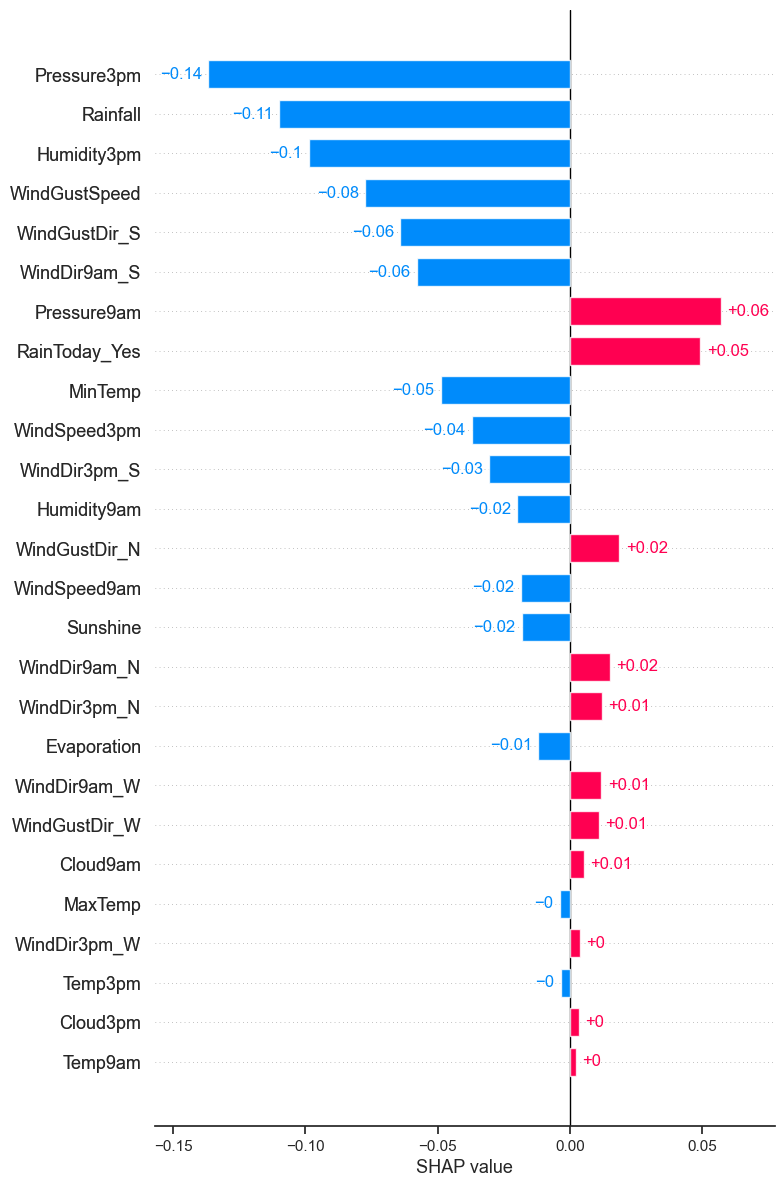

In [ ]:
# Verificar la forma de shap_values
print("Shape of shap_values:", shap_values.shape)  # Salida: (1, 26, 1)

# Asegurarse de acceder correctamente a la primera instancia de explicación
shap_values_single = shap_values[0]

# Verificar la forma de shap_values_single para confirmar que ahora es (26, 1)
print("Shape of shap_values_single:", shap_values_single.shape)  # Salida: (26, 1)

# Crear la explicación para la instancia específica
explanation = shap.Explanation(values=shap_values_single, base_values=expected_value, feature_names=feature_names)

# Visualizar la explicación de las importancias de las características usando shap.plots.bar
shap.initjs()
shap.plots.bar(explanation, max_display=len(feature_names))

#### Explicabilidad global


In [ ]:
import shap

# Seleccionar una única instancia para explicar
instance_to_explain = X_test_balanced.sample(n=1).values



PermutationExplainer explainer: 3640it [05:31, 10.67it/s]                          


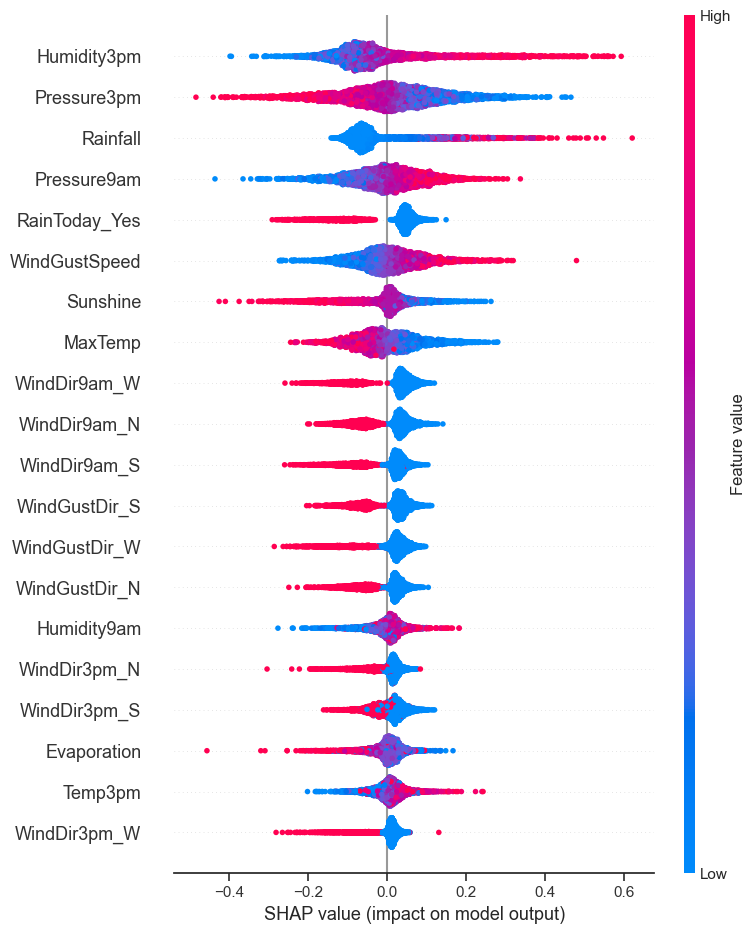

In [ ]:
# Crear un objeto PermutationExplainer
explainer = shap.Explainer(model, X_test_balanced, algorithm='permutation')

# Obtener los valores SHAP para el conjunto de prueba
shap_values = explainer(X_test_balanced)

# Visualizar los valores SHAP
shap.summary_plot(shap_values, X_test_balanced)


In [ ]:

explanation = shap.Explanation(values=shap_values[0][0], base_values=expected_value[0], feature_names=feature_names)


PermutationExplainer explainer: 3640it [05:26, 10.79it/s]                          


Type of shap_values: <class 'shap._explanation.Explanation'>


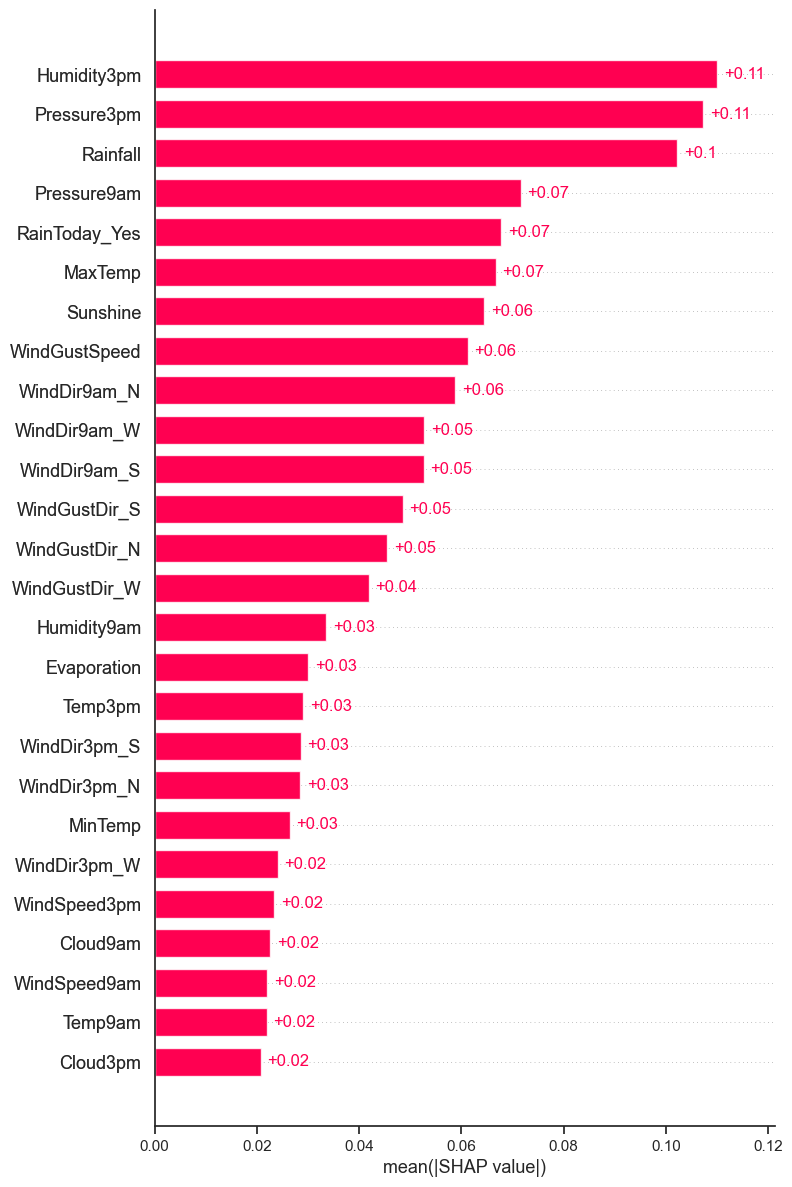

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Verificar el tipo de datos de shap_values
print("Type of shap_values:", type(shap_values))

# Crear la explicación para las importancias de las características globales
feature_names = X_test_balanced.columns  # Ajusta según sea necesario
explanation = shap.Explanation(values=shap_values.values, base_values=shap_values.base_values, data=X_test_balanced, feature_names=feature_names)

# Inicializar JS para gráficos interactivos si estás en Jupyter Notebook
shap.initjs()

# Visualizar la explicación de las importancias de las características usando shap.plots.bar
plt.figure(figsize=(12, 6))  # Ajusta el tamaño de la figura según sea necesario
shap.plots.bar(explanation, max_display=len(feature_names))

# Mostrar el gráfico
plt.show()


## Regresión Lineal

In [ ]:
import tensorflow as tf
import numpy as np

class NeuralNetworkTensorFlow:
    def __init__(self):
        self.model = self.build_model()

    def build_model(self):
        """
        Construye y compila el modelo de red neuronal.

        Returns:
        - El modelo compilado.
        """
        model = tf.keras.Sequential([
            tf.keras.Input(shape=(26,)),  # Capa de entrada con 26 características
            tf.keras.layers.Dense(64, activation='leaky_relu'),  # Capa oculta con 64 neuronas y activación Leaky ReLU
            tf.keras.layers.Dense(32, activation='leaky_relu'),  # Otra capa oculta con 32 neuronas y activación Leaky ReLU
            tf.keras.layers.Dense(1, activation='sigmoid')  # Capa de salida con 1 neurona y activación sigmoide para clasificación binaria
        ])
        # Compila el modelo con el optimizador Adam y la pérdida de entropía cruzada binaria
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

    def fit(self, X, y, lr=0.001, epochs=100, batch_size=32):
        """
        Entrena el modelo con los datos proporcionados.

        Parámetros:
        - lr: Tasa de aprendizaje, valor por defecto es 0.001.
        - epochs: Número de épocas para entrenar el modelo, valor por defecto es 100.
        - batch_size: Tamaño del lote durante el entrenamiento, valor por defecto es 32.

        Retorna:
        - Una lista de valores de pérdida a lo largo de las épocas.
        """
        X = np.array(X)
        y = np.array(y)
        self.model.optimizer.lr = lr  # Ajusta la tasa de aprendizaje
        # Entrena el modelo y guarda la historia de pérdida
        history = self.model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1)
        return history.history['loss']

    def predict(self, X):
        """
        Realiza predicciones sobre los datos proporcionados.
        """
        X = np.array(X)
        # Predice los valores y convierte probabilidades en clases binarias
        predictions = self.model.predict(X)
        return (predictions > 0.5).astype(int)  # Convierte probabilidades a clases binarias (0 o 1)


**Número de Neuronas en la Capa Oculta:**

- 64 Neuronas: Es un número equilibrado que no es ni demasiado pequeño ni demasiado grande. Captura patrones complejos sin sobreajuste.
- 32 Neuronas: Reduce dimensionalidad para aprender representaciones más abstractas.
Número de Capas:

_ **Capas Ocultas:** Permiten aprender representaciones no lineales de los datos; se usan múltiples capas para capturar características generales y específicas.
- **Capa de Entrada:** Debe coincidir con el número de características del dataset (26 en este caso).
- **Capa de Salida:** Producción de salida final para clasificación binaria (1 neurona con activación sigmoid).

**Activación:**

- **Leaky ReLU:** Se usa para producir una probabilidad entre 0 y 1. Permite que algunos valores negativos pasen, evitando el problema de "neurona muerta"; útil para redes profundas.
- **ReLU:** Común por su simplicidad y eficiencia; activa neuronas solo si la entrada es positiva. Además, no está acotada, lo cual no es adecuado para producir probabilidades entre 0 y 1. Es más común en capas ocultas para introducir no linealidades en el modelo.

In [ ]:
nn_tensorflow = NeuralNetworkTensorFlow()
loss_history = nn_tensorflow.fit(X_train_balanced, y_train_encoded, lr=1, epochs=100)

Epoch 1/100
698/698 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7497 - loss: 0.4955
Epoch 2/100
698/698 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8072 - loss: 0.4185
Epoch 3/100
698/698 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8212 - loss: 0.3948
Epoch 4/100
698/698 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8256 - loss: 0.3799
Epoch 5/100
698/698 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8309 - loss: 0.3755
Epoch 6/100
698/698 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8358 - loss: 0.3668
Epoch 7/100
698/698 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8380 - loss: 0.3598
Epoch 8/100
698/698 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8430 - loss: 0.3547
Epoch 9/100
698/698 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8467 - loss: 0.3529
Epoch 10/100
698/698 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8486 - loss: 0.3433
Epoch 11/100
698/698 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8471 - loss: 0.3435
Epoch 12/100
698/698 ━━━━━━━━━━━━━━━━━━━━

### Grafico de perdida NN & Regresion lineal

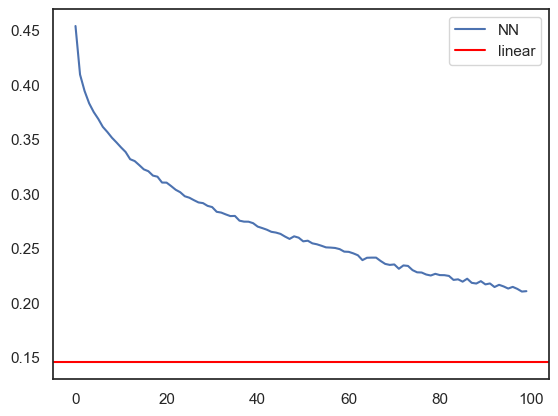

In [ ]:
plt.plot(loss_history, label='NN')
plt.axhline(mse, color='red', label='linear',linestyle = '-')
plt.legend()
plt.show()

- La línea etiquetada como “NN” muestra una disminución pronunciada en la pérdida al principio, lo que indica un aprendizaje rápido, y luego se estabiliza, lo que sugiere que el modelo está convergiendo y mejorando su precisión con cada iteración.
- La línea etiquetada como “lineal” permanece constante, lo que podría indicar que el modelo lineal no está aprendiendo o mejorando con el tiempo, o que ya ha alcanzado su capacidad máxima desde el principio.
- La comparación entre las dos líneas sugiere que la red neuronal tiene una mayor capacidad para aprender y adaptarse a los datos, mientras que el modelo lineal tiene un rendimiento constante y posiblemente limitado.

In [ ]:
predictions = nn_tensorflow.predict(X_test_balanced)

# Métricas para el modelo
mse_rn = mean_squared_error(y_test_encoded, predictions)
print(f"mean squared error: {mse_rn}")

114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
mean squared error: 0.21764220939818632


El (MSE) de 0.2176 en la red neuronal de regresión indica el promedio de las diferencias al cuadrado entre las predicciones del modelo y los valores reales de tu conjunto de prueba.

### Optuna

In [ ]:
def objective(trial):

    num_layers = trial.suggest_int('num_layers', 1, 3)
    model = Sequential()

    for i in range(num_layers):
        num_units = trial.suggest_int(f'n_units_layer_{i}', 1, 32) # la cantidad de neuronas de cada capa tambien se puede pasar como hiperparámetro
        # activations = trial.suggest_categorical(f'')
        model.add(Dense(num_units, activation='sigmoid')) # capas densas con activacion sigmoidea

    # capa de salida
    model.add(Dense(1, activation='relu')) #  es la clase de salida

    # compilar
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

    # Sugerir el número de epochs como hiperparámetro
    epochs = trial.suggest_int('epochs', 5, 10)

    # entrenar
    model.fit(X_train_balanced, y_train_encoded, validation_data=(X_test_balanced, y_test_encoded), epochs=epochs, batch_size=32, verbose=0)

    # evaluar
    score = model.evaluate(X_test_balanced, y_test_encoded, verbose=0)
    return score[1]

In [ ]:
# crear un estudio de Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2024-08-09 14:32:29,100] A new study created in memory with name: no-name-8e43e7ea-a00f-4f25-a635-972889e52b7f
[I 2024-08-09 14:32:45,667] Trial 0 finished with value: 0.2297334372997284 and parameters: {'num_layers': 3, 'n_units_layer_0': 20, 'n_units_layer_1': 22, 'n_units_layer_2': 28, 'epochs': 7}. Best is trial 0 with value: 0.2297334372997284.
[I 2024-08-09 14:32:55,496] Trial 1 finished with value: 0.22973087430000305 and parameters: {'num_layers': 2, 'n_units_layer_0': 27, 'n_units_layer_1': 10, 'epochs': 6}. Best is trial 0 with value: 0.2297334372997284.
[I 2024-08-09 14:33:03,852] Trial 2 finished with value: 0.2297334372997284 and parameters: {'num_layers': 2, 'n_units_layer_0': 1, 'n_units_layer_1': 5, 'epochs': 5}. Best is trial 0 with value: 0.2297334372997284.
[I 2024-08-09 14:33:13,541] Trial 3 finished with value: 0.2297334372997284 and parameters: {'num_layers': 1, 'n_units_layer_0': 1, 'epochs': 7}. Best is trial 0 with value: 0.2297334372997284.
[I 2024-08-09 14

La dirección especificada es 'maximice', lo que significa que Optuna va a intentar encontrar los hiperparámetros que maximizen la métrica de evaluación .
Este estudio se almacena en la memoria y no en una base de datos persistente.

In [ ]:
# obtener los mejores hiperparámetros
best_params = study.best_params
print("Best parámetros encontrados:", best_params)

Best parámetros encontrados: {'num_layers': 3, 'n_units_layer_0': 20, 'n_units_layer_1': 22, 'n_units_layer_2': 28, 'epochs': 7}


Los mejores hiperparámetros encontrados para el modelo de red neuronal son: 3 capas ocultas con 20, 22 y 28 neuronas respectivamente, y un total de 7 épocas para el entrenamiento.

### Modelo con los hiperparametros optimizados

In [ ]:

# Crear el modelo de red neuronal con los mejores hiperparámetros
model_r = Sequential()
model_r.add(Dense(20, activation='relu', input_shape=(26,)))  # Capa oculta con 20 neuronas y función de activación ReLU
model_r.add(Dense(22, activation='relu'))  # Capa oculta con 22 neuronas y función de activación ReLU
model_r.add(Dense(28, activation='relu'))  # Capa oculta con 28 neuronas y función de activación ReLU
model_r.add(Dense(1))  # Capa de salida con 1 neurona, sin función de activación (lineal) para regresión

# Compilar el modelo
model_r.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

# Entrenar el modelo
model_fit = model_r.fit(
    X_train_balanced, 
    y_train_encoded, 
    epochs=7,  # Número de épocas basado en los resultados óptimos
    batch_size=32, 
    validation_data=(X_test_balanced, y_test_encoded)
)


c:\Users\brisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/7
698/698 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1914 - mse: 0.1914 - val_loss: 0.1466 - val_mse: 0.1466
Epoch 2/7
698/698 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1453 - mse: 0.1453 - val_loss: 0.1564 - val_mse: 0.1564
Epoch 3/7
698/698 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1344 - mse: 0.1344 - val_loss: 0.1519 - val_mse: 0.1519
Epoch 4/7
698/698 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1309 - mse: 0.1309 - val_loss: 0.1365 - val_mse: 0.1365
Epoch 5/7
698/698 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1250 - mse: 0.1250 - val_loss: 0.1398 - val_mse: 0.1398
Epoch 6/7
698/698 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1235 - mse: 0.1235 - val_loss: 0.1454 - val_mse: 0.1454
Epoch 7/7
698/698 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1238 - mse: 0.1238 - val_loss: 0.1389 - val_mse: 0.1389


In [ ]:
# Hacer predicciones
y_pred_rn_op = model_r.predict(X_test_balanced)

# Métricas para el modelo
mse_rn_op = mean_squared_error(y_test_encoded, y_pred_rn_op)

print(f"mean squared error: {mse_rn_op}")

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
mean squared error: 0.13891285899895534


La mejora en el error cuadrático medio (MSE) de 0.21 a 0.1389 tras la optimización de los hiperparámetros sugiere que el ajuste de los parámetros ha tenido un impacto positivo significativo en el rendimiento del modelo, reduciendo el error en las predicciones y mejorando la precisión general del modelo.

### SHAP

#### Explicabilidad local

In [ ]:
# Crea un objeto explainer SHAP
feature_names = X_train_balanced.columns.values
feature_names

# Crear un conjunto de muestras de fondo
background = X_train_balanced.sample(100)

explainer = shap.KernelExplainer(model_r,background)

In [ ]:
instance_to_explain = X_test_balanced.iloc[0:1].values  

# Calcular los valores SHAP para los datos de prueba
shap_values = explainer.shap_values(instance_to_explain)

100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


In [ ]:
shap_values = shap_values.reshape(26,)
shap_values

array([-0.02737612,  0.00439754, -0.02920121,  0.00334419, -0.02006715,
       -0.12032996, -0.00120813, -0.01579787, -0.00691701, -0.09256809,
        0.09628815, -0.26439652,  0.01507579, -0.00595568, -0.01104699,
        0.01118926,  0.03961477, -0.07421285,  0.01603655,  0.0347561 ,
       -0.10632033,  0.02177795,  0.03017062, -0.03573241,  0.01197952,
        0.02926028])

In [ ]:
# Obtener el valor esperado (base value)
expected_value = explainer.expected_value

# Hacer predicciones
index = 0  # índice de la instancia que queremos explicar
predicted_proba = nn_tensorflow.model.predict(X_test_balanced)[index]  # Predicción de probabilidad
predicted_class = np.argmax(predicted_proba)  # Clase predicha

shap_values[index]
explanation = shap.Explanation(values=shap_values[index], base_values=explainer.expected_value, feature_names=feature_names)

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


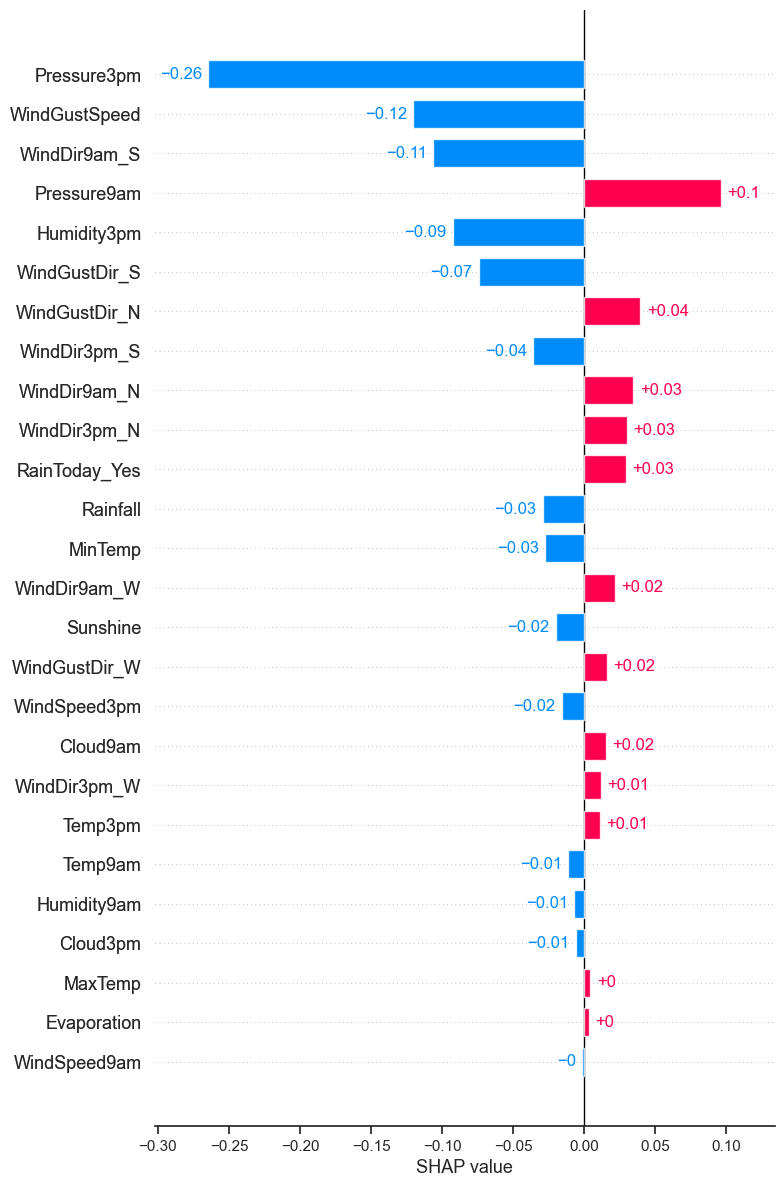

In [ ]:
# Crear la explicación para la instancia específica
explanation = shap.Explanation(values=shap_values, base_values=expected_value, feature_names=feature_names)

# Visualizar la explicación
shap.initjs()
shap.plots.bar(explanation, max_display=26)

“Pressure3pm” y “WindGustSpeed” tienen un impacto significativo en la predicción, con valores SHAP de aproximadamente -0.26 y -0.12 respectivamente.

“Pressure9am” y “WindDir9am_S” también son importantes, con valores SHAP de -0.11 y +0.1.

“WindSpeed9am”, “Evaporation”, “Maxtemp” y “Cloud3pm” muestran impactos significativamente menores en comparación con otras características

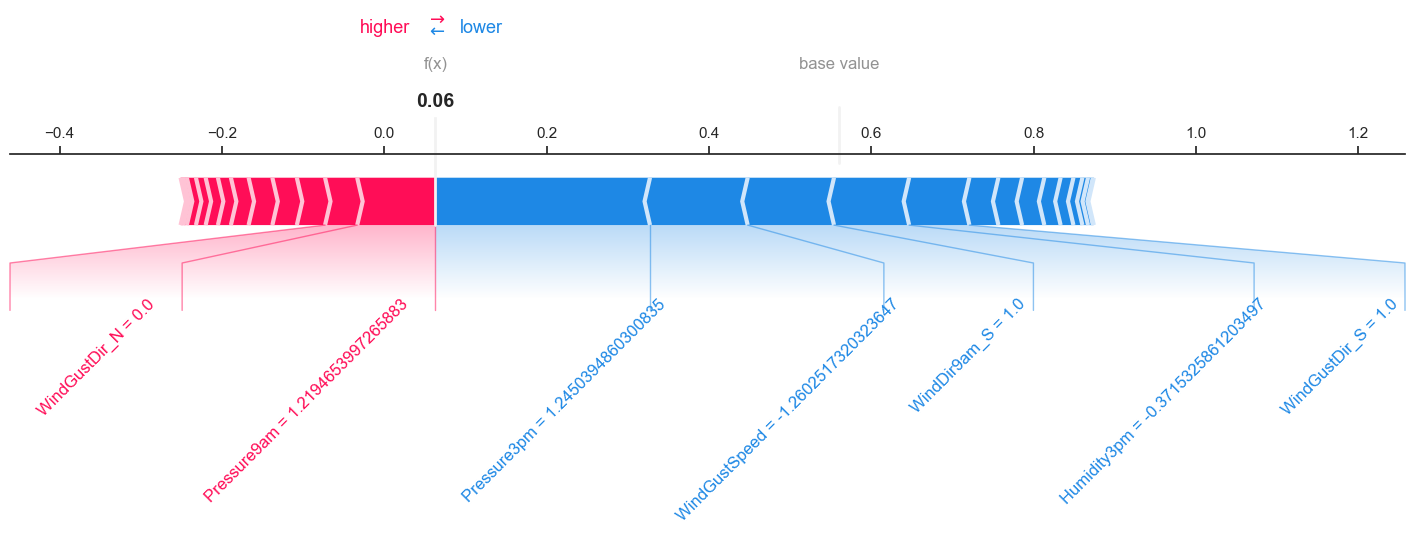

In [ ]:
shap.force_plot(explainer.expected_value, shap_values, X_test_balanced.iloc[0], feature_names=feature_names, matplotlib=True, figsize=(18, 4), text_rotation=45)


Gráfico de fuerza SHAP que representa el impacto de diferentes características en la predicción del modelo.

Impacto Positivo (Rosa): Características como “Humidity9am” y “WindGustDir_S”  tienen un impacto positivo significativo en la predicción, con valores SHAP altos.

Impacto Negativo (Azul): Características como  “Pressure9am” y “WindGustDir_N” tienen un impacto negativo significativo en la predicción, con valores SHAP bajos.


#### Explicabilidad global

In [ ]:
instance_to_explain = X_train_balanced.sample(10)

# Calcular los valores SHAP para los datos de prueba
shap_values = explainer.shap_values(instance_to_explain)
shap_values_squeezed = np.squeeze(shap_values)


100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


In [ ]:

feature_names = X_test_balanced.columns.values

In [ ]:

# Obtener el valor esperado (base value)
expected_value = explainer.expected_value

explanation = shap.Explanation(values=shap_values_squeezed, base_values=expected_value[0], feature_names=feature_names)


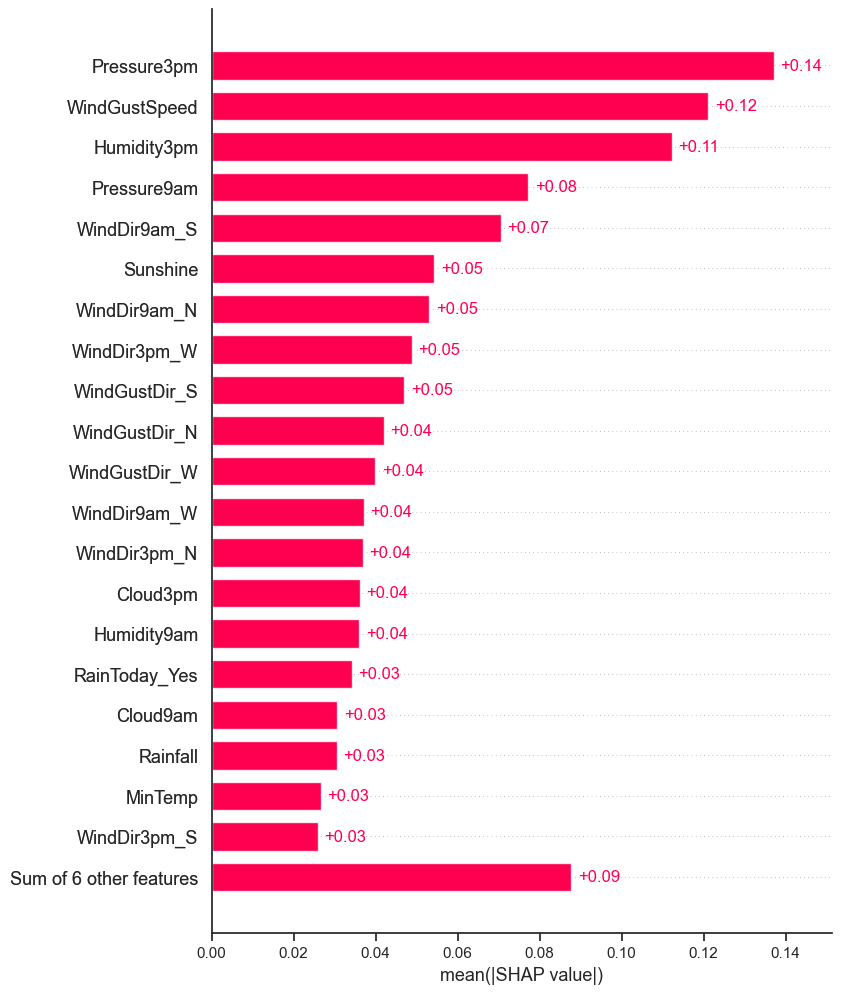

In [ ]:
# Visualizar la explicación
shap.initjs()
shap.plots.bar(explanation, max_display=21)


En este gráfico podemos observar que las variables que más aportan explicabilidad a nuestro modelo de redes neuronales son:

“Pressure3pm” tiene el impacto más positivo con un valor SHAP de +0.14.

“WindGustSpeed” muestra un impacto positivo moderado con un valor SHAP de +0.12.

“Humidity3pm” tiene un impacto positivo con un valor SHAP de +0.11.

“Pressure9am” tiene el impacto más positivo con un valor SHAP de +0.8.






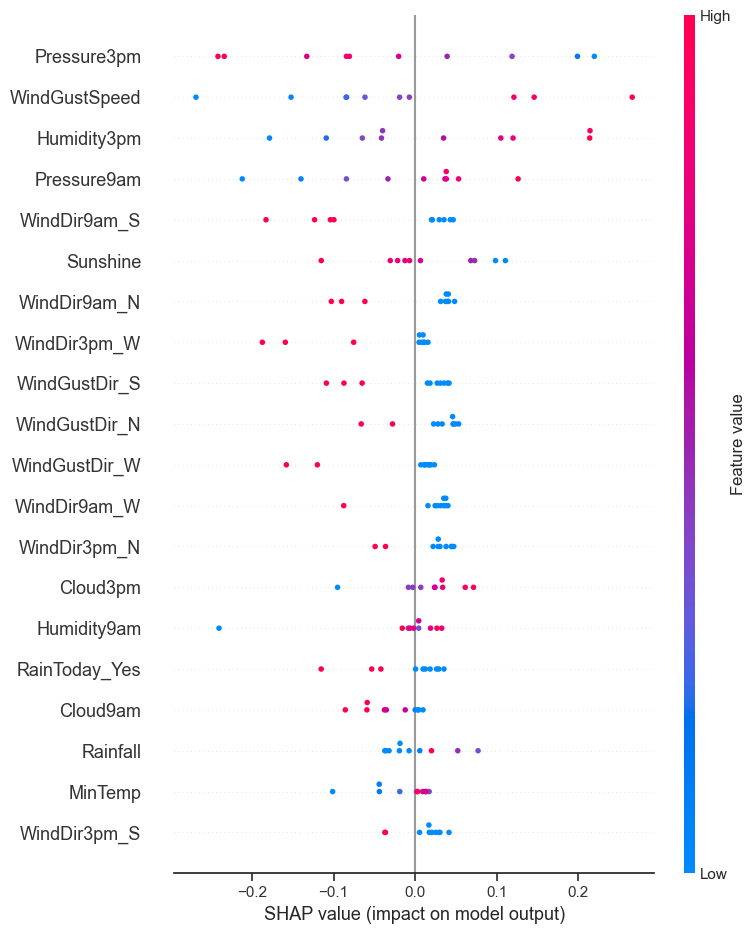

In [ ]:

shap.summary_plot(shap_values_squeezed, instance_to_explain)

Estos valores indican que estas características tienen un papel crucial en la predicción del modelo, con Pressure9am siendo la más influyente en términos de contribución positiva.

#### Comparacion de explicabilidades

Al comparar ambas explicabilidades, se observa que en ambas se destacan las mismas variables, aunque con algunas diferencias en el orden de importancia.

### Matriz de confusion

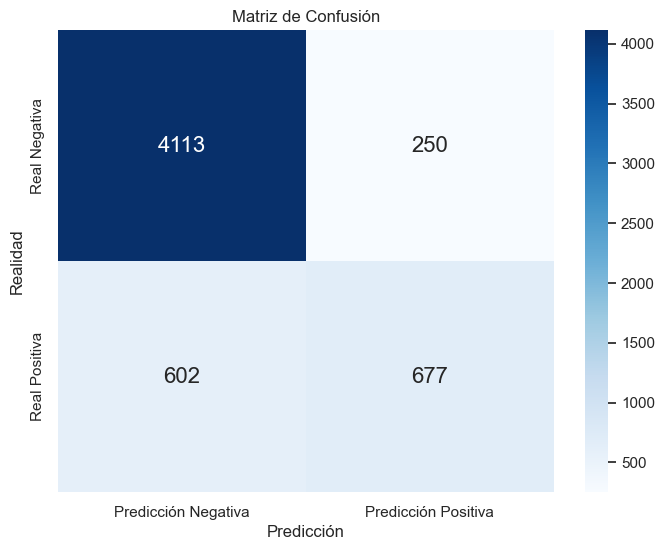

In [ ]:
# Definir los valores de la matriz de confusión
tn, fp, fn, tp = 4113, 250, 602, 677

# Construir la matriz de confusión
conf_matrix = np.array([[tn, fp], [fn, tp]])

# Mostrar la matriz de confusión utilizando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={'size': 16},
            xticklabels=['Predicción Negativa', 'Predicción Positiva'],
            yticklabels=['Real Negativa', 'Real Positiva'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()



# Comparación de Modelos de Regresión usando MSE

| Modelo/Técnica | MSE |
|----------------|-----|
| Modelo Base | 0.1455 |
| Regresión Lineal Inicial | 0.1481 |
| Gradiente Descendiente | 0.1440 |
| Lasso | 0.1847 |
| Ridge | 0.1455 |
| ElasticNet | 0.1636 |
| Red Neuronal | 0.1389 |

### Interpretación de Mis Resultados

La Red Neuronal emerge como el modelo más preciso para la predicción en este conjunto de datos, seguido de cerca por el modelo basado en Gradiente Descendiente. Por otro lado, técnicas como Lasso y ElasticNet no parecen ser tan adecuadas en este contexto específico.

## Comparación de Modelos de Clasificación usando F1-score

| Modelo/Técnica | F1-score |
|----------------|----------|
| Modelo Base | 0.63 |
| Regresión Logística Inicial | 0.63 |
| Regresión Logística (Grid Search) | 0.63 |
| Regresión Logística (Random Search) | 0.64 |
| Red Neuronal | 0.58 |

### Interpretación de Mis Resultados

La Regresión Logística con Random Search se destaca como la mejor opción en términos de F1-Score, proporcionando un ligero pero significativo aumento en la capacidad de predecir correctamente la clase 'Yes'.